In [1]:
import tensorflow as tf
import transformers
import keras

print("TensorFlow version:", tf.__version__)
print("Transformers version:", transformers.__version__)
print("Keras version:", keras.__version__)

TensorFlow version: 2.17.1
Transformers version: 4.47.0
Keras version: 3.5.0


In [2]:
#!pip install transformers==4.37.2 tensorflow==2.15.1

# Hyperparameter Tuning

In [3]:
import tensorflow as tf

# Hyperparameters yang disarankan
layer_unit = 32                # Kapasitas layer yang lebih besar
dropout_val = 0.1              # Sedikit menurunkan dropout
batch_size = 16                # Batch lebih kecil untuk stabilitas
learning_rate = 1e-6           # Sedikit menurunkan learning rate
initial_lr = 1e-4  # Learning rate awal sebelum warmup
weight_decay = 0.01            # Tetap
gamma = 3                    # Meningkatkan gamma untuk penalti kelas minoritas
alpha = 0.25                   # Tetap
epochs = 8                   # Tetap, sesuaikan sesuai kebutuhan
activation_function = 'relu'
l2_values = tf.keras.regularizers.l2(0.003)

# Import Data

In [4]:
from transformers import AutoTokenizer,TFAutoModel,AutoModel
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p2")
IndoBert = TFAutoModel.from_pretrained("indobenchmark/indobert-base-p2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tf_model.h5:   0%|          | 0.00/656M [00:00<?, ?B/s]

Some layers from the model checkpoint at indobenchmark/indobert-base-p2 were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at indobenchmark/indobert-base-p2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [5]:
import numpy as np
import pandas as pd
import json
pd.set_option("display.max_colwidth", None)

In [6]:
import pandas as pd

# We have prepared a chitchat dataset with 8 labels
df = pd.read_excel('/kaggle/input/dataset-mulitlabel-v2/Dataset Multilabel Bizy v2.xlsx',sheet_name= 'Sheet1')

print(len(df))

13614


# Data Cleaning

In [7]:
df = df.drop_duplicates(subset=['content'])
df = df.dropna()

print(len(df))

13154


In [8]:
# Hitung jumlah kemunculan setiap kategori dalam kolom 'Klasifikasi BERT'
df_counts = df['Klasifikasi BERT'].value_counts()

# Set opsi tampilan untuk menampilkan semua baris
pd.set_option('display.max_rows', None)

# Menampilkan hasil penuh
print(df_counts)

Klasifikasi BERT
Products & Services               1537
Package Information               1423
Product Installation              1361
Call Center                       1221
Billing                            679
Price                              460
Lapor Gangguan                     456
Unclear Context                    402
Upgrading                          366
Nomor pada Aplikasi                356
General Business Information       311
Status dan Proses Pemesanan        309
Irrelevant Question                301
Migrasi Paket                      283
Penggunaan Aplikasi                253
Modem                              244
Ketersediaan Layanan               244
Webinar                            230
Kompetitor                         223
IP Layanan                         213
Others                             203
Unclear Words                      198
Nomor ID Pelanggan                 190
FUP Indibiz                        148
Nomor Transaksi                    143
Discount

In [9]:
# Filter kategori yang kemunculannya di bawah 100 dan urutkan secara ascending
df_counts_below_100 = df_counts[df_counts < 100].sort_values(ascending=False)

# Menampilkan hasil
print(df_counts_below_100)

Klasifikasi BERT
Pasang Baru                       97
How to Order                      84
Syarat Daftar dan Berlangganan    78
Kecepatan Internet                77
Survei Teknisi                    74
Reseller Produk                   68
Perbedaan Paket                   62
URL Produk                        60
Perbedaan Produk                  54
Cek ODP                           44
Sinkronisasi Akun                 42
Downgrading                       41
Pelatihan Bisnis                  39
DUMMY                             38
Pemberhentian Layanan             35
Pembatalan Pesanan                35
Insentif dan Referral             34
Keunggulan Produk                 33
Biaya Pemasangan Baru             33
After Sales                       31
Nomor Pendaftaran                 25
Administrasi                      24
Pindah Alamat                     23
Saldo IndibizPay                  16
Proses Pindah Nama                12
Product Success Story             10
Pindah Perangkat     

In [10]:
# Step 1: Perbaiki typo dan gabungkan kategori
df['Klasifikasi BERT'] = df['Klasifikasi BERT'].replace({
    'BIlling': 'Billing',
    'products & Services': 'Products & Services',
    'SInkronisasi Akun': 'Sinkronisasi Akun',
    'Package information': 'Package Information',
    'Pemberhentian layanan': 'Pemberhentian Layanan',
    'Pasang Baru': 'New Installation',
    'Biaya Pemasangan Baru': 'New Installation',
    'Insentif dan Referral': 'Referral Incentive',
    'Insentif Referral': 'Referral Incentive',
    'Sinkronisasi Akun': 'Account Synchronization',
    'Pemberhentian Layanan': 'Service Termination',
})

# Step 2: Terjemahkan kategori bahasa Indonesia ke bahasa Inggris
translation_map = {
    'Pasang Baru': 'New Installation',
    'Syarat Daftar dan Berlangganan': 'Subscription Terms and Conditions', #menggabungkan ke How to Order
    'Kecepatan Internet': 'Internet Speed',
    'Survei Teknisi': 'Technician Survey',
    'Reseller Produk': 'Product Reseller',
    'Perbedaan Paket': 'Package Differences',
    'URL Produk': 'Product URL',
    'Perbedaan Produk': 'Product Differences',
    'Cek ODP': 'ODP Check',
    'Sinkronisasi Akun': 'Account Synchronization',
    'Downgrading': 'Downgrading',
    'Pelatihan Bisnis': 'Business Training',
    'Pemberhentian Layanan': 'Service Termination',
    'Pembatalan Pesanan': 'Order Cancellation',
    'Insentif dan Referral': 'Referral Incentive',
    'Keunggulan Produk': 'Product Advantages',
    'After Sales': 'After Sales',
    'Nomor Pendaftaran': 'Registration Number',
    'Administrasi': 'Administration',
    'Pindah Alamat': 'Address Change',
    'Saldo IndibizPay': 'IndibizPay Balance',
    'Proses Pindah Nama': 'Name Change Process',
    'Product Success Story': 'Product Success Story',
    'Pindah Perangkat': 'Device Change',
    'Kekurangan Produk': 'Product Deficiency',
    'Lapor Gangguan': 'Disturbance Report',
    'Nomor pada Aplikasi': 'Number on Application',
    'Status dan Proses Pemesanan': 'Order Status and Process',
    'Migrasi Paket': 'Package Migration',
    'Penggunaan Aplikasi': 'Application Usage',
    'Ketersediaan Layanan': 'Service Availability',
    'Kompetitor': 'Competitors',
    'IP Layanan': 'IP Services',
    'Nomor ID Pelanggan': 'Customer ID Number',
    'Nomor Transaksi': 'Transaction Number',
    'Nomor Pascabayar': 'Postpaid Number'
}

df['Klasifikasi BERT'] = df['Klasifikasi BERT'].replace(translation_map)

# Tampilkan hasil untuk memastikan perubahan sudah benar
df_counts = df['Klasifikasi BERT'].value_counts()
print(df_counts)


Klasifikasi BERT
Products & Services                  1538
Package Information                  1424
Product Installation                 1361
Call Center                          1221
Billing                               683
Price                                 460
Disturbance Report                    456
Unclear Context                       402
Upgrading                             366
Number on Application                 356
General Business Information          311
Order Status and Process              309
Irrelevant Question                   301
Package Migration                     283
Application Usage                     253
Service Availability                  244
Modem                                 244
Webinar                               230
Competitors                           223
IP Services                           213
Others                                203
Unclear Words                         198
Customer ID Number                    190
FUP Indibiz      

In [11]:
# Menggabungkan kategori sesuai dengan final penggabungan yang Anda tentukan
df['Klasifikasi BERT'] = df['Klasifikasi BERT'].replace({
    'Postpaid Number': 'Number on Application',
    'DUMMY': 'ODP Check',
    'Referral Incentive': 'Discount & Referral Incentive',
    'Discount': 'Discount & Referral Incentive',
    'Product Differences': 'Product & Package Differences',
    'Package Differences': 'Product & Package Differences',
    'Business Training': 'Business Training and Webinar',
    'Webinar': 'Business Training and Webinar',
    'Downgrading': 'Upgrading and Downgrading',
    'Upgrading': 'Upgrading and Downgrading',
    'Product Advantages': 'Product Advantages and Disadvantages',
    'Product Success Story': 'Product Advantages and Disadvantages',
    'Product Deficiency': 'Product Advantages and Disadvantages',
    'How to Order': 'Order & Subscription Information',
    'Subscription Terms and Conditions': 'Order & Subscription Information',
    'Order Status and Process': 'Order & Subscription Information',
    'Order Cancellation': 'Order & Subscription Information',
    'Address Change': 'Customer Information Update',
    'Name Change Process': 'Customer Information Update',
    'Device Change': 'Customer Information Update'
})

# Menampilkan hasil pengelompokan kategori
df_counts = df['Klasifikasi BERT'].value_counts()
print(df_counts)

Klasifikasi BERT
Products & Services                     1538
Package Information                     1424
Product Installation                    1361
Call Center                             1221
Billing                                  683
Order & Subscription Information         506
Price                                    460
Disturbance Report                       456
Upgrading and Downgrading                407
Unclear Context                          402
Number on Application                    357
General Business Information             311
Irrelevant Question                      301
Package Migration                        283
Business Training and Webinar            269
Application Usage                        253
Modem                                    244
Service Availability                     244
Competitors                              223
IP Services                              213
Others                                   203
Unclear Words                         

In [12]:
# Menggabungkan kategori sesuai dengan final penggabungan yang Anda tentukan
df['Klasifikasi BERT'] = df['Klasifikasi BERT'].replace({
    'ODP Check': 'Optical Distribution Point',
    'After Sales': 'After Sales & Service Termination',
    'Service Termination': 'After Sales & Service Termination',
    'Registration Number': 'Order & Subscription Information',
    'Account Synchronization': 'Account & Customer Information Management',
    'Customer Information Update': 'Account & Customer Information Management',
    'IndibizPay Balance': 'Application Usage',
    'Product URL': 'Products & Services',
    'Administration': 'Customer Information',
    'Customer Information Update': 'Customer Information'
})

# Menampilkan hasil pengelompokan kategori
df_counts = df['Klasifikasi BERT'].value_counts()
print(df_counts)

Klasifikasi BERT
Products & Services                          1598
Package Information                          1424
Product Installation                         1361
Call Center                                  1221
Billing                                       683
Order & Subscription Information              531
Price                                         460
Disturbance Report                            456
Upgrading and Downgrading                     407
Unclear Context                               402
Number on Application                         357
General Business Information                  311
Irrelevant Question                           301
Package Migration                             283
Application Usage                             269
Business Training and Webinar                 269
Service Availability                          244
Modem                                         244
Competitors                                   223
IP Services                      

## Breakdown to a new categories for major categories and fix missclassification

In [13]:
# Fungsi untuk mengambil kalimat dengan awalan 'Maaf,' atau variasi lainnya, dan mengkategorikannya
def extract_and_categorize(row):
    content = row['content']
    # Ekstrak kalimat yang dimulai dengan variasi kata 'Maaf'
    match = re.search(r'((?:saya mohon maaf|mohon maaf|maaf)[^.]*)\.', content, re.IGNORECASE)
    extracted_sentence = match.group(0) if match else None
    
    # Tentukan kategori berdasarkan kata kunci pada konten
    if extracted_sentence:
        extracted_sentence_lower = extracted_sentence.lower()
        
        # Kategori berdasarkan kata kunci spesifik
        if re.search(r'\boca\b', extracted_sentence_lower):
            category = 'Omni Communication Assistant'
        elif re.search(r'\bindibiz\b|\bhsi\b|\bb2b\b|\bpaket myindibiz\b', extracted_sentence_lower):
            category = 'Indibiz Package'
        elif re.search(r'\bpijar sekolah\b|\bpijar\b|\bpijar belajar\b', extracted_sentence_lower):
            category = 'Pijar Sekolah'
        elif re.search(r'\bbiaya awal\b', extracted_sentence_lower) and re.search(r'\bpemasangan\b', extracted_sentence_lower):
            category = 'New Installation'
        elif (re.search(r'\bharga\b', extracted_sentence_lower) and re.search(r'\bpaket\b', extracted_sentence_lower)) or re.search(r'\bbiaya\b', extracted_sentence_lower):
            category = 'Price'
        elif re.search(r'\boptical distribution point\b', extracted_sentence_lower):
            category = 'Optical Distribution Point'
        elif re.search(r'\bakses\b|\bdata\b|\bpribadi\b', extracted_sentence_lower):
            category = 'Account & Customer Information Management'
        elif re.search(r'\bindihome\b', extracted_sentence_lower):
            category = 'Competitors'
        elif re.search(r'\bastinet\b', extracted_sentence_lower):
            category = 'Astinet'
        elif re.search(r'\bnetmonk\b', extracted_sentence_lower):
            category = 'Netmonk'
        elif re.search(r'\bantares\b', extracted_sentence_lower):
            category = 'Antares'
        elif re.search(r'\bkidi\b', extracted_sentence_lower):
            category = 'Kidi IoT'
        elif re.search(r'\bsektor\b', extracted_sentence_lower) and re.search(r'\bbisnis\b', extracted_sentence_lower):
            category = 'General Business Information'
        elif re.search(r'\bpelatihan\b', extracted_sentence_lower) and re.search(r'\bbisnis\b', extracted_sentence_lower) or re.search(r'\bwebinar\b', extracted_sentence_lower):
            category = 'Business Training and Webinar'
        elif re.search(r'\bpromo\b', extracted_sentence_lower) or re.search(r'\bdiskon\b', extracted_sentence_lower):
            category = 'Discount & Referral Incentive'
        elif re.search(r'\bIP\b', extracted_sentence_lower):
            category = 'IP Services'
        elif re.search(r'\bupgrade\b', extracted_sentence_lower) or re.search(r'\bdowngrade\b', extracted_sentence_lower):
            category = 'Upgrading and Downgrading'
        elif re.search(r'\bfup\b', extracted_sentence_lower) or re.search(r'\bfair usage policy\b', extracted_sentence_lower):
            category = 'FUP Indibiz'
        elif re.search(r'\bkelebihan\b|\bkekurangan\b', extracted_sentence_lower) or re.search(r'\bproduk\b', extracted_sentence_lower):
            category = 'Product Advantages and Disadvantages'
            
        # Kategori berdasarkan 2 kalimat pertama jika tidak ditemukan di kalimat awal
        elif re.search(r'\bindibiz\b|\bhsi b2b\b|\bpaket myindibiz\b', content[:content.find('.')+1].lower()):
            category = 'Indibiz Package'
        elif re.search(r'\bpijar sekolah\b|\bpijar\b|\bpijar belajar\b', content[:content.find('.')+1].lower()):
            category = 'Pijar Sekolah'
        elif re.search(r'\bmoka pos\b', content[:content.find('.')+1].lower()):
            category = 'Moka POS'
        elif re.search(r'\blogee\b', content[:content.find('.')+1].lower()):
            category = 'Logee'
        elif re.search(r'\boca\b', content[:content.find('.')+1].lower()):
            category = 'Omni Communication Assistant'
        elif re.search(r'\bakses\b|\bdata\b|\bpribadi\b', content[:content.find('.')+1].lower()):
            category = 'Account & Customer Information Management'
        elif re.search(r'\bindihome\b', content[:content.find('.')+1].lower()):
            category = 'Competitors'
        elif re.search(r'\bastinet\b', content[:content.find('.')+1].lower()):
            category = 'Astinet'
        elif re.search(r'\bnetmonk\b', content[:content.find('.')+1].lower()):
            category = 'Netmonk'
        elif re.search(r'\bantares\b', content[:content.find('.')+1].lower()):
            category = 'Antares'
        elif re.search(r'\bkidi\b', content[:content.find('.')+1].lower()):
            category = 'Kidi IoT'
        elif re.search(r'\bsektor\b', content[:content.find('.')+1].lower()) and re.search(r'\bbisnis\b', content[:content.find('.')+1].lower()):
            category = 'General Business Information'
        elif re.search(r'\bpelatihan\b', content[:content.find('.')+1].lower()) and re.search(r'\bbisnis\b', content[:content.find('.')+1].lower()) or re.search(r'\bwebinar\b', content[:content.find('.')+1].lower()):
            category = 'Business Training and Webinar'
        elif re.search(r'\bpromo\b', content[:content.find('.')+1].lower()) or re.search(r'\bdiskon\b', content[:content.find('.')+1].lower()):
            category = 'Discount & Referral Incentive'
        elif re.search(r'\bIP\b', content[:content.find('.')+1].lower()):
            category = 'IP Services'
        elif re.search(r'\bupgrade\b', content[:content.find('.')+1].lower()) or re.search(r'\bdowngrade\b', content[:content.find('.')+1].lower()):
            category = 'Upgrading and Downgrading'
        elif re.search(r'\bfup\b', content[:content.find('.')+1].lower()) or re.search(r'\bfair usage policy\b', content[:content.find('.')+1].lower()):
            category = 'FUP Indibiz'
        elif re.search(r'\bkelebihan\b|\bkekurangan\b', content[:content.find('.')+1].lower()) or re.search(r'\bproduk\b', content[:content.find('.')+1].lower()):
            category = 'Product Advantages and Disadvantages'
            
        else:
            category = 'Unknown Category'
    else:
        category = 'Unknown Category'
    
    return pd.Series([category, extracted_sentence])

### Package Information

In [14]:
pd.reset_option('display.max_rows')

In [15]:
len(df)

13154

In [16]:
import pandas as pd
import re

# Filter hanya untuk kategori awal "Package Information"
package_info_df = df[df['Klasifikasi BERT'] == 'Package Information'].copy()

# Terapkan fungsi ke DataFrame
package_info_df[['new_intent', 'new_content']] = package_info_df.apply(extract_and_categorize, axis=1)

# Menampilkan hasil
print(package_info_df[['new_content', 'new_intent']])

                                                                                                                                                                                new_content  \
1                                                     Maaf, informasi yang diberikan dalam konteks tidak menyebutkan adanya paket IndiBiz yang lebih tinggi dari yang Anda miliki saat ini.   
9                                                  Maaf, saya tidak menemukan informasi mengenai paket harga khusus untuk area pemasangan yang tidak tercover dalam konteks yang diberikan.   
16                                                                           Maaf, saya tidak memiliki informasi mengenai paket khusus untuk biaya pemasangan dalam konteks yang diberikan.   
30     Maaf, dalam konteks yang diberikan tidak ada informasi yang disebutkan mengenai paket internet MyIndibiz yang menawarkan fitur keamanan tambahan seperti firewall dan enkripsi data.   
32                           Maaf, dalam kont

In [17]:
# Menampilkan baris-baris dengan kategori 'Unknown Category' dari kolom 'new_content'
unknown_category_package_df = package_info_df[package_info_df['new_intent'] == 'Unknown Category']

# Menampilkan kalimat-kalimat dalam kategori 'Unknown Category'
unknown_category_package_df[['new_content']]

# Menampilkan baris-baris dengan kategori 'Unknown Category' dari kolom 'new_content'
unknown_category_package_df = package_info_df[package_info_df['new_intent'] == 'Unknown Category']

# Menampilkan 10 kalimat acak dalam kategori 'Unknown Category'
random_unknown_category_package_df = unknown_category_package_df[['new_content']].sample(n=10, random_state=None)

# Menampilkan hasil
random_unknown_category_package_df


,new_content
13323,Maaf atas ketidaknyamanannya.
12053,"Maaf, saat ini saya hanya memiliki informasi mengenai paket-paket internet yang telah disebutkan di atas."
9182,"Mohon maaf, saat ini saya tidak bisa memberikan jawaban untuk pertanyaan tersebut."
11644,"Maaf, saya tidak memiliki informasi tentang paket Anda."
555,"Maafkan saya, Kak."
11038,"Maaf, saat ini saya tidak menemukan informasi tentang paket yang secara khusus ditujukan untuk streaming game online di MyIndibiz."
7982,"Maaf, saya tidak dapat memberikan rekomendasi paket wifi lain selain yang disebutkan dalam pengetahuan saya."
13079,"Maaf, untuk paket dengan kecepatan 75Mbps tidak tersedia dalam informasi yang saya miliki saat ini."
2746,"Maaf, saat ini saya tidak memiliki informasi mengenai paket internet dengan kecepatan 250 Mbps dalam konteks yang diberikan."
5514,"Maaf, saya tidak memiliki informasi tentang paket yang Anda maksud."


In [18]:
df_newintent_count_package = package_info_df['new_intent'].value_counts()
df_newintent_count_package

new_intent
Indibiz Package                              485
Unknown Category                             485
Price                                        238
Omni Communication Assistant                  47
General Business Information                  25
Pijar Sekolah                                 25
Account & Customer Information Management     23
Astinet                                       21
Product Advantages and Disadvantages          18
Netmonk                                       13
Competitors                                   12
FUP Indibiz                                   11
Upgrading and Downgrading                     11
Discount & Referral Incentive                  5
Kidi IoT                                       4
Antares                                        1
Name: count, dtype: int64

### Product & Services

In [19]:
import pandas as pd
import re

# Salin DataFrame hanya untuk kategori awal "Product & Services"
product_services_info_df = df[df['Klasifikasi BERT'] == 'Products & Services'].copy()

# Terapkan fungsi ke DataFrame
product_services_info_df[['new_intent', 'new_content']] = product_services_info_df.apply(extract_and_categorize, axis=1)

# Menampilkan hasil
print(product_services_info_df[['new_content', 'new_intent']])

                                                                                                                                      new_content  \
6                                                                                                                                      Maaf, Kak.   
15                                                  Maaf, informasi mengenai lokasi kantor Indibiz tidak disebutkan dalam konteks yang diberikan.   
33                                                                                   Maaf, namun saya tidak dapat membuka web atau mengakses URL.   
38                                                              Mohon maaf, saya tidak memiliki informasi mengenai masalah pulsa yang Anda alami.   
39     Maaf, saya tidak dapat menemukan informasi tentang penggunaan video untuk OCA (Omni Communication Assistant) dalam konteks yang diberikan.   
...                                                                                                       

In [20]:
# Menampilkan baris-baris dengan kategori 'Unknown Category' dari kolom 'new_content'
unknown_category_product_services_df = product_services_info_df[product_services_info_df['new_intent'] == 'Unknown Category']

# Menampilkan kalimat-kalimat dalam kategori 'Unknown Category'
unknown_category_product_services_df[['new_content']]

# Menampilkan baris-baris dengan kategori 'Unknown Category' dari kolom 'new_content'
unknown_category_product_services_df = product_services_info_df[product_services_info_df['new_intent'] == 'Unknown Category']

# Menampilkan 10 kalimat acak dalam kategori 'Unknown Category'
random_unknown_category_product_services_df = unknown_category_product_services_df[['new_content']].sample(n=10, random_state=None)

# Menampilkan hasil
random_unknown_category_product_services_df

,new_content
7500,"Maaf, saya tidak memiliki informasi terkait nomor tersebut."
5234,"Maaf, saat ini saya belum dapat memberikan informasi tentang ""wms""."
6531,"Maaf, saya tidak memiliki informasi tentang akun WMS customer."
9945,"Maaf, saya tidak memiliki informasi tentang cara pasang baru."
9041,"Maaf, saya tidak memiliki informasi tentang Digiclinic dalam database saya."
2641,"Maaf, saya tidak dapat menemukan informasi mengenai MyIndibiz dalam konteks yang diberikan."
1809,"Maaf, saya tidak menemukan informasi mengenai ""Indibizz"" dalam konteks yang diberikan."
6,"Maaf, Kak."
522,"Maaf, saya tidak menemukan informasi tentang ""labolatorium multi media"" dalam konteks yang diberikan."
7383,"Maaf, saya tidak memiliki informasi apakah MyIndibiz sudah menyediakan layanan telepon atau tidak."


In [21]:
df_newintent_count_product_services = product_services_info_df['new_intent'].value_counts()
df_newintent_count_product_services

new_intent
Unknown Category                             739
Indibiz Package                              469
Product Advantages and Disadvantages         108
Omni Communication Assistant                  74
Pijar Sekolah                                 51
Netmonk                                       41
Account & Customer Information Management     35
Price                                         22
Kidi IoT                                      17
Astinet                                       17
Antares                                        9
General Business Information                   7
Logee                                          3
Competitors                                    3
Discount & Referral Incentive                  2
Upgrading and Downgrading                      1
Name: count, dtype: int64

### Product Installation

In [22]:
# Salin DataFrame hanya untuk kategori "Product Installation"
product_installation_info_df = df[df['Klasifikasi BERT'] == 'Product Installation'].copy()

# Terapkan fungsi ke DataFrame
product_installation_info_df[['new_intent', 'new_content']] = product_installation_info_df.apply(extract_and_categorize, axis=1)
print(product_installation_info_df[['new_content', 'new_intent']])

                                                                                                                           new_content  \
0                                                                                                                           Maaf, kak.   
8                     Maaf, saya tidak mengetahui apakah ada paket harga khusus untuk pelanggan yang ingin memasang di area terpencil.   
10                                             Mohon maaf, saya tidak memiliki informasi mengenai area pemasangan yang tidak tercover.   
12               Maaf, tapi saya tidak memiliki akses ke data pribadi atau informasi spesifik tentang pendaftaran Anda dengan Indibiz.   
14                                                                                                  Maaf atas ketidaknyamanannya, kak.   
...                                                                                                                                ...   
13524  Maaf, saat ini saya tidak m

In [23]:
# Menampilkan baris-baris dengan kategori 'Unknown Category' dari kolom 'new_content'
unknown_category_product_installation_df = product_installation_info_df[product_installation_info_df['new_intent'] == 'Unknown Category']

# Menampilkan 10 kalimat acak dalam kategori 'Unknown Category'
random_unknown_category_product_installation_df = unknown_category_product_installation_df[['new_content']].sample(n=10, random_state=None)

# Menampilkan hasil
random_unknown_category_product_installation_df

,new_content
3542,"Maaf, saat ini saya tidak memiliki informasi apakah Smart Water Meter dengan nomor registrasi SC1000222773 sudah dipasang atau belum."
4631,"Maaf, saya tidak memiliki informasi tentang alamat email yang dapat dihubungi untuk mendapatkan informasi lebih lanjut tentang jadwal pemasangan."
8087,"Maaf, saya tidak dapat memberikan informasi lebih lanjut karena keterbatasan pengetahuan yang tersedia saat ini."
9391,"Maaf, saat ini saya tidak memiliki informasi tentang update pasang baru."
6698,Mohon maaf atas ketidaknyamanannya.
7025,"Maaf, saat ini tidak ada informasi yang disediakan mengenai alternatif lain selain menghubungi layanan pelanggan MyIndiBiz untuk mengetahui progres pemasangan."
13475,"Maaf, saya tidak memiliki informasi mengenai jadwal pemasangan."
9587,"Maaf, saya tidak memiliki informasi tentang pemasangan apa yang Anda maksud."
10339,"Mohon maaf atas ketidaknyamanannya, Kak."
10678,"Maaf, saya tidak punya informasi tentang sistem PSB yang Anda sebutkan."


In [24]:
# Menghitung jumlah kategori baru dalam 'new_intent'
df_newintent_count_product_installation = product_installation_info_df['new_intent'].value_counts()
print(df_newintent_count_product_installation)

new_intent
Unknown Category                             777
Indibiz Package                              386
Price                                         70
Account & Customer Information Management     46
Product Advantages and Disadvantages          44
Netmonk                                       10
Competitors                                    7
General Business Information                   5
Pijar Sekolah                                  4
Business Training and Webinar                  3
Omni Communication Assistant                   2
FUP Indibiz                                    2
Discount & Referral Incentive                  2
Astinet                                        2
Upgrading and Downgrading                      1
Name: count, dtype: int64


### Call Center

In [25]:
# Salin DataFrame hanya untuk kategori "Product Installation"
call_center_info_df = df[df['Klasifikasi BERT'] == 'Call Center'].copy()

# Terapkan fungsi ke DataFrame
call_center_info_df[['new_intent', 'new_content']] = call_center_info_df.apply(extract_and_categorize, axis=1)
print(call_center_info_df[['new_content', 'new_intent']])

                                                                                                                                                                                                       new_content  \
5                                                                                                                                          Maaf kak, saya tidak memiliki informasi tentang nomor kontak pemesanan.   
48                                                              Maaf, informasi mengenai nomor alternatif yang bisa dihubungi jika nomor 1500250 tidak bisa dihubungi tidak terdapat dalam konteks yang diberikan.   
49                                                                                                                          Maaf, saya tidak memiliki informasi mengenai jam operasional Contact Center MyIndiBiz.   
57                                                                                                                   Maaf, informasi mengenai no

In [26]:
# Menampilkan baris-baris dengan kategori 'Unknown Category' dari kolom 'new_content'
unknown_category_call_center_df = call_center_info_df[call_center_info_df['new_intent'] == 'Unknown Category']

# Menampilkan 10 kalimat acak dalam kategori 'Unknown Category'
random_unknown_category_call_center_df = unknown_category_call_center_df[['new_content']].sample(n=10, random_state=None)

# Menampilkan hasil
random_unknown_category_call_center_df

,new_content
5323,maaf saya tidak memiliki informasi mengenai alasan mengapa aplikasi MyIndiBiz tidak tersedia di App Store Anda.
3783,"Maaf, Kak."
2699,"Saya mohon maaf, saat ini saya tidak dapat memberikan jawaban yang Anda cari."
11203,"Maaf, saya tidak dapat memberikan informasi yang lebih spesifik mengenai solusi yang Anda cari."
11372,"Maaf, saya tidak memiliki informasi tentang jumlah tagihan bulanan Anda sebelum masuk pajak."
12093,"Mohon maaf, jika layanan Anda belum terdaftar, Anda bisa menghubungi tim support MyIndibiz melalui WhatsApp di nomor 081258881915 atau melalui live chat di halaman bantuan MyIndibiz di https://myindibiz."
12584,"Maaf Kak, tapi saat ini saya tidak memiliki nomor telepon atau alamat email yang dapat saya berikan untuk menghubungi tim dukungan Shopee."
13356,"Maaf, saya tidak memiliki informasi spesifik tentang paket internet yang Anda maksud."
13557,"Maaf, sepertinya ada kesalahan dalam penjelasan saya sebelumnya."
13313,"Maaf, saat ini saya tidak memiliki informasi spesifik tentang batas pengguna untuk paket 100 Mbps."


In [27]:
# Menghitung jumlah kategori baru dalam 'new_intent'
df_newintent_count_call_center = call_center_info_df['new_intent'].value_counts()
print(df_newintent_count_call_center)

new_intent
Unknown Category                             736
Indibiz Package                              303
Account & Customer Information Management    119
Price                                         18
Product Advantages and Disadvantages          13
Pijar Sekolah                                  9
Astinet                                        7
Upgrading and Downgrading                      4
Netmonk                                        4
Omni Communication Assistant                   2
General Business Information                   2
FUP Indibiz                                    2
Discount & Referral Incentive                  1
Antares                                        1
Name: count, dtype: int64


### Total New Intent

In [28]:
import pandas as pd

# Misalkan df_newintent_count_package sudah didefinisikan sebelumnya.
# Gabungkan ketiga DataFrame
combined_new_intent_counts = pd.concat([
    df_newintent_count_product_services.rename("Product & Services"), 
    df_newintent_count_package.rename("Package"), 
    df_newintent_count_product_installation.rename("Product Installation"),
    df_newintent_count_call_center.rename("Call Center")
], axis=1)

# Mengganti NaN dengan 0 jika ada kategori yang tidak ada dalam salah satu DataFrame
combined_new_intent_counts = combined_new_intent_counts.fillna(0)

# Menjumlahkan ketiga kolom dan menambahkannya sebagai kolom baru 'Total'
combined_new_intent_counts['Total'] = combined_new_intent_counts.sum(axis=1)

# Menampilkan hasil
print(combined_new_intent_counts)



                                           Product & Services  Package  \
new_intent                                                               
Unknown Category                                        739.0    485.0   
Indibiz Package                                         469.0    485.0   
Product Advantages and Disadvantages                    108.0     18.0   
Omni Communication Assistant                             74.0     47.0   
Pijar Sekolah                                            51.0     25.0   
Netmonk                                                  41.0     13.0   
Account & Customer Information Management                35.0     23.0   
Price                                                    22.0    238.0   
Kidi IoT                                                 17.0      4.0   
Astinet                                                  17.0     21.0   
Antares                                                   9.0      1.0   
General Business Information          

### Update new categories into df

In [29]:
# 1. Hapus baris yang memiliki Klasifikasi BERT sebagai 'Product Installation', 'Package Information', 'Products & Services'
df_filtered = df[~df['Klasifikasi BERT'].isin(['Product Installation', 'Package Information', 'Products & Services','Call Center'])].copy()

In [30]:
# 2. Proses untuk "Package Information"
# Filter hanya untuk kategori awal "Package Information"
package_info_df = df[df['Klasifikasi BERT'] == 'Package Information'].copy()

# Terapkan fungsi ke DataFrame
package_info_df[['new_intent', 'new_content']] = package_info_df.apply(extract_and_categorize, axis=1)

# Ubah 'Unknown Category' menjadi 'Package Information'
package_info_df['new_intent'] = package_info_df['new_intent'].replace('Unknown Category', 'Package Information')

# Update kolom Klasifikasi BERT dengan new_intent
package_info_df['Klasifikasi BERT'] = package_info_df['new_intent']

# Hapus kolom new_intent dan new_content
package_info_df.drop(columns=['new_intent', 'new_content'], inplace=True)

# Gabungkan hasil ke df_filtered
df_filtered = pd.concat([df_filtered, package_info_df], ignore_index=True)

In [31]:
# 3. Proses untuk "Product Installation"
# Filter hanya untuk kategori awal "Product Installation"
product_installation_df = df[df['Klasifikasi BERT'] == 'Product Installation'].copy()

# Terapkan fungsi ke DataFrame
product_installation_df[['new_intent', 'new_content']] = product_installation_df.apply(extract_and_categorize, axis=1)

# Ubah 'Unknown Category' menjadi 'Product Installation'
product_installation_df['new_intent'] = product_installation_df['new_intent'].replace('Unknown Category', 'Product Installation')

# Update kolom Klasifikasi BERT dengan new_intent
product_installation_df['Klasifikasi BERT'] = product_installation_df['new_intent']

# Hapus kolom new_intent dan new_content
product_installation_df.drop(columns=['new_intent', 'new_content'], inplace=True)

# Gabungkan hasil ke df_filtered
df_filtered = pd.concat([df_filtered, product_installation_df], ignore_index=True)

In [32]:
# 4. Proses untuk "Products & Services"
# Filter hanya untuk kategori awal "Products & Services"
products_services_df = df[df['Klasifikasi BERT'] == 'Products & Services'].copy()

# Terapkan fungsi ke DataFrame
products_services_df[['new_intent', 'new_content']] = products_services_df.apply(extract_and_categorize, axis=1)

# Ubah 'Unknown Category' menjadi 'Products & Services'
products_services_df['new_intent'] = products_services_df['new_intent'].replace('Unknown Category', 'Products & Services')

# Update kolom Klasifikasi BERT dengan new_intent
products_services_df['Klasifikasi BERT'] = products_services_df['new_intent']

# Hapus kolom new_intent dan new_content
products_services_df.drop(columns=['new_intent', 'new_content'], inplace=True)

# Gabungkan hasil ke df_filtered
df_filtered = pd.concat([df_filtered, products_services_df], ignore_index=True)

In [33]:
# 5. Proses untuk "Call Center"
# Filter hanya untuk kategori awal "Call Center"
call_center_df = df[df['Klasifikasi BERT'] == 'Call Center'].copy()

# Terapkan fungsi ke DataFrame
call_center_df[['new_intent', 'new_content']] = call_center_df.apply(extract_and_categorize, axis=1)

# Ubah 'Unknown Category' menjadi 'Call Center'
call_center_df['new_intent'] = call_center_df['new_intent'].replace('Unknown Category', 'Call Center')

# Update kolom Klasifikasi BERT dengan new_intent
call_center_df['Klasifikasi BERT'] = call_center_df['new_intent']

# Hapus kolom new_intent dan new_content
call_center_df.drop(columns=['new_intent', 'new_content'], inplace=True)

# Gabungkan hasil ke df_filtered
df_filtered = pd.concat([df_filtered, call_center_df], ignore_index=True)

In [34]:
# Menampilkan hasil akhir
df_filtered

,created_at,timestamp,user_id,content,Product Installation,Billing,General Business Information,Call Center,How to Order,Package Information,...,Product Success Story,Pindah Perangkat,Kekurangan Produk,FUP Indibiz,Irrelevant Question,Unclear Context,Unclear Words,Others,Klasifikasi BERT,Jumlah
0,2023-09-13 00:00:00,20:28:32+07:00,d17c78b9_2982_4b07_a177_c5c0c89dc3d5,"Maaf, informasi yang diberikan dalam konteks tidak memberikan informasi tentang bisnis yang sedang tren saat ini. Jika ada pertanyaan lain atau bantuan yang kamu butuhkan, silakan beri tahu saya, kak.",0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,General Business Information,1
1,2023-09-13 00:00:00,20:28:00+07:00,d17c78b9_2982_4b07_a177_c5c0c89dc3d5,"Maaf, saya tidak memiliki informasi tentang kecepatan internet yang ditentukan untuk penggunaan wifi gratis di kafe. Anda dapat menghubungi pihak kafe untuk mendapatkan informasi lebih lanjut mengenai hal tersebut. Jika ada pertanyaan lain atau bantuan yang kamu butuhkan, silakan beri tahu saya, kak.",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Internet Speed,1
2,2023-09-13 00:00:00,17:33:56+07:00,e4e3a8ff_2d46_4dd4_bab6_7a146e997d3a,"Maaf atas ketidaknyamanannya, Kak. Jika Anda telah membayar biaya pemasangan baru sebesar 555.000 namun layanan belum dipasang hingga saat ini, Anda dapat mengajukan tiket melalui Aplikasi MyIndiBiz untuk meminta bantuan. Pastikan untuk memberikan informasi yang lengkap dan jelas mengenai situasi Anda agar tim teknisi dapat membantu Anda dengan cepat. Apakah ada yang lain yang bisa saya bantu, Kak?",1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,New Installation,1
3,2023-09-13 00:00:00,17:27:42+07:00,e4e3a8ff_2d46_4dd4_bab6_7a146e997d3a,"Maaf, saya tidak memiliki informasi tentang status pendaftaran Anda. Saya sarankan Anda menghubungi layanan pelanggan MyIndiBiz di nomor 1500250 untuk mendapatkan bantuan lebih lanjut mengenai proses pendaftaran Anda. Apakah ada lagi yang bisa saya bantu, Kak?",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Order & Subscription Information,1
4,2023-09-13 00:00:00,14:50:54+07:00,2e4144bc_6d2e_484a_81f0_383e21d661b3,"Maaf, saya tidak memiliki informasi tentang cara pembayaran menggunakan mobil banking BRI. Saya sarankan Anda menghubungi layanan pelanggan BRI untuk mendapatkan bantuan lebih lanjut. Apakah ada hal lain yang bisa saya bantu, kak?",0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,Billing,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13149,2024-07-29 00:00:00,19:25:53+07:00,GA1.1.1533720810.1721737761,"Halo Kak, maaf untuk saat ini saya belum memiliki informasi kontak Hero Indibiz. Namun, jika Kakak memiliki pertanyaan atau butuh bantuan terkait produk atau layanan Indibiz, saya akan dengan senang hati membantu Kakak. Apakah ada yang bisa saya bantu?",0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,Indibiz Package,1
13150,2024-07-29 00:00:00,14:40:11+07:00,db557736-772b-4e7f-b26b-d6031743d71f,"Maaf, saya tidak memiliki akses langsung ke sistem laporan atau informasi spesifik mengenai laporan yang Kakak ajukan. Namun, Kakak dapat melakukan pengecekan progres laporan dengan menghubungi tim customer service Indibiz melalui WhatsApp di nomor 081258881915 atau melalui fitur ""Hubungi Helpdesk"" yang tersedia di halaman bantuan pada website atau aplikasi MyIndibiz. Tim customer service akan membantu Kakak untuk mengecek progres laporan dan memberikan informasi terkait. Apakah ada yang bisa saya bantu lagi, Kak?",0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,Account & Customer Information Management,1
13151,2024-07-29 00:00:00,13:54:46+07:00,5204e7d3-0ffe-4017-8594-33b9d39b6230,"Maaf, saya tidak memiliki akses ke informasi nomor telepon Anda. Sebagai asisten virtual, saya tidak memiliki akses ke data pribadi pengguna. Jika Anda memiliki pertanyaan atau masalah terkait nomor telepon Anda, saya sarankan Anda menghubungi layanan pelanggan Telkom Indonesia di nomor 147 atau menghubungi Helpdesk MyIndibiz di nomor 081258881915. Mereka akan dengan senang hati membantu Anda.",0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,Account

In [35]:
df_filtered_count = df_filtered['Klasifikasi BERT'].value_counts()
df_filtered_count

Klasifikasi BERT
Indibiz Package                              1643
Price                                         808
Product Installation                          777
Products & Services                           739
Call Center                                   736
Billing                                       683
Order & Subscription Information              531
Package Information                           485
Disturbance Report                            456
Upgrading and Downgrading                     424
Unclear Context                               402
Number on Application                         357
General Business Information                  350
Irrelevant Question                           301
Package Migration                             283
Business Training and Webinar                 272
Application Usage                             269
Account & Customer Information Management     266
Competitors                                   245
Modem                            

In [36]:
# Menggabungkan kategori menjadi "myIndibiz B2B Products"
b2b_products = ['Logee', 'Antares', 'Kidi IoT', 'Astinet', 'Netmonk', 'Pijar Sekolah', 'Omni Communication Assistant']

# Ganti kategori b2b_products dengan 'myIndibiz B2B Products'
df_filtered['Klasifikasi BERT'] = df_filtered['Klasifikasi BERT'].replace(b2b_products, 'myIndibiz B2B Products')

# Gabungkan 'Customer Information' ke dalam 'Account & Customer Information Management'
df_filtered.loc[df_filtered['Klasifikasi BERT'] == 'Customer Information', 'Klasifikasi BERT'] = 'Account & Customer Information Management'

# Hitung ulang jumlah kategori
df_filtered_count_updated = df_filtered['Klasifikasi BERT'].value_counts()

# Menampilkan hasil akhir
print(df_filtered_count_updated)


Klasifikasi BERT
Indibiz Package                              1643
Price                                         808
Product Installation                          777
Products & Services                           739
Call Center                                   736
Billing                                       683
Order & Subscription Information              531
Package Information                           485
Disturbance Report                            456
Upgrading and Downgrading                     424
Unclear Context                               402
myIndibiz B2B Products                        364
Number on Application                         357
General Business Information                  350
Account & Customer Information Management     332
Irrelevant Question                           301
Package Migration                             283
Business Training and Webinar                 272
Application Usage                             269
Competitors                      

In [37]:
df = df_filtered
df_counts = df_filtered_count_updated

In [38]:
len(df)

13154

## Extract Important Sentence

In [39]:
import pandas as pd
import re

# Fungsi baru untuk mengekstrak kalimat penting
def extract_important_sentence(content):
    # Ekstrak kalimat yang dimulai dengan variasi kata 'Maaf'
    match = re.search(r'((?:saya mohon maaf|mohon maaf|maaf)[^.]*)\.', content, re.IGNORECASE)
    extracted_sentence = match.group(0) if match else None
    return extracted_sentence

# Terapkan fungsi ke DataFrame untuk mengekstrak kalimat penting
df['content'] = df['content'].apply(extract_important_sentence)

# Lihat hasilnya
df

,created_at,timestamp,user_id,content,Product Installation,Billing,General Business Information,Call Center,How to Order,Package Information,...,Product Success Story,Pindah Perangkat,Kekurangan Produk,FUP Indibiz,Irrelevant Question,Unclear Context,Unclear Words,Others,Klasifikasi BERT,Jumlah
0,2023-09-13 00:00:00,20:28:32+07:00,d17c78b9_2982_4b07_a177_c5c0c89dc3d5,"Maaf, informasi yang diberikan dalam konteks tidak memberikan informasi tentang bisnis yang sedang tren saat ini.",0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,General Business Information,1
1,2023-09-13 00:00:00,20:28:00+07:00,d17c78b9_2982_4b07_a177_c5c0c89dc3d5,"Maaf, saya tidak memiliki informasi tentang kecepatan internet yang ditentukan untuk penggunaan wifi gratis di kafe.",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Internet Speed,1
2,2023-09-13 00:00:00,17:33:56+07:00,e4e3a8ff_2d46_4dd4_bab6_7a146e997d3a,"Maaf atas ketidaknyamanannya, Kak.",1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,New Installation,1
3,2023-09-13 00:00:00,17:27:42+07:00,e4e3a8ff_2d46_4dd4_bab6_7a146e997d3a,"Maaf, saya tidak memiliki informasi tentang status pendaftaran Anda.",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Order & Subscription Information,1
4,2023-09-13 00:00:00,14:50:54+07:00,2e4144bc_6d2e_484a_81f0_383e21d661b3,"Maaf, saya tidak memiliki informasi tentang cara pembayaran menggunakan mobil banking BRI.",0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,Billing,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13149,2024-07-29 00:00:00,19:25:53+07:00,GA1.1.1533720810.1721737761,maaf untuk saat ini saya belum memiliki informasi kontak Hero Indibiz.,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,Indibiz Package,1
13150,2024-07-29 00:00:00,14:40:11+07:00,db557736-772b-4e7f-b26b-d6031743d71f,"Maaf, saya tidak memiliki akses langsung ke sistem laporan atau informasi spesifik mengenai laporan yang Kakak ajukan.",0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,Account & Customer Information Management,1
13151,2024-07-29 00:00:00,13:54:46+07:00,5204e7d3-0ffe-4017-8594-33b9d39b6230,"Maaf, saya tidak memiliki akses ke informasi nomor telepon Anda.",0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,Account & Customer Information Management,1
13152,2024-07-29 00:00:00,10:33:48+07:00,af5d853f-6458-486b-bc73-3ddc88e436c6,"Maaf, jika Anda tidak dapat menghubungkan nomor internet Anda ke aplikasi MyIndibiz, Anda dapat mencoba cara lain untuk melihat kuota Indibiz yang telah terpakai.",0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,Indibiz Package,1


In [40]:
# Menghapus baris yang memiliki None di kolom 'text'
df = df.dropna(subset=['content'])

In [41]:
len(df)

13116

In [42]:
import re

# Filter data yang mengandung kata "maaf" dan "informasi" serta memiliki kata lengkap "tidak" atau "belum"
filtered_df = df[df['content'].apply(
    lambda x: ("maaf" in x.lower()) and 
              ("informasi" in x.lower()) and 
              (re.search(r'\b(tidak|belum)\b', x.lower()) is not None)
)]


filtered_df

,created_at,timestamp,user_id,content,Product Installation,Billing,General Business Information,Call Center,How to Order,Package Information,...,Product Success Story,Pindah Perangkat,Kekurangan Produk,FUP Indibiz,Irrelevant Question,Unclear Context,Unclear Words,Others,Klasifikasi BERT,Jumlah
0,2023-09-13 00:00:00,20:28:32+07:00,d17c78b9_2982_4b07_a177_c5c0c89dc3d5,"Maaf, informasi yang diberikan dalam konteks tidak memberikan informasi tentang bisnis yang sedang tren saat ini.",0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,General Business Information,1
1,2023-09-13 00:00:00,20:28:00+07:00,d17c78b9_2982_4b07_a177_c5c0c89dc3d5,"Maaf, saya tidak memiliki informasi tentang kecepatan internet yang ditentukan untuk penggunaan wifi gratis di kafe.",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Internet Speed,1
3,2023-09-13 00:00:00,17:27:42+07:00,e4e3a8ff_2d46_4dd4_bab6_7a146e997d3a,"Maaf, saya tidak memiliki informasi tentang status pendaftaran Anda.",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Order & Subscription Information,1
4,2023-09-13 00:00:00,14:50:54+07:00,2e4144bc_6d2e_484a_81f0_383e21d661b3,"Maaf, saya tidak memiliki informasi tentang cara pembayaran menggunakan mobil banking BRI.",0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,Billing,1
5,2023-09-13 00:00:00,12:51:01+07:00,8425537b_7f33_4bbb_9fec_78f66729d9fa,"Maaf, saya tidak memiliki informasi tentang cara menggabungkan dua akun menjadi satu aplikasi.",0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,Others,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13146,2024-07-27 00:00:00,10:13:35+07:00,d146c799-8ab3-40fc-b1c9-10256babf64f,"Maaf, saat ini saya tidak memiliki informasi mengenai nomor call center Indibiz.",0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,Indibiz Package,1
13148,2024-07-28 00:00:00,04:28:53+07:00,21d467ee-58f7-4638-9cbb-e77863d43107,"Maaf, saat ini saya tidak memiliki informasi kontak alternatif untuk Contact Center Indibiz.",0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,Indibiz Package,1
13149,2024-07-29 00:00:00,19:25:53+07:00,GA1.1.1533720810.1721737761,maaf untuk saat ini saya belum memiliki informasi kontak Hero Indibiz.,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,Indibiz Package,1
13150,2024-07-29 00:00:00,14:40:11+07:00,db557736-772b-4e7f-b26b-d6031743d71f,"Maaf, saya tidak memiliki akses langsung ke sistem laporan atau informasi spesifik mengenai laporan yang Kakak ajukan.",0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,Account & Customer Information Management,1


In [43]:
'''filtered_df['Klasifikasi BERT'].value_counts()'''

"filtered_df['Klasifikasi BERT'].value_counts()"

In [44]:
df['Klasifikasi BERT'].value_counts()

Klasifikasi BERT
Indibiz Package                              1643
Price                                         807
Product Installation                          774
Call Center                                   735
Products & Services                           722
Billing                                       683
Order & Subscription Information              528
Package Information                           484
Disturbance Report                            455
Upgrading and Downgrading                     424
Unclear Context                               402
myIndibiz B2B Products                        364
Number on Application                         355
General Business Information                  347
Account & Customer Information Management     332
Irrelevant Question                           300
Package Migration                             283
Business Training and Webinar                 272
Application Usage                             268
Competitors                      

In [45]:
df = filtered_df

## Handling Missclassification

In [46]:
'''
import pandas as pd
import re

# Fungsi untuk memperbarui kategori berdasarkan kriteria yang ditentukan
def fix_category(df, target_category):
    # Salin DataFrame untuk pembaruan
    df_updated = df.copy()
    
    # Filter DataFrame untuk kategori yang ditentukan
    df_fix_category = df_updated[df_updated['Klasifikasi BERT'] == target_category]

    # Iterasi setiap baris di df_fix_category untuk memperbarui kategori
    for index, row in df_fix_category.iterrows():
        content = row['content']
        # Tentukan kategori baru berdasarkan kata kunci
        if re.search(r'\bfup\b', content, re.IGNORECASE) or re.search(r'\bfair usage policy\b', content, re.IGNORECASE):
            df_updated.at[index, 'Klasifikasi BERT'] = 'FUP Indibiz'
        elif re.search(r'\bbiaya awal\b', content, re.IGNORECASE) and re.search(r'\bpemasangan\b|\bpemasangan baru\b', content, re.IGNORECASE):
            df_updated.at[index, 'Klasifikasi BERT'] = 'New Installation'
        elif re.search(r'\bharga\b|\bbiaya\b', content, re.IGNORECASE):
            df_updated.at[index, 'Klasifikasi BERT'] = 'Price'
        elif re.search(r'\bNetmonk\b|\bAstinet\b|\bLogee\b|\bNet mong\b|\bpinjar\b|\bHotel\b|\bMoka Pos\b|\bkasiraja\b|\bantares\b', content, re.IGNORECASE):
            df_updated.at[index, 'Klasifikasi BERT'] = 'myIndibiz B2B Products'
        elif re.search(r'\bnomor internet\b', content, re.IGNORECASE):
            df_updated.at[index, 'Klasifikasi BERT'] = 'Modem'
        elif re.search(r'\bIP\b', content, re.IGNORECASE):
            df_updated.at[index, 'Klasifikasi BERT'] = 'IP Services'
        elif re.search(r'\bdijual\b', content, re.IGNORECASE):
            df_updated.at[index, 'Klasifikasi BERT'] = 'Product Reseller'
        elif re.search(r'\bIndihome\b', content, re.IGNORECASE):
            df_updated.at[index, 'Klasifikasi BERT'] = 'Competitors'
        elif re.search(r'\bkasir\b', content, re.IGNORECASE):
            df_updated.at[index, 'Klasifikasi BERT'] = 'myIndibiz B2B Products'
        elif re.search(r'\balamat\b', content, re.IGNORECASE):
            df_updated.at[index, 'Klasifikasi BERT'] = 'Service Availability'
        elif re.search(r'\bedukasi\b', content, re.IGNORECASE):
            df_updated.at[index, 'Klasifikasi BERT'] = 'myIndibiz B2B Products'
        elif re.search(r'\bteknisi\b', content, re.IGNORECASE):
            df_updated.at[index, 'Klasifikasi BERT'] = 'Technician Survey'
        elif re.search(r'\bnomor registrasi\b', content, re.IGNORECASE):
            df_updated.at[index, 'Klasifikasi BERT'] = 'Order & Subscription Information'
        elif re.search(r'\boptical distribution point\b', content, re.IGNORECASE):
            df_updated.at[index, 'Klasifikasi BERT'] = 'Optical Distribution Point'
        elif re.search(r'\bakses\b|\bdata\b|\bpribadi\b', content, re.IGNORECASE):
            df_updated.at[index, 'Klasifikasi BERT'] = 'Account & Customer Information Management'
        elif re.search(r'\bsektor\b', content, re.IGNORECASE) and re.search(r'\bbisnis\b', content, re.IGNORECASE):
            df_updated.at[index, 'Klasifikasi BERT'] = 'General Business Information'
        elif re.search(r'\bpelatihan\b', content, re.IGNORECASE) and re.search(r'\bbisnis\b', content, re.IGNORECASE) or re.search(r'\bwebinar\b', content, re.IGNORECASE):
            df_updated.at[index, 'Klasifikasi BERT'] = 'Business Training and Webinar'
        elif re.search(r'\bpromo\b|\breferral\b|\bkode referral\b', content, re.IGNORECASE):
            df_updated.at[index, 'Klasifikasi BERT'] = 'Discount & Referral Incentive'
        elif re.search(r'\bIP\b', content, re.IGNORECASE):
            df_updated.at[index, 'Klasifikasi BERT'] = 'IP Services'
        elif re.search(r'\bupgrade\b', content, re.IGNORECASE) or re.search(r'\bdowngrade\b', content, re.IGNORECASE):
            df_updated.at[index, 'Klasifikasi BERT'] = 'Upgrading and Downgrading'
        elif re.search(r'\bkelebihan\b|\bkekurangan\b', content, re.IGNORECASE) or re.search(r'\bproduk\b', content, re.IGNORECASE):
            df_updated.at[index, 'Klasifikasi BERT'] = 'Product Advantages and Disadvantages'
        elif re.search(r'\btim\b', content, re.IGNORECASE):
            df_updated.at[index, 'Klasifikasi BERT'] = 'Call Center'
        elif re.search(r'\bQRIS\b|\btagihan\b', content, re.IGNORECASE):
            df_updated.at[index, 'Klasifikasi BERT'] = 'Billing'
        elif re.search(r'\bpemasangan\b|\bmemasang\b|\bpasang\b', content, re.IGNORECASE):
            df_updated.at[index, 'Klasifikasi BERT'] = 'Product Installation'
        else:
            df_updated.at[index, 'Klasifikasi BERT'] = target_category  # Kembali ke kategori awal jika tidak cocok

    return df_updated
'''

"\nimport pandas as pd\nimport re\n\n# Fungsi untuk memperbarui kategori berdasarkan kriteria yang ditentukan\ndef fix_category(df, target_category):\n    # Salin DataFrame untuk pembaruan\n    df_updated = df.copy()\n    \n    # Filter DataFrame untuk kategori yang ditentukan\n    df_fix_category = df_updated[df_updated['Klasifikasi BERT'] == target_category]\n\n    # Iterasi setiap baris di df_fix_category untuk memperbarui kategori\n    for index, row in df_fix_category.iterrows():\n        content = row['content']\n        # Tentukan kategori baru berdasarkan kata kunci\n        if re.search(r'\x08fup\x08', content, re.IGNORECASE) or re.search(r'\x08fair usage policy\x08', content, re.IGNORECASE):\n            df_updated.at[index, 'Klasifikasi BERT'] = 'FUP Indibiz'\n        elif re.search(r'\x08biaya awal\x08', content, re.IGNORECASE) and re.search(r'\x08pemasangan\x08|\x08pemasangan baru\x08', content, re.IGNORECASE):\n            df_updated.at[index, 'Klasifikasi BERT'] = 'New I

In [47]:
def fix_all_categories(df):
    # Salin DataFrame untuk pembaruan
    df_updated = df.copy()

    # Iterasi setiap baris di DataFrame
    for index, row in df.iterrows():
        content = row['content']
        original_category = row['Klasifikasi BERT']  # Simpan kategori asli

        # Tentukan kategori baru berdasarkan kata kunci
        #1. FUP Indibiz
        if re.search(r'\bfup\b', content, re.IGNORECASE) or re.search(r'\bfair usage policy\b', content, re.IGNORECASE):
            df_updated.at[index, 'Klasifikasi BERT'] = 'FUP Indibiz' 
            
        #2. Product & Package Differences
        elif re.search(r'\bperbedaan\b', content, re.IGNORECASE):
            if re.search(r'\bindihome\b', content, re.IGNORECASE):
                df_updated.at[index, 'Klasifikasi BERT'] = 'Competitors'
            else:
                df_updated.at[index, 'Klasifikasi BERT'] = 'Product & Package Differences'
        
        #3. Modem
        elif re.search(r'\bnomor internet\b|\bmodem\b', content, re.IGNORECASE):
            df_updated.at[index, 'Klasifikasi BERT'] = 'Modem'
        
        #4. IP Services
        elif re.search(r'\bIP\b', content, re.IGNORECASE):
            df_updated.at[index, 'Klasifikasi BERT'] = 'IP Services'
        
        #5.Product Reseller
        elif re.search(r'\bdijual\b|\breseller\b|\bjual kembali\b', content, re.IGNORECASE):
            df_updated.at[index, 'Klasifikasi BERT'] = 'Product Reseller'
        
        #6. Competitors, 8. Package Migration
        elif re.search(r'\bIndihome\b', content, re.IGNORECASE):
            if re.search(r'\bmigrasi\b', content, re.IGNORECASE):
                df_updated.at[index, 'Klasifikasi BERT'] = 'Package Migration'
            else:
                df_updated.at[index, 'Klasifikasi BERT'] = 'Competitors'
        
        #7. Service Availability
        elif re.search(r'\bwitel\b|\balamat\b|\bdaerah\b|\bkecamatan\b|\bkota\b|\barea\b|\bwilayah\b', content, re.IGNORECASE):
            if re.search(r'\bemail\b|\bgmail\b|\byahoo\b|\bwebsite\b', content, re.IGNORECASE):
                df_updated.at[index, 'Klasifikasi BERT'] = 'Application Usage'
            else:
                df_updated.at[index, 'Klasifikasi BERT'] = 'Service Availability'
        
        #8. Techinician Survey            
        elif re.search(r'\bteknisi\b|\bjadwal perbaikan\b|\bjadwal\b', content, re.IGNORECASE):
            df_updated.at[index, 'Klasifikasi BERT'] = 'Technician Survey'

        #9. Order & Subscription Information
        elif re.search(r'\bstatus\b|\border\b|\blacak\b|\bmelacak\b|\bsyarat\b|\bsyarat daftar\b|\bcara berlangganan\b|\bcara langganan\b', content, re.IGNORECASE):
            if re.search(r'\bpembayaran\b', content, re.IGNORECASE):
                df_updated.at[index, 'Klasifikasi BERT'] = 'Billing'
            elif re.search(r'\bnomor\b', content, re.IGNORECASE):
                # Cek apakah ada kode SC... (nomor random setelahnya)
                if re.search(r'\bSC\d*\b|\bSC\d*\b', content):  # SC diikuti oleh nol atau lebih digit angka
                    df_updated.at[index, 'Klasifikasi BERT'] = 'Transaction Number'
                # Cek apakah ada 'nomor ID' diikuti angka
                elif re.search(r'\bmytn\d*\b|\bmytn-\d*\b.*?\d+', content):
                    df_updated.at[index, 'Klasifikasi BERT'] = 'Number on Application'
                elif re.search(r'\bID\b.*?\d+', content):
                    df_updated.at[index, 'Klasifikasi BERT'] = 'Customer ID Number'
                elif re.search(r'\bkontak\b|\blayanan\b|\btelepon\b|\bwhatsapp\b', content):
                    df_updated.at[index, 'Klasifikasi BERT'] = 'Call Center'
                else:
                    df_updated.at[index, 'Klasifikasi BERT'] = 'Number on Application'
            elif re.search(r'\bSC\d*\b|\bSC-\d*\b', content):  # SC diikuti oleh nol atau lebih digit angka
                df_updated.at[index, 'Klasifikasi BERT'] = 'Transaction Number'
            elif re.search(r'\bmytn\d*\b|\bmytn-\d*\b.*?\d+', content):
                df_updated.at[index, 'Klasifikasi BERT'] = 'Number on Application'
            elif re.search(r'\bID\b.*?\d+', content):
                df_updated.at[index, 'Klasifikasi BERT'] = 'Customer ID Number'
            elif re.search(r'\bmigrasi\b', content, re.IGNORECASE):
                df_updated.at[index, 'Klasifikasi BERT'] = 'Package Migration'
            else:
                df_updated.at[index, 'Klasifikasi BERT'] = 'Order & Subscription Information'

        #10. Optical Distribution point
        elif re.search(r'\boptical distribution point\b|\bodp\b|\bcek odp\b', content, re.IGNORECASE):
            df_updated.at[index, 'Klasifikasi BERT'] = 'Optical Distribution Point'

        #11. Account & Customer Information Management
        elif re.search(r'\bakses\b|\bdata\b|\bpribadi\b', content, re.IGNORECASE):
            df_updated.at[index, 'Klasifikasi BERT'] = 'Account & Customer Information Management'
        
        #13. Discount & Referral Incentive
        elif re.search(r'\bpromo\b|\breferral\b|\bkode referral\b|\bvoucher\b', content, re.IGNORECASE):
            df_updated.at[index, 'Klasifikasi BERT'] = 'Discount & Referral Incentive'
            
        #14. Business Training and Webinar
        elif re.search(r'\bpelatihan bisnis\b|\bsertifikasi\b|\bwebinar\b|\bzoom\b|\bmeet\b|\bgoogle meet\b|\be-certificate\b|\bpresensi\b|\babsen\b|\brecording\b|\brekaman\b|\bonline\b|\bseminar\b|\bfeedback\b', content, re.IGNORECASE):
            df_updated.at[index, 'Klasifikasi BERT'] = 'Business Training and Webinar'
        
        #15. IP Services
        elif re.search(r'\bIP\b|\binternet protocol\b|\binternet protocol address\b|\biptv\b', content, re.IGNORECASE):
            df_updated.at[index, 'Klasifikasi BERT'] = 'IP Services'
        
        #16. Upgrading and Downgrading, 17. Internet Speed
        elif re.search(r'\bupgrading\b|\bdowngrading\b|\bupgrade\b|\bdowngrade\b|\bkecepatan internet\b|\bkecepatan\b|\bpenambahan\b', content, re.IGNORECASE):
            if re.search(r'\bupload\b|\bdownload\b|\bmbps\b', content, re.IGNORECASE):
                df_updated.at[index, 'Klasifikasi BERT'] = 'Internet Speed'
            elif re.search(r'\bupgrade\b|\bupgrading\b|\bdowngrade\b|\bdowngrading\b|\bmenjadi\b|\bmeningkatkan\b|\bmenaikkan\b|\bmenaikan\b|\bmenurunkan\b|\bmengupgrade\b|\bke\b|\bpeningkatan\b', content, re.IGNORECASE):
                df_updated.at[index, 'Klasifikasi BERT'] = 'Upgrading and Downgrading'
            else:
                continue
    
        #18. After Sales & Service Termination
        elif re.search(r'\blangganan\b|\bberlangganan\b|\blayanan\b|\bberlanggan\b', content, re.IGNORECASE) and re.search(r'\bpemutusan\b|\bpencabutan\b|\bberhenti\b|\bhenti\b|\bselesai\b', content, re.IGNORECASE):
            df_updated.at[index, 'Klasifikasi BERT'] = 'After Sales & Service Termination'
        elif re.search(r'\bWMS\b|\bWifi Managed Service\b', content, re.IGNORECASE):
            df_updated.at[index, 'Klasifikasi BERT'] = 'After Sales & Service Termination'
            
        #19. Product Advantages and Disadvantages
        elif re.search(r'\bkelebihan\b|\bkekurangan\b', content, re.IGNORECASE) or re.search(r'\bproduk\b', content, re.IGNORECASE):
            df_updated.at[index, 'Klasifikasi BERT'] = 'Product Advantages and Disadvantages'
        
        #20. Call Center
        elif re.search(r'\btim\b|\bkontak\b', content, re.IGNORECASE):
            df_updated.at[index, 'Klasifikasi BERT'] = 'Call Center'
    
        #21. Billing
        elif re.search(r'\bQRIS\b|\btagihan\b|\bpembayaran\b|\bbank\b', content, re.IGNORECASE):
            df_updated.at[index, 'Klasifikasi BERT'] = 'Billing'

        #22. Disturbance Report
        elif re.search(r'\blapor\b|\bmelaporkan\b|\bgangguan\b|\bmasalah\b|\bbermasalah\b|\bgangguan internet\b|\beror\b|\berror\b', content, re.IGNORECASE):
            df_updated.at[index, 'Klasifikasi BERT'] = 'Disturbance Report'
        
        #23. Price 24. Package Information
        elif re.search(r'\bharga\b', content, re.IGNORECASE):
            if re.search(r'\bpaket\b', content, re.IGNORECASE):
                df_updated.at[index, 'Klasifikasi BERT'] = 'Package Information'  # Jika ada "harga" dan "paket"
            else:
                df_updated.at[index, 'Klasifikasi BERT'] = 'Price'  # Jika hanya ada "harga"            
        
        #25. Application Usage
        elif re.search(r'\baplikasi\b|\busername\b|\bpassword\b|\bmengupload\b|\bupload\b|\bhalaman\b|\bIndibizpay\b|\bsaldo\b|\bplaystore\b|\bappstore\b|\bnotifikasi\b|\bakun\b|\bsinkronisasi\b|\blogin\b|\bios\b|\btombol\b', content, re.IGNORECASE):  # Ganti [KEYWORD] dengan kata kunci Anda
            df_updated.at[index, 'Klasifikasi BERT'] = 'Application Usage'  # Ganti [Kategori Baru] dengan nama kategori yang sesuai            
            
        #26. Unclear Words
        elif re.search(r'maaf.*?tidak.*?informasi.*?(?:tentang|mengenai|terkait).*?"(.+?)"', content, re.IGNORECASE):
            df_updated.at[index, 'Klasifikasi BERT'] = 'Unclear Words'              

        #27. Vertical Business Education 28. myIndibiz B2B Products
        elif re.search(r'\bpijar sekolah\b|\bpijar\b|\bpijar belajar\b', content, re.IGNORECASE):
            if re.search(r'\bsma\b|\bsman\b|\bsmk\b|\bsmkn\b|\bkurikulum\b|\bpendidikan\b|\bpsb\b|\bguru\b|\bsekolah\b|\borang tua\b|\borangtua\b|\bakreditasi\b|\b|\bpendaftaran siswa baru\b|\blab\b|\bsmp\b|\bsmpn\b', content, re.IGNORECASE):
                df_updated.at[index, 'Klasifikasi BERT'] = 'Vertical Business Education'
            else:
                df_updated.at[index, 'Klasifikasi BERT'] = 'myIndibiz B2B Products'

        
        #29. Number on Application, 30.Customer ID Number, 31.Transaction Number
        elif re.search(r'\bnomor\b', content, re.IGNORECASE):
            # Cek apakah ada kode SC... (nomor random setelahnya)
            if re.search(r'\bSC\d*\b|\bSC\d*\b', content):  # SC diikuti oleh nol atau lebih digit angka
                df_updated.at[index, 'Klasifikasi BERT'] = 'Transaction Number'
            # Cek apakah ada 'nomor ID' diikuti angka
            elif re.search(r'\bmytn\d*\b|\bmytn-\d*\b.*?\d+', content):
                df_updated.at[index, 'Klasifikasi BERT'] = 'Number on Application'
            elif re.search(r'\bID\b.*?\d+', content):
                df_updated.at[index, 'Klasifikasi BERT'] = 'Customer ID Number'
            elif re.search(r'\bkontak\b|\blayanan\b|\btelepon\b|\bwhatsapp\b', content):
                df_updated.at[index, 'Klasifikasi BERT'] = 'Call Center'
            else:
                df_updated.at[index, 'Klasifikasi BERT'] = 'Number on Application'

        elif re.search(r'\bSC\d*\b|\bSC-\d*\b', content):  # SC diikuti oleh nol atau lebih digit angka
            df_updated.at[index, 'Klasifikasi BERT'] = 'Transaction Number'
        elif re.search(r'\bmytn\d*\b|\bmytn-\d*\b.*?\d+', content):
            df_updated.at[index, 'Klasifikasi BERT'] = 'Number on Application'
        elif re.search(r'\bID\b.*?\d+', content):
            df_updated.at[index, 'Klasifikasi BERT'] = 'Customer ID Number'
        
        # myIndibiz B2B Products
        elif re.search(r'\bNetmonk\b|\bAstinet\b|\bLogee\b|\bNet mong\b|\bpinjar\b|\bHotel\b|\bMoka Pos\b|\bkasiraja\b|\bantares\b', content, re.IGNORECASE):
            df_updated.at[index, 'Klasifikasi BERT'] = 'myIndibiz B2B Products'

        #32. New Installation 33. Product Installation
        elif re.search(r'\bpemasangan\b|\bmemasang\b|\bpasang\b', content, re.IGNORECASE):
            if re.search(r'\bawal\b|\bbiaya awal\b|\bpemasangan baru\b|\bpasang baru\b|\bbaru\b|\bbiaya pasang\b|\bpasang varu\b', content, re.IGNORECASE) and re.search(r'\bpemasangan\b|\bpemasangan baru\b', content, re.IGNORECASE):
                df_updated.at[index, 'Klasifikasi BERT'] = 'New Installation' 
            else:
                df_updated.at[index, 'Klasifikasi BERT'] = 'Product Installation'                    

        # 37. Products & Services
        elif re.search(r'\blayanan\b|\bproduk\b', content, re.IGNORECASE):
            if re.search(r'\bNetmonk\b|\bAstinet\b|\bLogee\b|\bNet mong\b|\bpinjar\b|\bHotel\b|\bMoka Pos\b|\bkasiraja\b|\bantares\b', content, re.IGNORECASE):
                df_updated.at[index, 'Klasifikasi BERT'] = 'myIndibiz B2B Products'
            else:
                df_updated.at[index, 'Klasifikasi BERT'] = 'Products & Services'

        #12. General Business Information
        elif re.search(r'\bsektor bisnis\b|\btren\b', content, re.IGNORECASE):
            df_updated.at[index, 'Klasifikasi BERT'] = 'General Business Information'        
        
        #34. Unclear Context
        elif re.search(r'\bmaaf\b.*?\b(tidak|tidak ada|tidak dapat)\b.*?\binformasi\b.*?\b(cukup|anda berikan|tepat|relevan|masalah tersebut|menjawab pertanyaan|pertanyaan|anda)\b', content, re.IGNORECASE):
            df_updated.at[index, 'Klasifikasi BERT'] = 'Unclear Context'
       
        else:
            df_updated.at[index, 'Klasifikasi BERT'] = original_category  # Kembali ke kategori asli jika tidak cocok
        
    return df_updated



In [48]:
# Misalkan df adalah DataFrame Anda
#df_updated = fix_category(df, target_category='Indibiz Package')
df_updated = fix_all_categories(df)

# Membandingkan jumlah nilai kategori dalam `df['Klasifikasi BERT']` sebelum dan sesudah update
original_counts = df['Klasifikasi BERT'].value_counts()
updated_counts = df_updated['Klasifikasi BERT'].value_counts()

# Membuat DataFrame yang menampilkan hasil perbandingan kiri dan kanan
comparison_df = pd.DataFrame({
    'Original Counts': original_counts,
    'Updated Counts': updated_counts
}).fillna(0).astype(int)

# Mengurutkan comparison_df berdasarkan 'Original Counts' secara menurun
comparison_df_sorted = comparison_df.sort_values(by='Updated Counts', ascending=False)
comparison_df_sorted

,Original Counts,Updated Counts
Klasifikasi BERT,,
Package Information,410,629
Products & Services,606,588
Product Installation,596,560
Billing,480,526
Service Availability,217,519
Application Usage,208,493
Unclear Context,205,490
Number on Application,275,454
Indibiz Package,1453,452


In [49]:
# Memfilter data yang memiliki kategori 'Indibiz Package'
df_fix_category = df_updated[df_updated['Klasifikasi BERT'] == 'Vertical Business Education']

# Mengambil 10 data secara acak dari data yang telah difilter
random_sample_indibiz = df_fix_category.sample(n=10, random_state=None)

# Menampilkan hasil
random_sample_indibiz[['content','Klasifikasi BERT']]

,content,Klasifikasi BERT
10530,"Maaf, saya tidak memiliki informasi tentang Pijar.",Vertical Business Education
248,"Maaf, tetapi informasi yang diberikan dalam konteks tidak mencakup informasi tentang meningkatkan kualitas guru di sekolah.",Vertical Business Education
10379,"Maaf, saya tidak memiliki informasi mengenai panduan langkah demi langkah untuk mengakses platform Pijar dari Indibiz Education.",Vertical Business Education
2060,"Maaf, saya tidak memiliki informasi mengenai lokasi sertifikat tersebut.",Vertical Business Education
303,"Maaf, tidak ada informasi yang disebutkan dalam konteks mengenai fitur komunikasi lainnya yang dapat memfasilitasi interaksi antara orang tua dan guru dalam Pijar Sekolah.",Vertical Business Education
4468,"Maaf, saat ini saya tidak memiliki informasi tentang persyaratan pendaftaran Pijar Sekolah.",Vertical Business Education
210,"Maaf, informasi mengenai bagaimana Pijar Sekolah meningkatkan kualitas pendidikan di SMA 1 Majalengka tidak terdapat dalam konteks yang diberikan.",Vertical Business Education
484,"Maaf, saya tidak memiliki informasi tentang cara menggunakan Lab Maya di Pijar Sekolah.",Vertical Business Education
1718,"Maaf, informasi yang diberikan tidak mencantumkan penyelenggara pelatihan untuk guru TKJ.",Vertical Business Education
65,"Maaf, saya tidak memiliki informasi tentang lokasi SMAN 1 Bandung.",Vertical Business Education


In [50]:
len(df_updated)

10365

Internet Speed
After Sales & Service Termination

In [51]:
df = df_updated

In [52]:
len(df)

10365

## Result

In [53]:
df.to_csv('clean_data.csv', index=True)

# Data Exploration

In [54]:
df = pd.read_csv('/kaggle/working/clean_data.csv')

In [55]:
df_counts = df['Klasifikasi BERT'].value_counts()

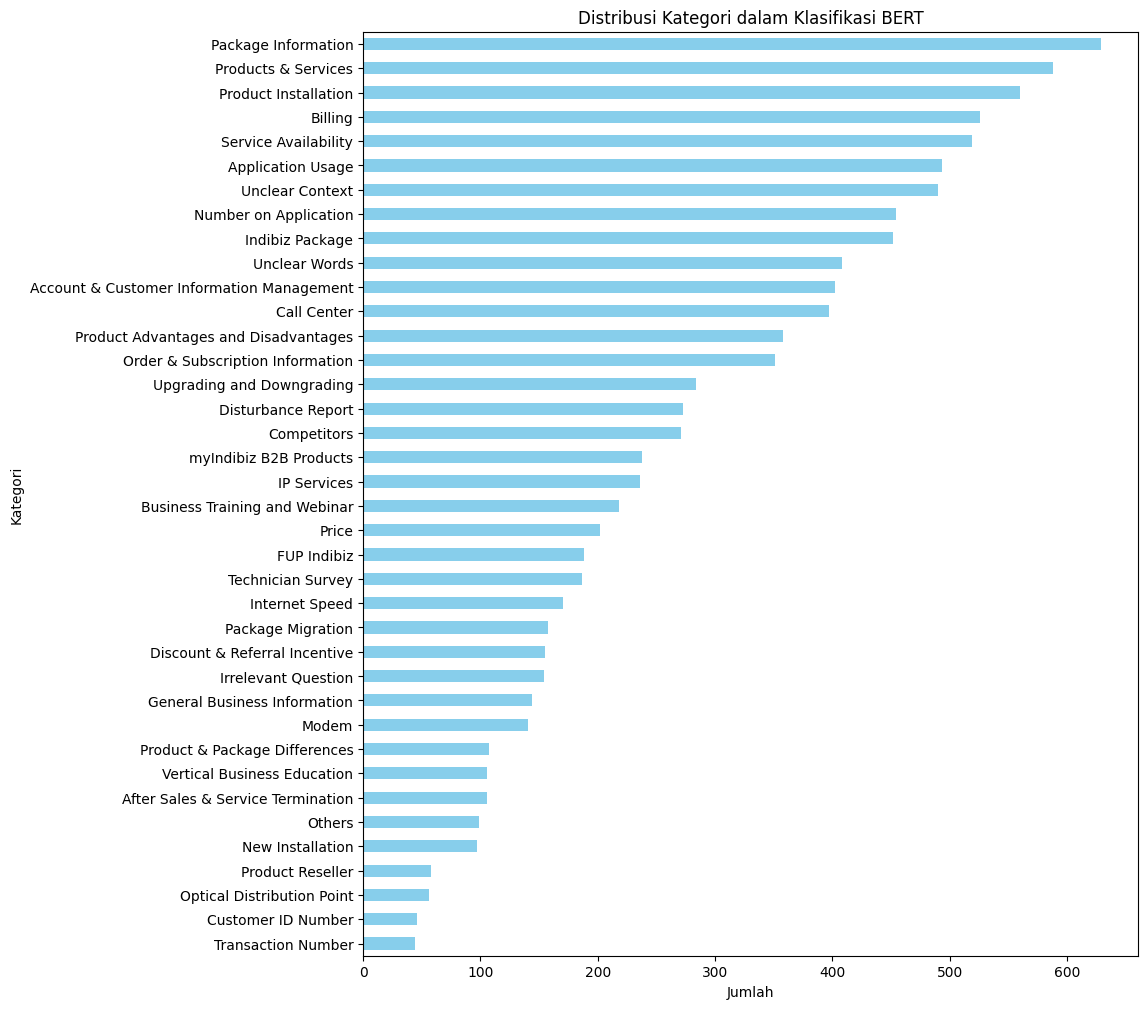

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

df_counts_sorted = df_counts.sort_values(ascending=False)

# Membuat bar chart
plt.figure(figsize=(10, 12))
df_counts_sorted.plot(kind='barh', color='skyblue')
plt.xlabel("Jumlah")
plt.ylabel("Kategori")
plt.title("Distribusi Kategori dalam Klasifikasi BERT")
plt.gca().invert_yaxis()  # Membalik sumbu y untuk menampilkan kategori terbesar di atas
plt.show()

In [57]:
# Buat salinan dari dataframe asli
#df_updated = df.copy()

# Buat mapping untuk mengubah kategori menjadi 'Others' jika nilai kategori di bawah 100
#category_mapping = {category: ('Others' if count < 100 else category) for category, count in df_counts.items()}

# Perbarui kolom 'Klasifikasi BERT' sesuai dengan mapping baru
#df_updated['Klasifikasi BERT'] = df_updated['Klasifikasi BERT'].map(category_mapping)

# Tampilkan beberapa baris dari df_updated untuk memastikan perubahan
#df_updated.head()

In [58]:
#df = df_updated

In [59]:
# Buat dataframe baru hanya dengan kolom 'content' dan 'Klasifikasi BERT'
df_content_klasifikasi = df[['content', 'Klasifikasi BERT']]

# Tampilkan beberapa baris dari df baru untuk memastikan hasilnya
df_content_klasifikasi.head()

,content,Klasifikasi BERT
0,"Maaf, informasi yang diberikan dalam konteks tidak memberikan informasi tentang bisnis yang sedang tren saat ini.",General Business Information
1,"Maaf, saya tidak memiliki informasi tentang kecepatan internet yang ditentukan untuk penggunaan wifi gratis di kafe.",Internet Speed
2,"Maaf, saya tidak memiliki informasi tentang status pendaftaran Anda.",Order & Subscription Information
3,"Maaf, saya tidak memiliki informasi tentang cara pembayaran menggunakan mobil banking BRI.",Billing
4,"Maaf, saya tidak memiliki informasi tentang cara menggabungkan dua akun menjadi satu aplikasi.",Application Usage


In [60]:
df = df_content_klasifikasi

In [61]:
df.rename(columns={'content': 'text', 'Klasifikasi BERT': 'intent'}, inplace=True)
df.head()

,text,intent
0,"Maaf, informasi yang diberikan dalam konteks tidak memberikan informasi tentang bisnis yang sedang tren saat ini.",General Business Information
1,"Maaf, saya tidak memiliki informasi tentang kecepatan internet yang ditentukan untuk penggunaan wifi gratis di kafe.",Internet Speed
2,"Maaf, saya tidak memiliki informasi tentang status pendaftaran Anda.",Order & Subscription Information
3,"Maaf, saya tidak memiliki informasi tentang cara pembayaran menggunakan mobil banking BRI.",Billing
4,"Maaf, saya tidak memiliki informasi tentang cara menggabungkan dua akun menjadi satu aplikasi.",Application Usage


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10365 entries, 0 to 10364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10365 non-null  object
 1   intent  10365 non-null  object
dtypes: object(2)
memory usage: 162.1+ KB


In [63]:
pd.reset_option('display.max_rows')

# Data Preprocessing

In [64]:
df_patterns = df[['text', 'intent']]
#df_responses = df[['responses', 'intent']]
df_patterns.head()

,text,intent
0,"Maaf, informasi yang diberikan dalam konteks tidak memberikan informasi tentang bisnis yang sedang tren saat ini.",General Business Information
1,"Maaf, saya tidak memiliki informasi tentang kecepatan internet yang ditentukan untuk penggunaan wifi gratis di kafe.",Internet Speed
2,"Maaf, saya tidak memiliki informasi tentang status pendaftaran Anda.",Order & Subscription Information
3,"Maaf, saya tidak memiliki informasi tentang cara pembayaran menggunakan mobil banking BRI.",Billing
4,"Maaf, saya tidak memiliki informasi tentang cara menggabungkan dua akun menjadi satu aplikasi.",Application Usage


In [65]:
df_patterns.describe()

,text,intent
count,10365,10365
unique,9909,38
top,"Maaf, saya tidak memiliki informasi yang cukup untuk menjawab pertanyaan Anda.",Package Information
freq,20,629


,text,intent
count,10365,10365
unique,9909,38
top,"Maaf, saya tidak memiliki informasi yang cukup untuk menjawab pertanyaan Anda.",Package Information
freq,20,629


In [66]:
df_patterns.drop_duplicates(inplace= True)

In [67]:
df_patterns.describe()

,text,intent
count,9921,9921
unique,9909,38
top,"Maaf, saat ini saya tidak memiliki informasi lengkap mengenai URL yang dimaksud.",Products & Services
freq,3,585


In [68]:
df_patterns['intent'].value_counts()

intent
Products & Services                          585
Package Information                          563
Product Installation                         516
Billing                                      501
Service Availability                         493
Application Usage                            465
Indibiz Package                              439
Unclear Context                              437
Number on Application                        424
Unclear Words                                400
Call Center                                  390
Account & Customer Information Management    390
Product Advantages and Disadvantages         348
Order & Subscription Information             344
Upgrading and Downgrading                    278
Competitors                                  268
Disturbance Report                           254
IP Services                                  233
myIndibiz B2B Products                       226
Business Training and Webinar                218
Price        

In [69]:
df_patterns.to_csv('df_prepro.csv', index=True)

# Split Data


In [ ]:
from sklearn.model_selection import train_test_split

# Perform a stratified split based on the 'intent' column
df_patterns, test_df = train_test_split(df_patterns, test_size=0.1, stratify=df_patterns['intent'], random_state=42)

# train_df contains 90% of the data with a proportional distribution of intents
# test_df contains 10% of the data with a proportional distribution of intents

In [ ]:
train_df, val_df = train_test_split(df_patterns, test_size=0.1, stratify=df_patterns['intent'], random_state=42)

In [72]:
train_df

,text,intent
9650,"Maaf kak, terkait perbedaan nomor layanan yang ada di aplikasi MyIndiBiz dan nomor internetnya, saat ini tidak ada informasi yang diberikan mengenai perbedaan tersebut.",Product & Package Differences
8321,"Maaf, saat ini saya tidak memiliki informasi mengenai fitur tambahan dari masing-masing paket yang disebutkan dalam konteks.",Products & Services
1375,"Maaf, tidak ada informasi yang disebutkan mengenai masalah kecepatan upload dan download IndiBiz.",Internet Speed
848,"Maaf, saya tidak dapat melihat informasi mengenai status order Anda.",Order & Subscription Information
8070,"Maaf, saya tidak menemukan informasi mengenai cara cek progres pemasangan pada prompt yang diberikan.",Product Installation
...,...,...
550,"Maaf, saat ini saya tidak memiliki informasi mengenai masalah koneksi internet pada modem Anda.",Modem
9578,"Maaf, saat ini saya tidak memiliki informasi tentang nomor telepon yang ingin saya hubungi.",Call Center
9629,"Maaf, saya tidak menemukan informasi mengenai alamat email lain yang dapat dihubungi.",Application Usage
1676,"Maaf, saat ini saya tidak memiliki informasi apakah Anda dapat memesan aplikasi myindibiz sekarang.",Application Usage


In [73]:
real_train_df = train_df

In [74]:
val_df

,text,intent
78,"Maaf, informasi mengenai ""Pak Linson Telkom"" tidak ditemukan dalam konteks yang diberikan.",Others
4605,"Maaf, saya tidak memiliki informasi tentang ""Tanpa fup"".",FUP Indibiz
5139,"Maaf Kak, saat ini saya belum memiliki informasi spesifik mengenai bisnis yang sedang booming di lokasi Anda.",General Business Information
6525,"Maaf, saat ini saya tidak memiliki informasi mengenai paket langganan Indibiz lainnya yang lebih terjangkau untuk pemula selain dari yang telah disebutkan.",Indibiz Package
7018,"Maaf, saya tidak memiliki informasi tentang layanan paket 2P yang kakak maksud.",Products & Services
...,...,...
7695,"Maaf, saya tidak dapat menemukan informasi tentang pemasangan dengan nomor tersebut dalam pengetahuan saya.",Number on Application
9900,"Maaf, saat ini saya tidak memiliki informasi kontak time sales kota Bogor.",Service Availability
2066,"Maaf, saya tidak memiliki informasi tentang cara meningkatkan kecepatan internet Anda.",Upgrading and Downgrading
7879,"Maaf, saya tidak memiliki informasi tentang pemasangan WiFi Anda.",Product Installation


In [75]:
test_df

,text,intent
9987,"Maaf, saya tidak memiliki informasi mengenai cara menghubungi tim Pijar Sekolah untuk mendapatkan panduan mengenai upload NPWP.",Call Center
7115,"Maaf, informasi mengenai cara mengaktifkan Netmonk tidak disebutkan dalam konteks tersebut.",myIndibiz B2B Products
1804,"Maaf, saat ini saya tidak memiliki informasi mengenai alamat Plasa lain yang dapat Anda kunjungi untuk pengajuan refund pph 23.",Service Availability
6119,"Mohon maaf, saat ini saya tidak memiliki informasi mengenai paket dan harga Pijar Sekolah.",Package Information
5347,mohon maaf saya tidak memiliki akses ke informasi teknis terkini.,Account & Customer Information Management
...,...,...
6293,"Maaf, saat ini saya tidak memiliki informasi tentang paket Indibiz yang Anda berlangganan.",Unclear Context
223,"Maaf, saya tidak memiliki informasi mengenai pembelian FUP pada layanan IndiBiz.",FUP Indibiz
3132,"Maaf, saya tidak memiliki informasi mengenai kecepatan internet minimal untuk layanan Indibiz.",Internet Speed
10270,"Maaf Kak, saya tidak memiliki akses langsung ke informasi terkait jaringan Indibiz di Wisma 77 Tower 1.",Account & Customer Information Management


In [76]:
df_patterns

,text,intent
5202,"Maaf, saat ini saya tidak memiliki informasi mengenai metode pembayaran lain yang dapat digunakan untuk membayar biaya pemasangan.",Billing
3426,"Maaf, saya tidak menemukan informasi terkait layanan pelatihan bisnis yang ditawarkan oleh Indibiz khusus untuk praktek dokter atau bidan dalam konteks ini.",Business Training and Webinar
9078,"Maaf, saya tidak dapat memberikan URL lengkap karena informasi yang diberikan dalam konteks tidak menyertakan URL yang spesifik.",Indibiz Package
4079,"Maaf, saya tidak memiliki informasi tentang langganan Anda karena saya hanya memiliki pengetahuan dari konteks di atas tentang produk dan solusi dari MyIndibiz.",Product Advantages and Disadvantages
1065,"Maaf, saat ini saya tidak memiliki informasi yang spesifik mengenai cara membuat bisnis baru.",General Business Information
...,...,...
2937,"Maaf, saya tidak dapat memberikan informasi tentang perbandingan antara HSI B2B INET dan BASIC.",Product & Package Differences
10161,"Maaf, saya tidak dapat mengecek no layanan 111447100683 apakah tergolong bisnis tanpa batas FUP karena informasi yang tersedia dalam konteks saya adalah hanya informasi tentang fitur dan produk MyIndibiz.",FUP Indibiz
1522,"Maaf, saat ini saya tidak memiliki informasi apakah Anda bisa melakukan upgrade paket.",Upgrading and Downgrading
6863,"Maaf, saya tidak memiliki informasi mengenai paket internet langganan Indibiz Anda.",Unclear Context


In [77]:
df_patterns.describe()

,text,intent
count,8928,8928
unique,8918,38
top,"Maaf, saat ini saya tidak memiliki informasi lengkap mengenai URL yang dimaksud.",Products & Services
freq,3,526


In [78]:
test_df.describe()

,text,intent
count,993,993
unique,993,38
top,"Maaf, saat ini saya tidak memiliki informasi mengenai batasan penggunaan data dalam layanan IndiBiz.",Products & Services
freq,1,59


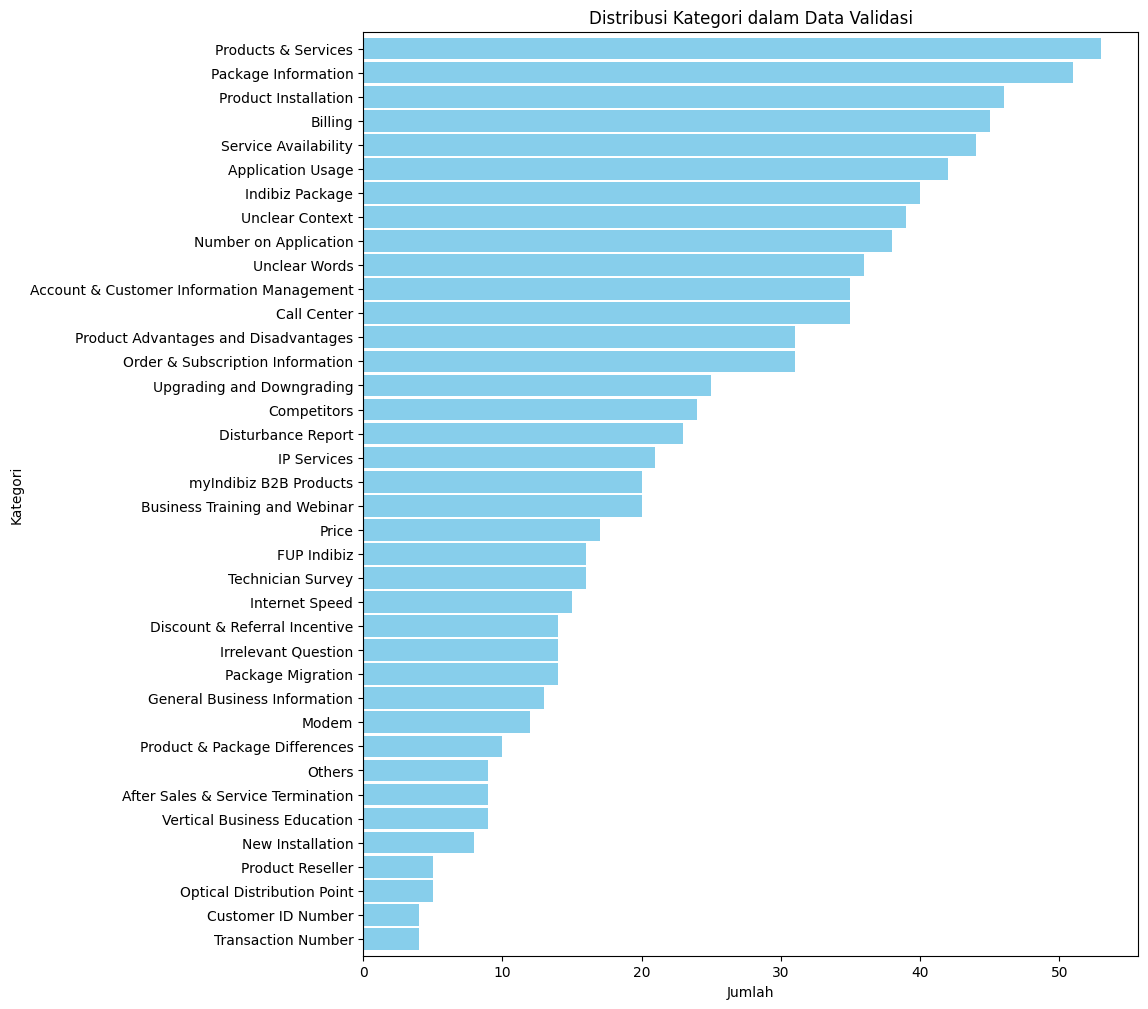

In [79]:
import pandas as pd
import matplotlib.pyplot as plt

df_counts_val = val_df['intent'].value_counts()
df_counts_val_sorted = df_counts_val.sort_values(ascending=False)

# Membuat bar chart
plt.figure(figsize=(10, 12))
df_counts_val_sorted.plot(kind='barh', color='skyblue', width = 0.9)
plt.xlabel("Jumlah")
plt.ylabel("Kategori")
plt.title("Distribusi Kategori dalam Data Validasi")
plt.gca().invert_yaxis()  # Membalik sumbu y untuk menampilkan kategori terbesar di atas
plt.savefig('val set.png')
plt.show()

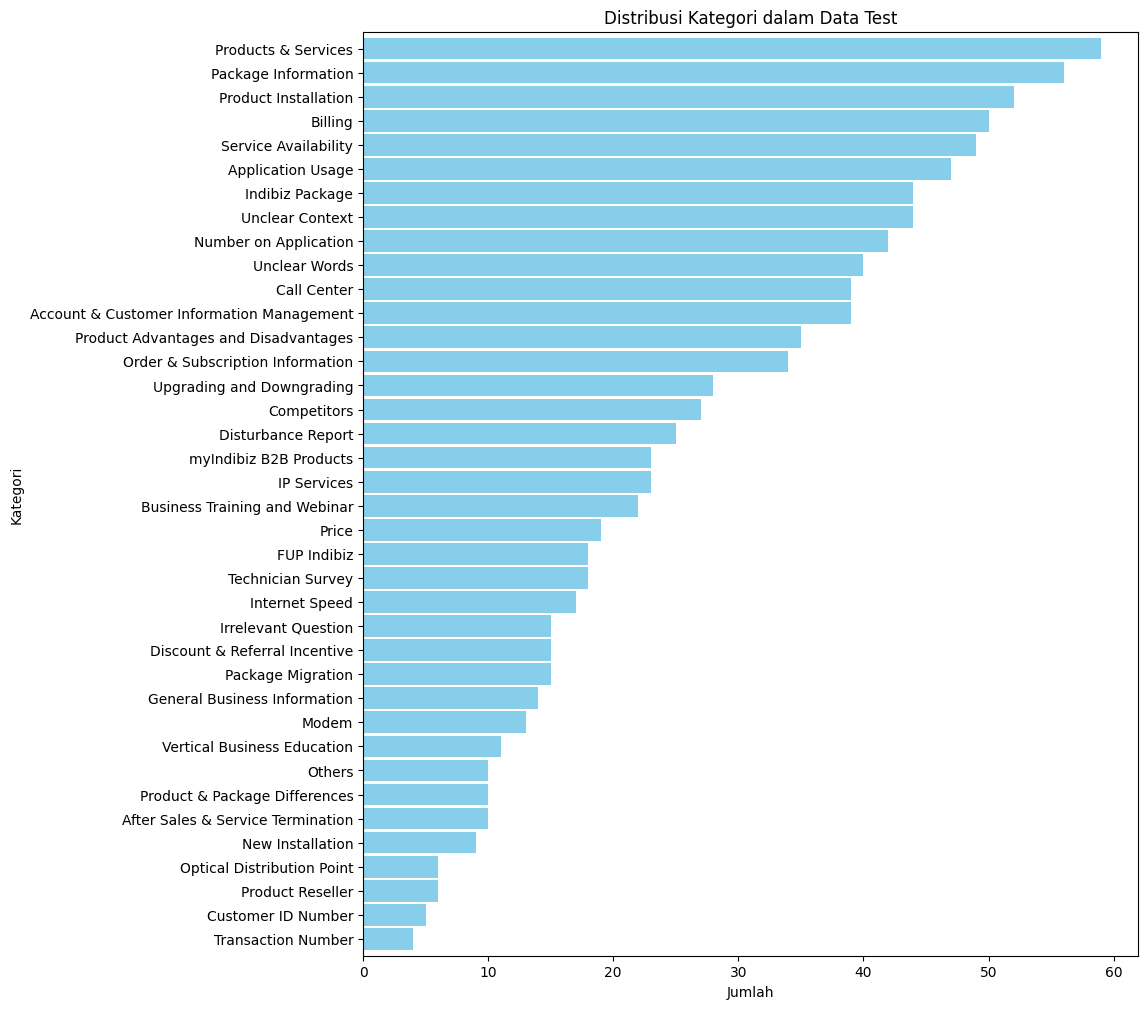

In [80]:
import pandas as pd
import matplotlib.pyplot as plt

df_counts_test = test_df['intent'].value_counts()
df_counts_test_sorted = df_counts_test.sort_values(ascending=False)

# Membuat bar chart
plt.figure(figsize=(10, 12))
df_counts_test_sorted.plot(kind='barh', color='skyblue', width = 0.9)
plt.xlabel("Jumlah")
plt.ylabel("Kategori")
plt.title("Distribusi Kategori dalam Data Test")
plt.gca().invert_yaxis()  # Membalik sumbu y untuk menampilkan kategori terbesar di atas
plt.savefig('test set.png')
plt.show()

# Augmentation Data

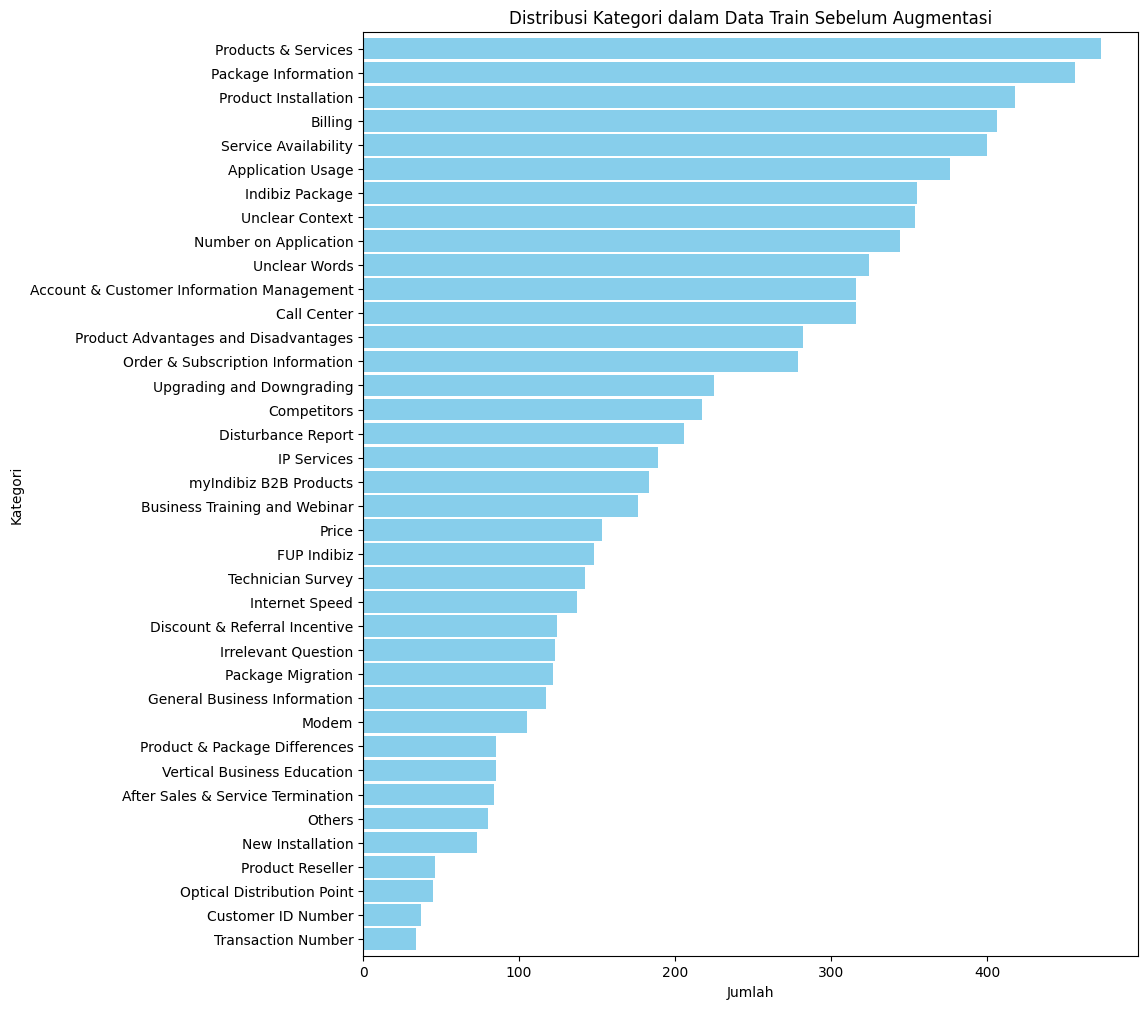

In [81]:
import pandas as pd
import matplotlib.pyplot as plt

df_counts_train = train_df['intent'].value_counts()
df_counts_train_sorted = df_counts_train.sort_values(ascending=False)

# Membuat bar chart
plt.figure(figsize=(10, 12))
df_counts_train_sorted.plot(kind='barh', color='skyblue', width = 0.9)
plt.xlabel("Jumlah")
plt.ylabel("Kategori")
plt.title("Distribusi Kategori dalam Data Train Sebelum Augmentasi")
plt.gca().invert_yaxis()  # Membalik sumbu y untuk menampilkan kategori terbesar di atas
plt.savefig('train set no augment.png')
plt.show()

In [82]:
df_counts_train_sorted

intent
Products & Services                          473
Package Information                          456
Product Installation                         418
Billing                                      406
Service Availability                         400
Application Usage                            376
Indibiz Package                              355
Unclear Context                              354
Number on Application                        344
Unclear Words                                324
Account & Customer Information Management    316
Call Center                                  316
Product Advantages and Disadvantages         282
Order & Subscription Information             279
Upgrading and Downgrading                    225
Competitors                                  217
Disturbance Report                           206
IP Services                                  189
myIndibiz B2B Products                       183
Business Training and Webinar                176
Price        

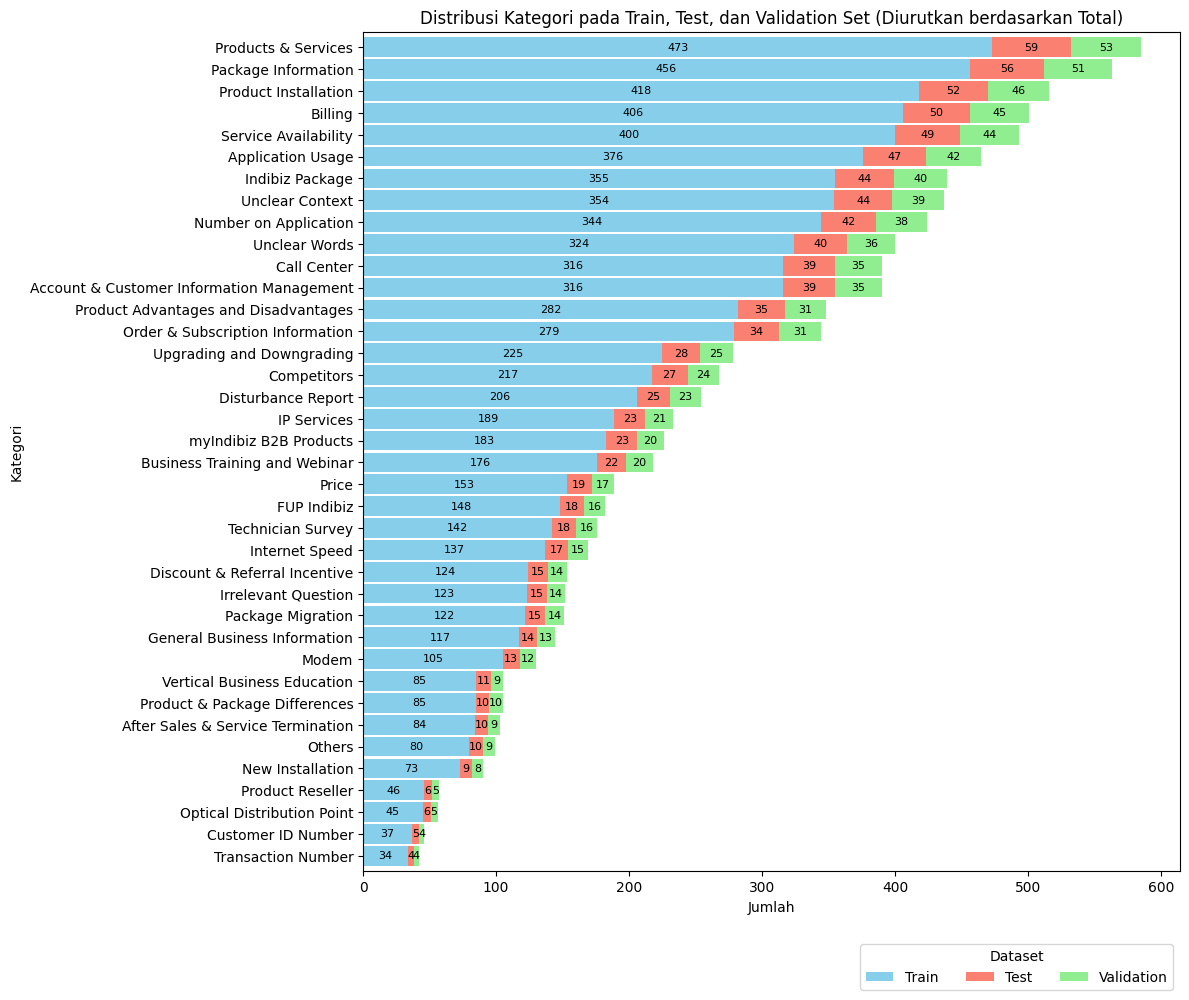

In [83]:
# Gabungkan ke dalam satu DataFrame tanpa validasi
df_combined = pd.DataFrame({
    'Train': df_counts_train_sorted,
    'Test': df_counts_test_sorted,
    'Validation': df_counts_val_sorted  # Tambahkan kolom validasi
})

# Hitung total distribusi dan urutkan berdasarkan total tersebut
df_combined['Total'] = df_combined.sum(axis=1)
df_combined_sorted = df_combined.sort_values('Total', ascending=True).drop(columns='Total')

# Membuat stacked horizontal bar chart
fig, ax = plt.subplots(figsize=(12, 10))
bars = df_combined_sorted.plot(kind='barh', stacked=True, ax=ax, color=['skyblue', 'salmon', 'lightgreen'], width=0.9)

plt.ylabel("Kategori")
plt.xlabel("Jumlah")
plt.title("Distribusi Kategori pada Train, Test, dan Validation Set (Diurutkan berdasarkan Total)")

# Menambahkan label pada setiap bar
for i, (index, row) in enumerate(df_combined_sorted.iterrows()):
    left = 0  # Posisi awal label
    for dataset, color in zip(['Train', 'Test', 'Validation'], ['skyblue', 'salmon', 'lightgreen']):
        value = row[dataset]
        if value > 0:
            ax.text(left + value / 2, i, int(value), va='center', ha='center', fontsize=8, color='black')
            left += value

# Mengatur posisi legend di bawah kanan
plt.legend(title="Dataset", loc='lower right', bbox_to_anchor=(1, -0.15), ncol=3)  # Sesuaikan ncol menjadi 3

plt.tight_layout()
plt.savefig('distribusi_train_test_validation.png')
plt.show()

In [84]:
# Menyimpan DataFrame ke file CSV
df_combined_sorted.to_csv('distribusi_train_test.csv', index=True)

# Menampilkan DataFrame hasilnya
df_combined_sorted

,Train,Test,Validation
intent,,,
Transaction Number,34,4,4
Customer ID Number,37,5,4
Optical Distribution Point,45,6,5
Product Reseller,46,6,5
New Installation,73,9,8
Others,80,10,9
After Sales & Service Termination,84,10,9
Product & Package Differences,85,10,10
Vertical Business Education,85,11,9


In [85]:
!yes | unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [86]:
'''import random
import nltk
from nltk.corpus import wordnet
import pandas as pd

# Pastikan nltk wordnet sudah diunduh
nltk.download('wordnet')

# Fungsi untuk mengganti kata dengan sinonimnya
def synonym_replacement(text, n=2):
    words = text.split()
    new_words = words.copy()
    random_word_list = list(set([word for word in words if wordnet.synsets(word)]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = wordnet.synsets(random_word)
        if len(synonyms) >= 1:
            synonym = synonyms[0].lemmas()[0].name()
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break

    sentence = ' '.join(new_words)
    return sentence

# Fungsi augmentasi
def augment_text(text):
    augmented_texts = []
    # Teknik augmentasi 1: sinonim penggantian
    augmented_texts.append(synonym_replacement(text))
    # Teknik augmentasi 2: back translation (di sini simulasi sederhana)
    augmented_texts.append(text[::-1])  # Ini sebagai contoh sederhana saja

    return augmented_texts

# Langkah 1: Hapus baris dengan nilai None atau kosong di kolom 'text'
train_df = train_df[train_df['text'].notna() & (train_df['text'] != '')]

# Langkah 2: Hitung frekuensi setiap kategori
category_counts = train_df['intent'].value_counts()
total_count = len(train_df)

# Langkah 3: Hitung bobot untuk setiap kategori (semakin kecil frekuensi, semakin tinggi bobot)
weights = {category: total_count / count for category, count in category_counts.items()}
max_weight = max(weights.values())

# Langkah 4: Tentukan jumlah augmentasi berdasarkan bobot
num_augmentations = {category: int((weight / max_weight) * 10) for category, weight in weights.items()}

# Langkah 5: Lakukan augmentasi untuk setiap kategori sesuai jumlah augmentasi yang ditentukan
augmented_texts = []
augmented_labels = []
for text, label in zip(train_df['text'], train_df['intent']):
    if label in num_augmentations and num_augmentations[label] > 0:
        augment_count = num_augmentations[label]
        augmented_versions = augment_text(text)
        # Tambahkan augmentasi sesuai jumlah yang ditentukan
        for _ in range(augment_count):
            augmented_texts.extend(augmented_versions)
            augmented_labels.extend([label] * len(augmented_versions))

# Gabungkan data asli dan augmented
df_augmented = pd.DataFrame({'text': augmented_texts, 'intent': augmented_labels})
train_df = pd.concat([train_df, df_augmented], ignore_index=True)  # Pastikan index ter-reset

# Hapus duplikasi setelah augmentasi
train_df.drop_duplicates(inplace=True)

# Menampilkan informasi tentang ukuran data setelah augmentasi
print(f"Size of training data after augmentation: {len(train_df)}")'''

'import random\nimport nltk\nfrom nltk.corpus import wordnet\nimport pandas as pd\n\n# Pastikan nltk wordnet sudah diunduh\nnltk.download(\'wordnet\')\n\n# Fungsi untuk mengganti kata dengan sinonimnya\ndef synonym_replacement(text, n=2):\n    words = text.split()\n    new_words = words.copy()\n    random_word_list = list(set([word for word in words if wordnet.synsets(word)]))\n    random.shuffle(random_word_list)\n    num_replaced = 0\n    for random_word in random_word_list:\n        synonyms = wordnet.synsets(random_word)\n        if len(synonyms) >= 1:\n            synonym = synonyms[0].lemmas()[0].name()\n            new_words = [synonym if word == random_word else word for word in new_words]\n            num_replaced += 1\n        if num_replaced >= n:\n            break\n\n    sentence = \' \'.join(new_words)\n    return sentence\n\n# Fungsi augmentasi\ndef augment_text(text):\n    augmented_texts = []\n    # Teknik augmentasi 1: sinonim penggantian\n    augmented_texts.append(s

In [87]:
#import torch
#torch.cuda.empty_cache()
#torch.cuda.reset_peak_memory_stats()

In [88]:
#import os
#os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [89]:
# Hitung jumlah sampel per kelas (intent)
intent_counts = train_df['intent'].value_counts()

# Tentukan jumlah sampel pada kelas mayoritas
majority_class_count = intent_counts.max()

# Hitung Imbalance Ratio untuk setiap kelas
IR = majority_class_count / intent_counts

# Tampilkan hasil Imbalance Ratio
print(IR)

intent
Products & Services                           1.000000
Package Information                           1.037281
Product Installation                          1.131579
Billing                                       1.165025
Service Availability                          1.182500
Application Usage                             1.257979
Indibiz Package                               1.332394
Unclear Context                               1.336158
Number on Application                         1.375000
Unclear Words                                 1.459877
Account & Customer Information Management     1.496835
Call Center                                   1.496835
Product Advantages and Disadvantages          1.677305
Order & Subscription Information              1.695341
Upgrading and Downgrading                     2.102222
Competitors                                   2.179724
Disturbance Report                            2.296117
IP Services                                   2.502646
myI

In [90]:
#import os
#os.kill(os.getpid(), 9)

In [91]:
# Hitung frekuensi tiap kategori
category_counts = train_df['intent'].value_counts()

# Temukan jumlah data dari kelas mayoritas
majority_class_count = category_counts.max()

# Hitung IR untuk setiap kategori
category_ir = {category: majority_class_count / count for category, count in category_counts.items()}

# Menampilkan IR untuk setiap kategori
print(category_ir)


{'Products & Services': 1.0, 'Package Information': 1.037280701754386, 'Product Installation': 1.131578947368421, 'Billing': 1.1650246305418719, 'Service Availability': 1.1825, 'Application Usage': 1.2579787234042554, 'Indibiz Package': 1.332394366197183, 'Unclear Context': 1.3361581920903955, 'Number on Application': 1.375, 'Unclear Words': 1.4598765432098766, 'Account & Customer Information Management': 1.4968354430379747, 'Call Center': 1.4968354430379747, 'Product Advantages and Disadvantages': 1.677304964539007, 'Order & Subscription Information': 1.6953405017921146, 'Upgrading and Downgrading': 2.102222222222222, 'Competitors': 2.1797235023041477, 'Disturbance Report': 2.296116504854369, 'IP Services': 2.502645502645503, 'myIndibiz B2B Products': 2.5846994535519126, 'Business Training and Webinar': 2.6875, 'Price': 3.0915032679738563, 'FUP Indibiz': 3.195945945945946, 'Technician Survey': 3.3309859154929575, 'Internet Speed': 3.4525547445255476, 'Discount & Referral Incentive': 3

In [92]:
'''from transformers import pipeline
from tqdm import tqdm
import pandas as pd

# Atur device: 0 untuk GPU, -1 untuk CPU
device = 0  # Ganti -1 jika ingin menggunakan CPU

# Pipeline terjemahan
id_to_en = pipeline("translation", model="Helsinki-NLP/opus-mt-id-en", device=device, batch_size=2, torch_dtype="float16")
en_to_id = pipeline("translation", model="Helsinki-NLP/opus-mt-en-id", device=device, batch_size=2, torch_dtype="float16")

# Fungsi untuk back translation
def back_translate(texts, id_to_en, en_to_id):
    augmented_texts = []
    for text in texts:
        try:
            # Terjemahkan Indonesia -> Inggris
            translated_to_en = id_to_en(text, max_length=512)[0]['translation_text']
            # Terjemahkan kembali Inggris -> Indonesia
            back_translated = en_to_id(translated_to_en, max_length=512)[0]['translation_text']
            augmented_texts.append(back_translated)
        except Exception as e:
            print(f"Error during back translation: {e}")
            augmented_texts.append(text)  # Jika error, gunakan teks asli
    return augmented_texts

# Hitung frekuensi tiap kategori
category_counts = train_df['intent'].value_counts()
total_count = len(train_df)

# Tentukan jumlah augmentasi berdasarkan IR (semakin besar IR, semakin banyak augmentasi)
max_ir = max(category_ir.values())
num_augmentations = {category: int((ir / max_ir) * 5) for category, ir in category_ir.items()}

# Proses back translation dengan progress bar
back_translated_texts = []
back_translated_labels = []

with tqdm(total=len(train_df), desc="Back Translating Data", unit="example") as pbar:
    for text, label in zip(train_df['text'], train_df['intent']):
        augment_count = num_augmentations[label]
        # Lakukan back translation sesuai jumlah augmentasi
        back_versions = back_translate([text] * augment_count, id_to_en, en_to_id)
        
        back_translated_texts.extend(back_versions)
        back_translated_labels.extend([label] * len(back_versions))
        
        pbar.update(1)

# Simpan hasil back translation ke DataFrame
df_back_translated = pd.DataFrame({'text': back_translated_texts, 'intent': back_translated_labels})

# Opsional: Simpan ke file CSV agar aman sebelum paraphrasing
df_back_translated.to_csv('/mnt/data/back_translated_data.csv', index=False)

print(f"Back translation selesai. Total data: {len(df_back_translated)}")
print(df_back_translated.sample(5))'''

'from transformers import pipeline\nfrom tqdm import tqdm\nimport pandas as pd\n\n# Atur device: 0 untuk GPU, -1 untuk CPU\ndevice = 0  # Ganti -1 jika ingin menggunakan CPU\n\n# Pipeline terjemahan\nid_to_en = pipeline("translation", model="Helsinki-NLP/opus-mt-id-en", device=device, batch_size=2, torch_dtype="float16")\nen_to_id = pipeline("translation", model="Helsinki-NLP/opus-mt-en-id", device=device, batch_size=2, torch_dtype="float16")\n\n# Fungsi untuk back translation\ndef back_translate(texts, id_to_en, en_to_id):\n    augmented_texts = []\n    for text in texts:\n        try:\n            # Terjemahkan Indonesia -> Inggris\n            translated_to_en = id_to_en(text, max_length=512)[0][\'translation_text\']\n            # Terjemahkan kembali Inggris -> Indonesia\n            back_translated = en_to_id(translated_to_en, max_length=512)[0][\'translation_text\']\n            augmented_texts.append(back_translated)\n        except Exception as e:\n            print(f"Error dur

In [93]:
#train_df = pd.read_csv('/kaggle/input/train-augmented-huggingface/train augment.csv')
#train_df

In [94]:
#from transformers import pipeline
#from accelerate import Accelerator

# Optimasi dengan Accelerator
#accelerator = Accelerator()
#device = accelerator.device

In [95]:
'''import pandas as pd

# Data kategori dan jumlah
data = {
    'intent': [
        'Products & Services', 'Product Installation', 'Service Availability', 'Package Information', 'Billing', 
        'Unclear Context', 'Application Usage', 'Indibiz Package', 'Number on Application', 'Technician Survey', 
        'Call Center', 'Package Migration', 'Price', 'Irrelevant Question', 'Competitors', 
        'Account & Customer Information Management', 'Order & Subscription Information', 'Internet Speed', 'FUP Indibiz', 
        'Discount & Referral Incentive', 'Unclear Words', 'General Business Information', 'Product Advantages and Disadvantages', 
        'Disturbance Report', 'Upgrading and Downgrading', 'Modem', 'IP Services', 'Others', 
        'Vertical Business Education', 'Business Training and Webinar', 'myIndibiz B2B Products', 'Product & Package Differences', 
        'After Sales & Service Termination', 'New Installation', 'Product Reseller', 'Optical Distribution Point', 
        'Customer ID Number', 'Transaction Number'
    ],
    'count': [
        382, 344, 335, 331, 316, 290, 284, 263, 258, 253, 241, 228, 227, 223, 219, 204, 203, 198, 191, 188, 187, 182, 
        182, 175, 170, 165, 153, 144, 140, 136, 135, 133, 132, 123, 76, 74, 60, 55
    ]
}

# Membuat DataFrame
df_paraphrased = pd.DataFrame(data)

# Menampilkan tabel
df_paraphrased.to_csv('/kaggle/working/df paraphrased.csv')'''


"import pandas as pd\n\n# Data kategori dan jumlah\ndata = {\n    'intent': [\n        'Products & Services', 'Product Installation', 'Service Availability', 'Package Information', 'Billing', \n        'Unclear Context', 'Application Usage', 'Indibiz Package', 'Number on Application', 'Technician Survey', \n        'Call Center', 'Package Migration', 'Price', 'Irrelevant Question', 'Competitors', \n        'Account & Customer Information Management', 'Order & Subscription Information', 'Internet Speed', 'FUP Indibiz', \n        'Discount & Referral Incentive', 'Unclear Words', 'General Business Information', 'Product Advantages and Disadvantages', \n        'Disturbance Report', 'Upgrading and Downgrading', 'Modem', 'IP Services', 'Others', \n        'Vertical Business Education', 'Business Training and Webinar', 'myIndibiz B2B Products', 'Product & Package Differences', \n        'After Sales & Service Termination', 'New Installation', 'Product Reseller', 'Optical Distribution Point',

In [96]:
import pandas as pd
import math

# Hitung frekuensi tiap kategori
category_counts = train_df['intent'].value_counts()
majority_class_count = category_counts.max()

# Hitung IR (Imbalance Ratio)
category_ir = {category: majority_class_count / count for category, count in category_counts.items()}

# Hitung jumlah augmentasi yang dibutuhkan per kategori
augmentations_per_category = {
    category: max(math.ceil((ir - 1) * count), 0)  # Tambahan data = (IR - 1) * jumlah data asli
    for category, (ir, count) in zip(category_ir.keys(), zip(category_ir.values(), category_counts))
}

# Tampilkan jumlah augmentasi per kategori
augmentations_df = pd.DataFrame({
    'Jumlah Data Asli': category_counts,
    'IR': category_ir.values(),
    'Jumlah Augmentasi': augmentations_per_category.values()
}).sort_values(by='Jumlah Augmentasi', ascending=False)

# Tambahkan kolom 'Total Data' (Jumlah Data Asli + Jumlah Augmentasi)
augmentations_df['Total Data'] = augmentations_df['Jumlah Data Asli'] + augmentations_df['Jumlah Augmentasi']

# Simpan hasil ke file CSV
augmentations_df.to_csv('/kaggle/working/jumlah_augmentasi_dan_total.csv', index=False)

# Menampilkan hasil untuk memastikan kolom baru telah ditambahkan
augmentations_df


,Jumlah Data Asli,IR,Jumlah Augmentasi,Total Data
intent,,,,
Transaction Number,34,13.911765,439,473
Customer ID Number,37,12.783784,436,473
Optical Distribution Point,45,10.511111,428,473
Product Reseller,46,10.282609,427,473
New Installation,73,6.479452,400,473
Others,80,5.912500,393,473
After Sales & Service Termination,84,5.630952,390,474
Product & Package Differences,85,5.564706,388,473
Vertical Business Education,85,5.564706,388,473


In [97]:
augmentations_df

,Jumlah Data Asli,IR,Jumlah Augmentasi,Total Data
intent,,,,
Transaction Number,34,13.911765,439,473
Customer ID Number,37,12.783784,436,473
Optical Distribution Point,45,10.511111,428,473
Product Reseller,46,10.282609,427,473
New Installation,73,6.479452,400,473
Others,80,5.912500,393,473
After Sales & Service Termination,84,5.630952,390,474
Product & Package Differences,85,5.564706,388,473
Vertical Business Education,85,5.564706,388,473


In [98]:
'''import math
import torch
from transformers import pipeline
import pandas as pd
from tqdm import tqdm

# Force GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Inisialisasi paraphraser dengan IndoT5
paraphraser = pipeline(
    "text2text-generation", 
    model="Wikidepia/IndoT5-base-paraphrase", 
    device=0 if device.type == 'cuda' else -1  # Force GPU jika tersedia
)

# Pindahkan model ke GPU
if device.type == 'cuda':
    paraphraser.model.to(device)

# Fungsi untuk menentukan jumlah paraphrase berdasarkan IR (Imbalance Ratio)
def determine_paraphrase_count(ir_value, max_augment=5):
    return min(math.ceil(ir_value), max_augment)

# Fungsi untuk parafrase dengan handling duplikasi
def paraphrase_text(text, paraphraser, num_variations=2):
    paraphrased_texts = set()  # Gunakan set untuk hindari duplikasi
    attempts = 0  # Batas percobaan

    while len(paraphrased_texts) < num_variations and attempts < num_variations * 2:
        try:
            paraphrased = paraphraser(
                text,
                max_length=512,
                num_return_sequences=1,
                num_beams=5,             # Beam search lebih rendah untuk variasi
                temperature=1.8,         # Lebih tinggi untuk kreativitas
                top_k=100,               # Sampling lebih bebas
                top_p=0.9,               # Lebih variatif
                repetition_penalty=2.0   # Menghindari pengulangan
            )[0]['generated_text']

            if paraphrased != text and paraphrased not in paraphrased_texts:
                paraphrased_texts.add(paraphrased)
        except Exception as e:
            print(f"Error during paraphrasing: {e}")

        attempts += 1

    return list(paraphrased_texts)

# Fungsi untuk mengecek jumlah kata minimal
def is_valid_text(text, min_words=3):
    return len(text.split()) >= min_words

# Proses paraphrasing
paraphrased_texts = []
paraphrased_labels = []

with tqdm(total=len(train_df), desc="Paraphrasing Data", unit="example") as pbar:
    for text, label in zip(train_df['text'], train_df['intent']):
        if not is_valid_text(text):
            pbar.update(1)
            continue  # Lewati jika kurang dari 3 kata

        # Tentukan jumlah paraphrase berdasarkan IR
        ir_value = category_ir.get(label, 1)
        num_paraphrases = determine_paraphrase_count(ir_value)

        # Proses paraphrase
        paraphrased_versions = paraphrase_text(text, paraphraser, num_variations=num_paraphrases)

        # Simpan hasil dan print
        for p_text in paraphrased_versions:
            print(f"Original Text: {text}")
            print(f"Generated Paraphrase: {p_text}")
            print(f"Intent: {label}")
            print("-" * 50)

        paraphrased_texts.extend(paraphrased_versions)
        paraphrased_labels.extend([label] * len(paraphrased_versions))

        # Update progress bar
        pbar.update(1)

        # Optimasi penggunaan GPU
        if device.type == 'cuda':
            torch.cuda.empty_cache()

# Gabungkan data hasil augmentasi
df_paraphrased = pd.DataFrame({'text': paraphrased_texts, 'intent': paraphrased_labels})

# Gabungkan dengan data asli dan hapus duplikasi
final_df = pd.concat([train_df, df_paraphrased], ignore_index=True).drop_duplicates()

print(f"Jumlah data setelah augmentasi: {len(final_df)}")'''

'import math\nimport torch\nfrom transformers import pipeline\nimport pandas as pd\nfrom tqdm import tqdm\n\n# Force GPU\ndevice = torch.device(\'cuda\' if torch.cuda.is_available() else \'cpu\')\nprint(f"Using device: {device}")\n\n# Inisialisasi paraphraser dengan IndoT5\nparaphraser = pipeline(\n    "text2text-generation", \n    model="Wikidepia/IndoT5-base-paraphrase", \n    device=0 if device.type == \'cuda\' else -1  # Force GPU jika tersedia\n)\n\n# Pindahkan model ke GPU\nif device.type == \'cuda\':\n    paraphraser.model.to(device)\n\n# Fungsi untuk menentukan jumlah paraphrase berdasarkan IR (Imbalance Ratio)\ndef determine_paraphrase_count(ir_value, max_augment=5):\n    return min(math.ceil(ir_value), max_augment)\n\n# Fungsi untuk parafrase dengan handling duplikasi\ndef paraphrase_text(text, paraphraser, num_variations=2):\n    paraphrased_texts = set()  # Gunakan set untuk hindari duplikasi\n    attempts = 0  # Batas percobaan\n\n    while len(paraphrased_texts) < num_var

In [99]:
'''import pandas as pd

# Ambil 5 contoh data asli dari train_df
original_samples = train_df[['text', 'intent']].head(5)

# Ambil 5 contoh data yang telah diaugmentasi
augmented_samples = pd.DataFrame({
    'text': augmented_texts[:5],  # Ambil 5 data pertama setelah augmentasi
    'intent': augmented_labels[:5]
})

# Gabungkan data asli dan data augmentasi
comparison_df = pd.DataFrame({
    'Original Text': original_samples['text'],
    'Original Intent': original_samples['intent'],
    'Augmented Text': augmented_samples['text'],
    'Augmented Intent': augmented_samples['intent']
})

# Menampilkan tabel perbandingan
comparison_df'''

"import pandas as pd\n\n# Ambil 5 contoh data asli dari train_df\noriginal_samples = train_df[['text', 'intent']].head(5)\n\n# Ambil 5 contoh data yang telah diaugmentasi\naugmented_samples = pd.DataFrame({\n    'text': augmented_texts[:5],  # Ambil 5 data pertama setelah augmentasi\n    'intent': augmented_labels[:5]\n})\n\n# Gabungkan data asli dan data augmentasi\ncomparison_df = pd.DataFrame({\n    'Original Text': original_samples['text'],\n    'Original Intent': original_samples['intent'],\n    'Augmented Text': augmented_samples['text'],\n    'Augmented Intent': augmented_samples['intent']\n})\n\n# Menampilkan tabel perbandingan\ncomparison_df"

In [100]:
#final_df = pd.concat([train_df, df_paraphrased], ignore_index=True).drop_duplicates()
#train_df = final_df

In [101]:
'''df_paraphrased['intent'].value_counts()'''

"df_paraphrased['intent'].value_counts()"

In [102]:
#train_df.to_csv('train augment.csv', index=False)

In [103]:
#train_df['intent'].value_counts()

In [104]:
#len(train_df)

## Import Augmented Data (Huggingface)

In [105]:
#train_df = pd.read_csv('/kaggle/input/train-augmented-paraphrased/Train Augment With Validation Split.csv')
train_df

,text,intent
9650,"Maaf kak, terkait perbedaan nomor layanan yang ada di aplikasi MyIndiBiz dan nomor internetnya, saat ini tidak ada informasi yang diberikan mengenai perbedaan tersebut.",Product & Package Differences
8321,"Maaf, saat ini saya tidak memiliki informasi mengenai fitur tambahan dari masing-masing paket yang disebutkan dalam konteks.",Products & Services
1375,"Maaf, tidak ada informasi yang disebutkan mengenai masalah kecepatan upload dan download IndiBiz.",Internet Speed
848,"Maaf, saya tidak dapat melihat informasi mengenai status order Anda.",Order & Subscription Information
8070,"Maaf, saya tidak menemukan informasi mengenai cara cek progres pemasangan pada prompt yang diberikan.",Product Installation
...,...,...
550,"Maaf, saat ini saya tidak memiliki informasi mengenai masalah koneksi internet pada modem Anda.",Modem
9578,"Maaf, saat ini saya tidak memiliki informasi tentang nomor telepon yang ingin saya hubungi.",Call Center
9629,"Maaf, saya tidak menemukan informasi mengenai alamat email lain yang dapat dihubungi.",Application Usage
1676,"Maaf, saat ini saya tidak memiliki informasi apakah Anda dapat memesan aplikasi myindibiz sekarang.",Application Usage


In [106]:
len(train_df)

8035

In [107]:
df_counts_train_augment = train_df['intent'].value_counts()
df_counts_train_augment_sorted = df_counts_train_augment.sort_values(ascending=False)
df_counts_train_augment_sorted

intent
Products & Services                          473
Package Information                          456
Product Installation                         418
Billing                                      406
Service Availability                         400
Application Usage                            376
Indibiz Package                              355
Unclear Context                              354
Number on Application                        344
Unclear Words                                324
Account & Customer Information Management    316
Call Center                                  316
Product Advantages and Disadvantages         282
Order & Subscription Information             279
Upgrading and Downgrading                    225
Competitors                                  217
Disturbance Report                           206
IP Services                                  189
myIndibiz B2B Products                       183
Business Training and Webinar                176
Price        

In [108]:
import pandas as pd

# Fungsi untuk memastikan tidak ada duplikat antara real_train_df dan train_df
def remove_duplicates(df1, df2):
    return df2[~df2['text'].isin(df1['text'])]

# Fungsi untuk sampling data sesuai dengan target_count
def sample_data_per_category(df, real_train_df, target_count):
    sampled_df_list = []

    for category, count in df['intent'].value_counts().items():
        real_category_data = real_train_df[real_train_df['intent'] == category]
        if count >= target_count:
            # Jika jumlah data kategori lebih dari atau sama dengan target, ambil semua data kategori tersebut
            sampled_df_list.append(real_category_data)
        else:
            # Jika jumlah data kategori kurang dari target, ambil semua data kategori tersebut dan tambahkan data random
            additional_data_needed = target_count - len(real_category_data)
            random_data = df[df['intent'] == category]
            random_data_filtered = remove_duplicates(real_category_data, random_data)
            
            # Pastikan kita tidak mencoba mengambil lebih banyak data dari yang tersedia
            additional_samples = random_data_filtered.sample(n=min(additional_data_needed, len(random_data_filtered)), random_state=42)
            sampled_df_list.append(pd.concat([real_category_data, additional_samples]))
    
    # Menggabungkan semua kategori yang telah disampling
    sampled_df = pd.concat(sampled_df_list)
    
    return sampled_df

# Sampling data
train_df_sampled = sample_data_per_category(train_df, real_train_df, 473)

# Menampilkan beberapa baris pertama untuk memeriksa hasil
train_df_sampled

,text,intent
8321,"Maaf, saat ini saya tidak memiliki informasi mengenai fitur tambahan dari masing-masing paket yang disebutkan dalam konteks.",Products & Services
10201,"Maaf kak, saat ini saya tidak memiliki informasi spesifik tentang bagaimana cara memasukkan layanan Indibiz yang sudah ada ke dalam MyIndibiz.",Products & Services
8700,"Maaf, saat ini saya tidak memiliki informasi lebih lanjut mengenai hal lain yang bisa Telkom bantu untuk SMK.",Products & Services
7798,"Maaf, saya tidak dapat memberikan informasi atau bantuan mengenai aktivasi layanan internet.",Products & Services
8256,"Maaf, informasi mengenai cara melihat jarak izin kabel tidak terdapat dalam konteks yang diberikan.",Products & Services
...,...,...
5438,"Maaf, saya tidak dapat menemukan informasi tentang Indibiz SC1001110439.",Transaction Number
2097,"Maaf, saya tidak memiliki informasi tentang SC1000294702.",Transaction Number
7128,"Maaf, saya tidak memiliki informasi mengenai nomor SC1000155195.",Transaction Number
4002,"Maaf, saat ini saya tidak dapat memberikan informasi tentang nomor laporan SC1000513532.",Transaction Number


In [109]:
df_counts_train_sampled = train_df_sampled['intent'].value_counts()
df_counts_train_sampled_sorted = df_counts_train_sampled.sort_values(ascending=False)
df_counts_train_sampled_sorted

intent
Products & Services                          473
Package Information                          456
Product Installation                         418
Billing                                      406
Service Availability                         400
Application Usage                            376
Indibiz Package                              355
Unclear Context                              354
Number on Application                        344
Unclear Words                                324
Account & Customer Information Management    316
Call Center                                  316
Product Advantages and Disadvantages         282
Order & Subscription Information             279
Upgrading and Downgrading                    225
Competitors                                  217
Disturbance Report                           206
IP Services                                  189
myIndibiz B2B Products                       183
Business Training and Webinar                176
Price        

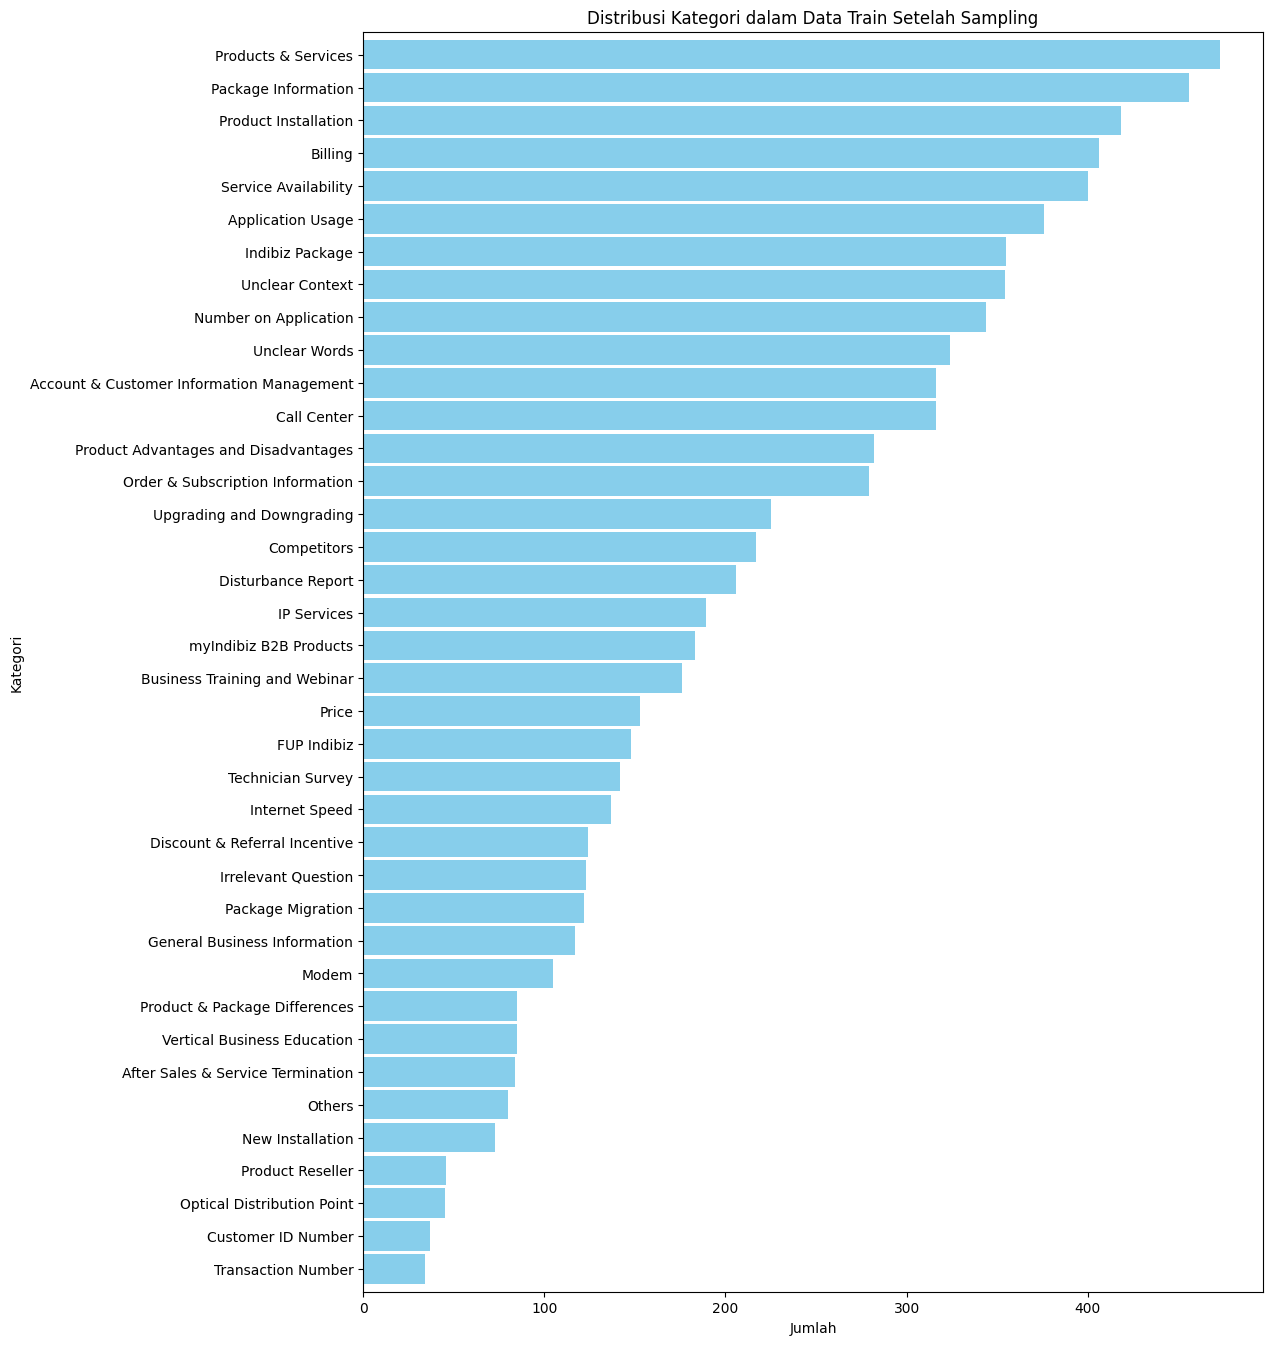

In [110]:
# Membuat bar chart
plt.figure(figsize=(12, 14))  # Meningkatkan ukuran figure
df_counts_train_sampled_sorted.plot(kind='barh', color='skyblue', width=0.9)

# Menambahkan pengaturan margin agar tidak terpotong
plt.xlabel("Jumlah")
plt.ylabel("Kategori")
plt.title("Distribusi Kategori dalam Data Train Setelah Sampling")
plt.gca().invert_yaxis()  # Membalik sumbu y untuk menampilkan kategori terbesar di atas

# Menyesuaikan margin
plt.subplots_adjust(left=0.2, right=0.95, top=0.95, bottom=0.05)

# Simpan dan tampilkan gambar
plt.savefig('train_after_sampling.png')
plt.show()

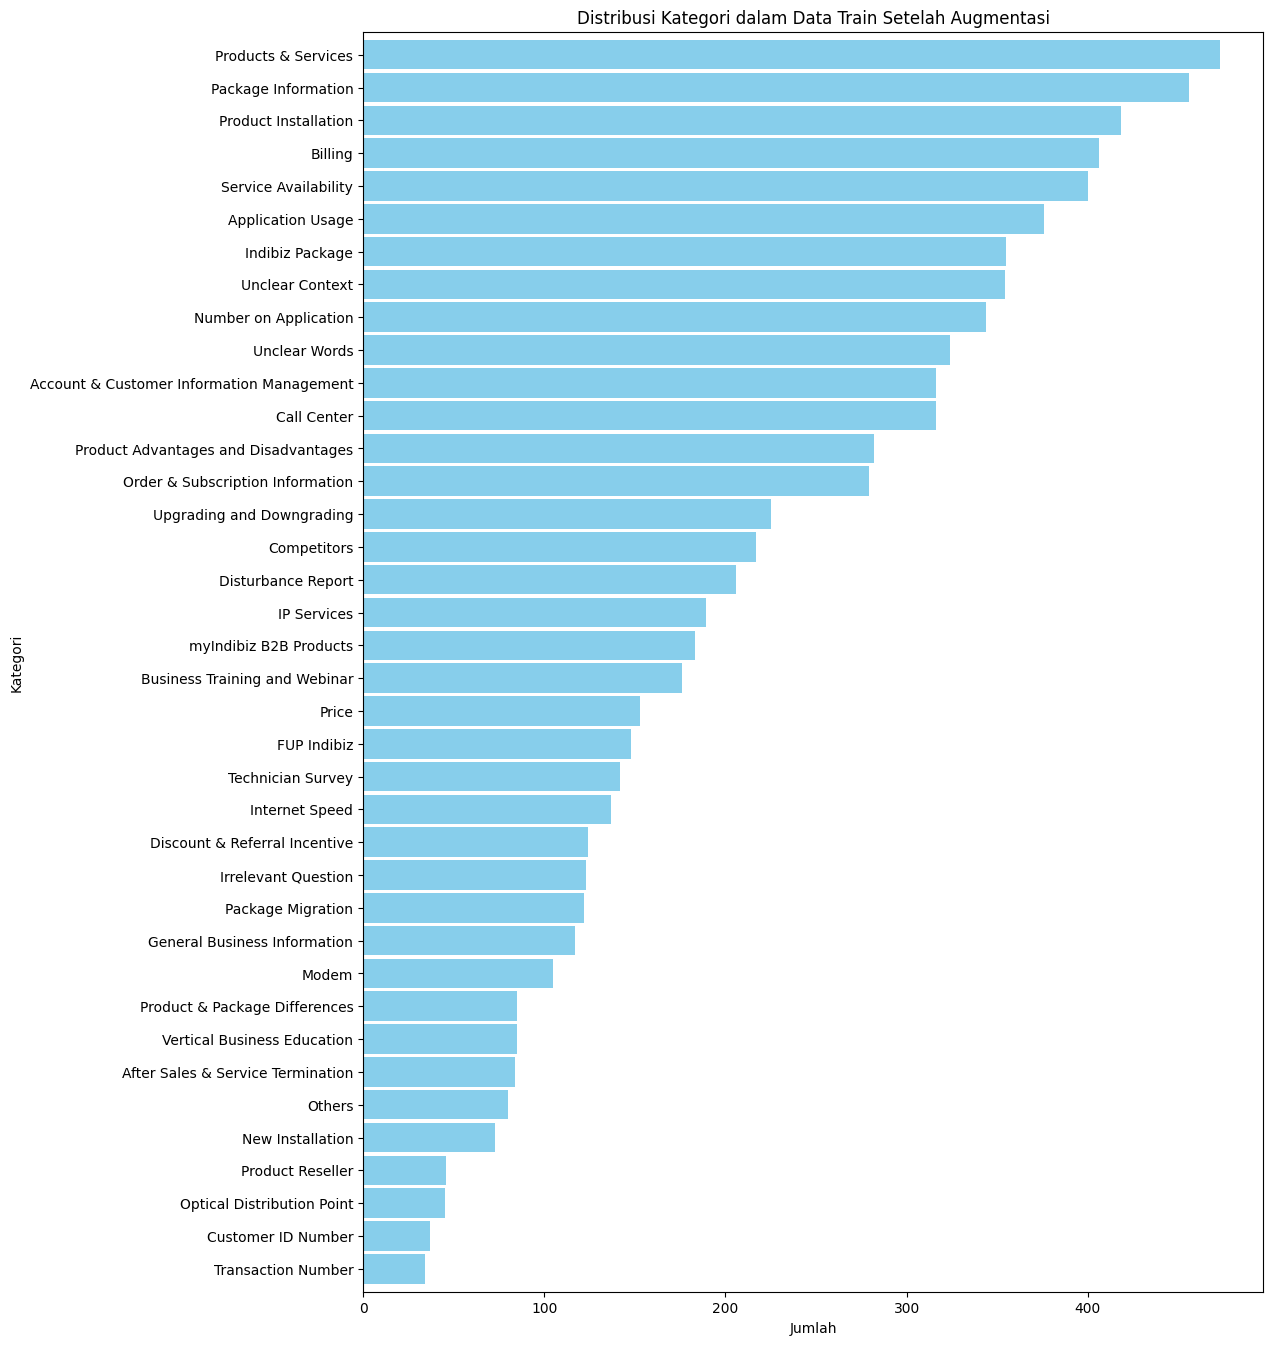

In [111]:
import pandas as pd
import matplotlib.pyplot as plt

df_counts_train = train_df['intent'].value_counts()
df_counts_train_sorted = df_counts_train.sort_values(ascending=False)

# Membuat bar chart
plt.figure(figsize=(12, 14))  # Meningkatkan ukuran figure
df_counts_train_sorted.plot(kind='barh', color='skyblue', width=0.9)

# Menambahkan pengaturan margin agar tidak terpotong
plt.xlabel("Jumlah")
plt.ylabel("Kategori")
plt.title("Distribusi Kategori dalam Data Train Setelah Augmentasi")
plt.gca().invert_yaxis()  # Membalik sumbu y untuk menampilkan kategori terbesar di atas

# Menyesuaikan margin
plt.subplots_adjust(left=0.2, right=0.95, top=0.95, bottom=0.05)

# Simpan dan tampilkan gambar
plt.savefig('train_after_augment.png')
plt.show()


In [112]:
#train_df = train_df_sampled

In [113]:
len(train_df)

8035

# Token_ID, Attention_Mask, Labels

In [114]:
seq_len = 256
num_train_samples = len(train_df)
num_val_samples = len(val_df)
num_samples = len(df_patterns)

In [115]:
# Siapkan array untuk token ids dan attention mask
Xids_train = np.zeros((num_train_samples, seq_len))  # Token ids untuk train
Xmask_train = np.zeros((num_train_samples, seq_len))  # Attention mask untuk train
Xids_val = np.zeros((num_val_samples, seq_len))  # Token ids untuk val
Xmask_val = np.zeros((num_val_samples, seq_len))  # Attention mask untuk val

In [116]:
Xids_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [117]:
Xids_train.shape

(8035, 256)

In [118]:
%%time
# we will populate the above zero arrays with actual values for each token
# from transformers import BertTokenizer

tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p2")

# Tokenisasi untuk train_df
for i, phrase in enumerate(train_df['text']):
    tokens = tokenizer.encode_plus(phrase, max_length=seq_len, truncation=True, padding='max_length', add_special_tokens=True, return_tensors='np')
    Xids_train[i, :] = tokens['input_ids']
    Xmask_train[i, :] = tokens['attention_mask']

# Tokenisasi untuk val_df
for i, phrase in enumerate(val_df['text']):
    tokens = tokenizer.encode_plus(phrase, max_length=seq_len, truncation=True, padding='max_length', add_special_tokens=True, return_tensors='np')
    Xids_val[i, :] = tokens['input_ids']
    Xmask_val[i, :] = tokens['attention_mask']

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


CPU times: user 1.92 s, sys: 35.2 ms, total: 1.95 s
Wall time: 2.1 s


In [119]:
Xids_train

array([[2.0000e+00, 2.7270e+03, 1.8440e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [2.0000e+00, 2.7270e+03, 3.0468e+04, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [2.0000e+00, 2.7270e+03, 3.0468e+04, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       ...,
       [2.0000e+00, 2.7270e+03, 3.0468e+04, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [2.0000e+00, 2.7270e+03, 3.0468e+04, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [2.0000e+00, 2.7270e+03, 1.8440e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]])

In [120]:
Xids_train[1]

array([2.0000e+00, 2.7270e+03, 3.0468e+04, 3.0500e+02, 9.2000e+01,
       2.0900e+02, 1.1900e+02, 3.4300e+02, 6.8300e+02, 1.0920e+03,
       2.6310e+03, 2.4070e+03, 9.8000e+01, 1.4300e+03, 3.0469e+04,
       1.4300e+03, 1.9980e+03, 3.4000e+01, 4.5150e+03, 1.1200e+02,
       5.4540e+03, 3.0470e+04, 3.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e

In [121]:
Xmask_train

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

In [122]:
print(Xids_train.shape)

(8035, 256)


In [123]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [124]:
arr = le.fit_transform(df_patterns['intent'])
arr_train = le.fit_transform(train_df['intent'])
arr_val = le.transform(val_df['intent'])  # Gunakan transform untuk val_df

In [125]:
labels = np.zeros((num_samples,arr.max() + 1))
labels_train = np.zeros((num_train_samples, arr_train.max() + 1))
labels_train[np.arange(num_train_samples), arr_train] = 1

labels_val = np.zeros((num_val_samples, arr_val.max() + 1))
labels_val[np.arange(num_val_samples), arr_val] = 1

In [126]:
labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [127]:
le.classes_

array(['Account & Customer Information Management',
       'After Sales & Service Termination', 'Application Usage',
       'Billing', 'Business Training and Webinar', 'Call Center',
       'Competitors', 'Customer ID Number',
       'Discount & Referral Incentive', 'Disturbance Report',
       'FUP Indibiz', 'General Business Information', 'IP Services',
       'Indibiz Package', 'Internet Speed', 'Irrelevant Question',
       'Modem', 'New Installation', 'Number on Application',
       'Optical Distribution Point', 'Order & Subscription Information',
       'Others', 'Package Information', 'Package Migration', 'Price',
       'Product & Package Differences',
       'Product Advantages and Disadvantages', 'Product Installation',
       'Product Reseller', 'Products & Services', 'Service Availability',
       'Technician Survey', 'Transaction Number', 'Unclear Context',
       'Unclear Words', 'Upgrading and Downgrading',
       'Vertical Business Education', 'myIndibiz B2B Products'],

In [128]:
# Ambil salah satu contoh dari train_df atau val_df
example_text = train_df['text'][0]  # Ganti dengan val_df['text'][0] untuk contoh dari validation set

# Tokenisasi dengan AutoTokenizer
tokens = tokenizer.encode_plus(example_text, 
                               max_length=seq_len, 
                               truncation=True, 
                               padding='max_length', 
                               add_special_tokens=True, 
                               return_tensors='np')

# Tampilkan hasil tokenisasi
print("Original Text:", example_text)
print("Token IDs:", tokens['input_ids'])
print("Attention Mask:", tokens['attention_mask'])

# Decode token IDs untuk melihat kata-kata yang sesuai
decoded_tokens = tokenizer.decode(tokens['input_ids'][0], skip_special_tokens=True)
print("Decoded Tokens:", decoded_tokens)


Original Text: Maaf, informasi yang diberikan dalam konteks tidak memberikan informasi tentang bisnis yang sedang tren saat ini.
Token IDs: [[    2  2727 30468   683    34  1591   112  5454   119   651   683   416
    996    34   829  7976   305    92 30470     3     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0   

# Data Pipeline

In [129]:
import tensorflow as tf

# Pastikan Anda sudah memiliki Xids_train, Xmask_train, labels_train, Xids_val, Xmask_val, labels_val

# Mengonversi numpy arrays ke TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((Xids_train, Xmask_train, labels_train))
val_dataset = tf.data.Dataset.from_tensor_slices((Xids_val, Xmask_val, labels_val))

# Fungsi map untuk mengonversi input menjadi format yang diinginkan
def map_function(input_ids, masks, labels):
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

# Menerapkan fungsi map
train_dataset = train_dataset.map(map_function)
val_dataset = val_dataset.map(map_function)

# Mengacak dan membaginya menjadi batch
train_dataset = train_dataset.shuffle(1000).batch(batch_size, drop_remainder=True)
val_dataset = val_dataset.batch(batch_size, drop_remainder=True)

# Verifikasi dataset
print(f"Jumlah batch train_dataset: {len(list(train_dataset))}")
print(f"Jumlah batch val_dataset: {len(list(val_dataset))}")

Jumlah batch train_dataset: 502
Jumlah batch val_dataset: 55


In [130]:
train_dataset

<_BatchDataset element_spec=({'input_ids': TensorSpec(shape=(16, 256), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(16, 256), dtype=tf.float64, name=None)}, TensorSpec(shape=(16, 38), dtype=tf.float64, name=None))>

In [131]:
labels_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

# Training Model

In [132]:
'''from transformers import TFAutoModel

bert = TFAutoModel.from_pretrained("indobenchmark/indobert-base-p2", num_labels=arr.max()+1)'''

'from transformers import TFAutoModel\n\nbert = TFAutoModel.from_pretrained("indobenchmark/indobert-base-p2", num_labels=arr.max()+1)'

In [133]:
#bert.summary()

In [134]:
'''input_ids = tf.keras.layers.Input(shape= (seq_len,), name= 'input_ids', dtype='int32') #input layer for tokens
mask = tf.keras.layers.Input(shape= (seq_len,), name= 'attention_mask', dtype='int32') #input layer for attention masks'''

"input_ids = tf.keras.layers.Input(shape= (seq_len,), name= 'input_ids', dtype='int32') #input layer for tokens\nmask = tf.keras.layers.Input(shape= (seq_len,), name= 'attention_mask', dtype='int32') #input layer for attention masks"

In [135]:
'''embeddings = bert.bert(input_ids, attention_mask= mask)[1]
x = tf.keras.layers.Dense(layer_unit, activation= activation_function, kernel_regularizer=l2_values)(embeddings)
x = tf.keras.layers.Dropout(dropout_val)(x)
y = tf.keras.layers.Dense(arr.max()+1, activation= 'softmax', name= 'outputs')(x)'''

"embeddings = bert.bert(input_ids, attention_mask= mask)[1]\nx = tf.keras.layers.Dense(layer_unit, activation= activation_function, kernel_regularizer=l2_values)(embeddings)\nx = tf.keras.layers.Dropout(dropout_val)(x)\ny = tf.keras.layers.Dense(arr.max()+1, activation= 'softmax', name= 'outputs')(x)"

In [136]:
'''model = tf.keras.Model(inputs= [input_ids, mask], outputs = y)'''

'model = tf.keras.Model(inputs= [input_ids, mask], outputs = y)'

In [137]:
'''model.summary()'''

'model.summary()'

In [138]:
'''optimizer = tf.keras.optimizers.Adam(learning_rate= learning_rate, weight_decay = weight_decay)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')
recall=tf.keras.metrics.Recall()
precision=tf.keras.metrics.Precision()
f1_score=tf.keras.metrics.F1Score()'''

"optimizer = tf.keras.optimizers.Adam(learning_rate= learning_rate, weight_decay = weight_decay)\nloss = tf.keras.losses.CategoricalCrossentropy()\nacc = tf.keras.metrics.CategoricalAccuracy('accuracy')\nrecall=tf.keras.metrics.Recall()\nprecision=tf.keras.metrics.Precision()\nf1_score=tf.keras.metrics.F1Score()"

In [139]:
'''import tensorflow as tf

def focal_loss(gamma, alpha):
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        fl = - alpha * tf.pow((1 - p_t), gamma) * tf.math.log(p_t + tf.keras.backend.epsilon())
        return tf.reduce_mean(fl)
    return focal_loss_fixed'''

'import tensorflow as tf\n\ndef focal_loss(gamma, alpha):\n    def focal_loss_fixed(y_true, y_pred):\n        y_true = tf.convert_to_tensor(y_true, tf.float32)\n        y_pred = tf.convert_to_tensor(y_pred, tf.float32)\n        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)\n        fl = - alpha * tf.pow((1 - p_t), gamma) * tf.math.log(p_t + tf.keras.backend.epsilon())\n        return tf.reduce_mean(fl)\n    return focal_loss_fixed'

In [140]:
'''model.compile(optimizer= optimizer, loss=focal_loss(gamma=gamma, alpha=alpha), metrics = [acc,recall,precision,f1_score])'''

'model.compile(optimizer= optimizer, loss=focal_loss(gamma=gamma, alpha=alpha), metrics = [acc,recall,precision,f1_score])'

In [141]:
'''from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(arr), y=arr)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}'''

"from sklearn.utils.class_weight import compute_class_weight\nclass_weights = compute_class_weight('balanced', classes=np.unique(arr), y=arr)\nclass_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}"

In [142]:
'''print("Shape of labels_train:", labels_train.shape)
print("Shape of labels_val:", labels_val.shape)
print("Class weights dict:", class_weight_dict)'''

'print("Shape of labels_train:", labels_train.shape)\nprint("Shape of labels_val:", labels_val.shape)\nprint("Class weights dict:", class_weight_dict)'

In [143]:
'''%%time
history = model.fit(train_dataset, epochs=8, class_weight=class_weight_dict)'''

'%%time\nhistory = model.fit(train_dataset, epochs=8, class_weight=class_weight_dict)'

In [144]:
'''import matplotlib.pyplot as plt'''

'import matplotlib.pyplot as plt'

In [145]:
'''# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()'''

"# Plot training and validation accuracy\nplt.plot(history.history['accuracy'])\nplt.plot(history.history['val_accuracy'])\nplt.title('Model Accuracy')\nplt.xlabel('Epoch')\nplt.ylabel('Accuracy')\nplt.legend(['Train', 'Validation'], loc='upper left')\nplt.show()"

In [146]:
'''# Example: Save your model
model.save('/kaggle/working/model64e15.h5')'''

"# Example: Save your model\nmodel.save('/kaggle/working/model64e15.h5')"

# Testing


In [147]:
'''import tensorflow as tf

# Contoh implementasi focal loss
def focal_loss_fixed(y_true, y_pred, gamma=2., alpha=.25):
    epsilon = tf.keras.backend.epsilon()
    y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
    cross_entropy = -y_true * tf.math.log(y_pred)
    weight = alpha * tf.pow(1 - y_pred, gamma)
    loss = weight * cross_entropy
    return tf.reduce_sum(loss, axis=1)'''


'import tensorflow as tf\n\n# Contoh implementasi focal loss\ndef focal_loss_fixed(y_true, y_pred, gamma=2., alpha=.25):\n    epsilon = tf.keras.backend.epsilon()\n    y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)\n    cross_entropy = -y_true * tf.math.log(y_pred)\n    weight = alpha * tf.pow(1 - y_pred, gamma)\n    loss = weight * cross_entropy\n    return tf.reduce_sum(loss, axis=1)'

In [148]:
'''model = tf.keras.models.load_model('/kaggle/working/model64e15.h5',custom_objects={'focal_loss_fixed': focal_loss_fixed})
model'''

"model = tf.keras.models.load_model('/kaggle/working/model64e15.h5',custom_objects={'focal_loss_fixed': focal_loss_fixed})\nmodel"

In [149]:
'''def prep_data(text):
    tokens = tokenizer.encode_plus(text, max_length = seq_len,
                                  truncation= True, padding= 'max_length',
                                  add_special_tokens = True,
                                  return_tensors= 'tf')
    return {
        'input_ids' : tf.cast(tokens['input_ids'], tf.float64),
        'attention_mask' : tf.cast(tokens['attention_mask'], tf.float64)
    }'''

"def prep_data(text):\n    tokens = tokenizer.encode_plus(text, max_length = seq_len,\n                                  truncation= True, padding= 'max_length',\n                                  add_special_tokens = True,\n                                  return_tensors= 'tf')\n    return {\n        'input_ids' : tf.cast(tokens['input_ids'], tf.float64),\n        'attention_mask' : tf.cast(tokens['attention_mask'], tf.float64)\n    }"

In [150]:
#arr

In [151]:
#le.classes_

In [152]:
'''unique_intents = df_patterns['intent'].unique()
res_dict = {i: intent for i, intent in enumerate(unique_intents)}
res_dict'''

"unique_intents = df_patterns['intent'].unique()\nres_dict = {i: intent for i, intent in enumerate(unique_intents)}\nres_dict"

In [153]:
'''# Define the classification threshold
# threshold = 0.3  # You can adjust this threshold as needed

# Create a function to classify the intent
def classify_intent(text):
    prep = prep_data(text)
    prob = model.predict(prep)
    max_prob = np.max(prob)
    
    # Update res_dict based on `df_patterns['intent']`
    res_dict = {index: intent for index, intent in enumerate(le.classes_)}

    
    # Return the classified intent based on the highest probability index
    return res_dict[np.argmax(prob)]'''


"# Define the classification threshold\n# threshold = 0.3  # You can adjust this threshold as needed\n\n# Create a function to classify the intent\ndef classify_intent(text):\n    prep = prep_data(text)\n    prob = model.predict(prep)\n    max_prob = np.max(prob)\n    \n    # Update res_dict based on `df_patterns['intent']`\n    res_dict = {index: intent for index, intent in enumerate(le.classes_)}\n\n    \n    # Return the classified intent based on the highest probability index\n    return res_dict[np.argmax(prob)]"

In [154]:
'''# Assuming you have the 'test_df' DataFrame with 'text' and 'intent' columns
for index, row in test_df.iterrows():
    text = row['text']
    real_intent = row['intent']
    predicted_intent = classify_intent(text)
    print(f"Text: {text}")
    print(f"Real Intent: {real_intent}")
    print(f"Predicted Intent: {predicted_intent}\n")'''

'# Assuming you have the \'test_df\' DataFrame with \'text\' and \'intent\' columns\nfor index, row in test_df.iterrows():\n    text = row[\'text\']\n    real_intent = row[\'intent\']\n    predicted_intent = classify_intent(text)\n    print(f"Text: {text}")\n    print(f"Real Intent: {real_intent}")\n    print(f"Predicted Intent: {predicted_intent}\n")'

In [155]:
'''from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Create lists to store the real and predicted intents
real_intents = []
predicted_intents = []

# Assuming you have the 'test_df' DataFrame with 'text' and 'intent' columns
for index, row in test_df.iterrows():
    text = row['text']
    real_intent = row['intent']
    predicted_intent = classify_intent(text)
    real_intents.append(real_intent)
    predicted_intents.append(predicted_intent)

# Calculate and print evaluation metrics
accuracy = accuracy_score(real_intents, predicted_intents)
precision = precision_score(real_intents, predicted_intents, average='macro')
recall = recall_score(real_intents, predicted_intents, average='macro')
f1 = f1_score(real_intents, predicted_intents, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)'''


'from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score\n\n# Create lists to store the real and predicted intents\nreal_intents = []\npredicted_intents = []\n\n# Assuming you have the \'test_df\' DataFrame with \'text\' and \'intent\' columns\nfor index, row in test_df.iterrows():\n    text = row[\'text\']\n    real_intent = row[\'intent\']\n    predicted_intent = classify_intent(text)\n    real_intents.append(real_intent)\n    predicted_intents.append(predicted_intent)\n\n# Calculate and print evaluation metrics\naccuracy = accuracy_score(real_intents, predicted_intents)\nprecision = precision_score(real_intents, predicted_intents, average=\'macro\')\nrecall = recall_score(real_intents, predicted_intents, average=\'macro\')\nf1 = f1_score(real_intents, predicted_intents, average=\'macro\')\n\nprint("Accuracy:", accuracy)\nprint("Precision:", precision)\nprint("Recall:", recall)\nprint("F1 Score:", f1)'

In [156]:
#res_dict.values()

In [157]:
'''from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have 'real_intents' and 'predicted_intents'
# Ensure that the unique classes are correctly identified
unique_classes = sorted(set(real_intents).union(set(predicted_intents)))

# Create a dictionary for labeling
res_dict = {i: label for i, label in enumerate(unique_classes)}

# Create a confusion matrix
confusion = confusion_matrix(real_intents, predicted_intents)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=[res_dict[i] for i in range(len(unique_classes))], yticklabels=[res_dict[i] for i in range(len(unique_classes))])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion matrix.png', bbox_inches='tight')
plt.show()'''


"from sklearn.metrics import confusion_matrix\nimport seaborn as sns\nimport matplotlib.pyplot as plt\n\n# Assuming you have 'real_intents' and 'predicted_intents'\n# Ensure that the unique classes are correctly identified\nunique_classes = sorted(set(real_intents).union(set(predicted_intents)))\n\n# Create a dictionary for labeling\nres_dict = {i: label for i, label in enumerate(unique_classes)}\n\n# Create a confusion matrix\nconfusion = confusion_matrix(real_intents, predicted_intents)\n\n# Plot the confusion matrix as a heatmap\nplt.figure(figsize=(10, 8))\nsns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=[res_dict[i] for i in range(len(unique_classes))], yticklabels=[res_dict[i] for i in range(len(unique_classes))])\nplt.xlabel('Predicted')\nplt.ylabel('Actual')\nplt.title('Confusion Matrix')\nplt.savefig('confusion matrix.png', bbox_inches='tight')\nplt.show()"

In [158]:
'''from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(real_intents, predicted_intents)

# Calculate precision, recall, and F1-score for each intent
precision = precision_score(real_intents, predicted_intents, average=None)
recall = recall_score(real_intents, predicted_intents, average=None)
f1 = f1_score(real_intents, predicted_intents, average=None)

# Create a dictionary to store metrics for each intent
intent_metrics = {}
for label, precision_value, recall_value, f1_value in zip(unique_classes, precision, recall, f1):
    intent_metrics[label] = {
        'Accuracy': accuracy,
        'Precision': precision_value,
        'Recall': recall_value,
        'F1 Score': f1_value
    }

# Print the metrics for each intent
for intent, metrics in intent_metrics.items():
    print(f"Intent: {intent}")
    print(f"Accuracy: {metrics['Accuracy']:.2f}")
    print(f"Precision: {metrics['Precision']:.2f}")
    print(f"Recall: {metrics['Recall']:.2f}")
    print(f"F1 Score: {metrics['F1 Score']:.2f}")
    print()
'''

'from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score\n\n# Calculate accuracy\naccuracy = accuracy_score(real_intents, predicted_intents)\n\n# Calculate precision, recall, and F1-score for each intent\nprecision = precision_score(real_intents, predicted_intents, average=None)\nrecall = recall_score(real_intents, predicted_intents, average=None)\nf1 = f1_score(real_intents, predicted_intents, average=None)\n\n# Create a dictionary to store metrics for each intent\nintent_metrics = {}\nfor label, precision_value, recall_value, f1_value in zip(unique_classes, precision, recall, f1):\n    intent_metrics[label] = {\n        \'Accuracy\': accuracy,\n        \'Precision\': precision_value,\n        \'Recall\': recall_value,\n        \'F1 Score\': f1_value\n    }\n\n# Print the metrics for each intent\nfor intent, metrics in intent_metrics.items():\n    print(f"Intent: {intent}")\n    print(f"Accuracy: {metrics[\'Accuracy\']:.2f}")\n    print(f"Precision: {metric

In [159]:
'''import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Hitung metrik evaluasi
accuracy = accuracy_score(real_intents, predicted_intents)
precision = precision_score(real_intents, predicted_intents, average=None)
recall = recall_score(real_intents, predicted_intents, average=None)
f1 = f1_score(real_intents, predicted_intents, average=None)

# Buat DataFrame untuk tabel metrik
metrics_df = pd.DataFrame({
    'Intent': unique_classes,
    'Accuracy': [accuracy] * len(unique_classes),  # Akurasi global sama untuk semua intent
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
})

# Tampilkan tabel metrik
print(metrics_df)

# Simpan tabel ke file CSV (opsional)
metrics_df.to_csv('intent_metrics.csv', index=False)'''

"import pandas as pd\nfrom sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score\n\n# Hitung metrik evaluasi\naccuracy = accuracy_score(real_intents, predicted_intents)\nprecision = precision_score(real_intents, predicted_intents, average=None)\nrecall = recall_score(real_intents, predicted_intents, average=None)\nf1 = f1_score(real_intents, predicted_intents, average=None)\n\n# Buat DataFrame untuk tabel metrik\nmetrics_df = pd.DataFrame({\n    'Intent': unique_classes,\n    'Accuracy': [accuracy] * len(unique_classes),  # Akurasi global sama untuk semua intent\n    'Precision': precision,\n    'Recall': recall,\n    'F1 Score': f1\n})\n\n# Tampilkan tabel metrik\nprint(metrics_df)\n\n# Simpan tabel ke file CSV (opsional)\nmetrics_df.to_csv('intent_metrics.csv', index=False)"

In [160]:
# Tokenisasi untuk satu contoh (misalnya contoh pertama pada train_df)
sample_text = train_df['text'][0]  # Ambil contoh pertama
tokens = tokenizer.encode_plus(sample_text, max_length=seq_len, truncation=True, padding='max_length', add_special_tokens=True, return_tensors='np')

print(sample_text)
print("Token IDs:", tokens['input_ids'])  # Menampilkan token IDs
print("Attention Mask:", tokens['attention_mask'])  # Menampilkan attention mask

Maaf, informasi yang diberikan dalam konteks tidak memberikan informasi tentang bisnis yang sedang tren saat ini.
Token IDs: [[    2  2727 30468   683    34  1591   112  5454   119   651   683   416
    996    34   829  7976   305    92 30470     3     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0

# Cross Validation

In [161]:
from transformers import AutoModel
import pandas as pd
from transformers import TFDistilBertForSequenceClassification, DistilBertTokenizer

# Load IndoBERT model
model = AutoModel.from_pretrained("indobenchmark/indobert-base-p2")
#model = TFDistilBertForSequenceClassification.from_pretrained('cahya/distilbert-base-indonesian', from_pt=True)

# Collect parameter information
'''parameters_info = []
for name, param in model.named_parameters():
    parameters_info.append({
        "Parameter Name": name,
        "Shape": tuple(param.shape),
        "Num Elements": param.numel(),
        "Requires Grad": param.requires_grad
    })

# Convert to DataFrame
df_params = pd.DataFrame(parameters_info)

# Save to CSV
df_params.to_csv("indobert_parameters_details.csv", index=False)
print(df_params.head())'''


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

'parameters_info = []\nfor name, param in model.named_parameters():\n    parameters_info.append({\n        "Parameter Name": name,\n        "Shape": tuple(param.shape),\n        "Num Elements": param.numel(),\n        "Requires Grad": param.requires_grad\n    })\n\n# Convert to DataFrame\ndf_params = pd.DataFrame(parameters_info)\n\n# Save to CSV\ndf_params.to_csv("indobert_parameters_details.csv", index=False)\nprint(df_params.head())'

In [162]:
# Definisikan fungsi prepare_dataset untuk memproses dataset
def prepare_dataset(df, seq_len):
    # Inisialisasi tokenizer dari model IndoBERT
    tokenizer = AutoTokenizer.from_pretrained('indobenchmark/indobert-base-p2')
    #tokenizer = DistilBertTokenizer.from_pretrained('cahya/distilbert-base-indonesian')

    # Tokenisasi teks
    tokens = tokenizer(
        df['text'].tolist(),  # Pastikan kolom teks pada dataframe memiliki nama 'text'
        max_length=seq_len,
        truncation=True,
        padding='max_length',  # Padding sesuai dengan panjang maksimum sequence
        return_tensors='np'  # Kembalikan sebagai format NumPy
    )
    
    # Ekstrak input_ids dan attention_mask
    input_ids = tokens['input_ids']
    attention_mask = tokens['attention_mask']
    
    # Encode label jika perlu
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(df['intent'].tolist())  # Pastikan kolom label adalah 'intent'
    labels = tf.keras.utils.to_categorical(labels, num_classes=len(label_encoder.classes_))  # One-hot encoding
    
    return input_ids, attention_mask, labels

In [163]:
print(df['intent'].head())  # Gantilah 'df' dengan 'train_df' jika Anda ingin memeriksa train_df

0        General Business Information
1                      Internet Speed
2    Order & Subscription Information
3                             Billing
4                   Application Usage
Name: intent, dtype: object


In [164]:
device = 0

In [165]:
import numpy as np
import pandas as pd
import tensorflow as tf
from transformers import AutoTokenizer, TFBertModel
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import AdamW

# 1. Membuat Model dengan AdamW dan Categorical Crossentropy
def create_model(seq_len, num_classes, learning_rate, weight_decay, dropout_val, l2_values):
    # Initialize the Bert model
    bert_model = TFBertModel.from_pretrained('indobenchmark/indobert-base-p2')
    #bert_model = TFDistilBertForSequenceClassification.from_pretrained('cahya/distilbert-base-indonesian', from_pt=True)

    # Define inputs
    input_ids = tf.keras.Input(shape=(seq_len,), dtype=tf.int32, name='input_ids')
    attention_mask = tf.keras.Input(shape=(seq_len,), dtype=tf.int32, name='attention_mask')
    
    # Get outputs from Bert model
    outputs = bert_model(input_ids, attention_mask=attention_mask)

    # Create classification layer with Dropout and L2 Regularization
    x = tf.keras.layers.Dropout(dropout_val)(outputs[0][:, 0, :])  # Dropout after BERT output
    #x = tf.keras.layers.Dropout(dropout_val)(outputs[0])  # Dropout after BERT output

    logits = tf.keras.layers.Dense(num_classes, activation='softmax', 
                                   kernel_regularizer=l2_values)(x)  # L2 regularization

    # Set up optimizer AdamW and metrics
    optimizer = AdamW(learning_rate=learning_rate, weight_decay=weight_decay)
    
    # Menggunakan Categorical Crossentropy sebagai loss function
    loss = 'categorical_crossentropy'  # Categorical Crossentropy Loss
    
    # Definisikan metrik untuk evaluasi model
    acc = tf.keras.metrics.CategoricalAccuracy('accuracy')
    recall = tf.keras.metrics.Recall()
    precision = tf.keras.metrics.Precision()
    f1_score = tf.keras.metrics.F1Score()

    # Compile the model
    model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=logits)
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=[acc, recall, precision, f1_score])  # Exclude F1Score if using focal loss as it may not be directly supported

    return model

# 2. Siapkan Dataset
seq_len = 128  # Panjang maksimum dari sequence
Xids_train, Xmask_train, labels_train = prepare_dataset(train_df, seq_len)
Xids_val, Xmask_val, labels_val = prepare_dataset(val_df, seq_len)

# 3. Buat TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices(((Xids_train, Xmask_train), labels_train))
val_dataset = tf.data.Dataset.from_tensor_slices(((Xids_val, Xmask_val), labels_val))

# Batch dan Shuffle Dataset
train_dataset = train_dataset.shuffle(1000).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [166]:
import tensorflow as tf
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping

# === 1. Warmup Learning Rate Callback ===
class WarmupScheduler(Callback):
    def __init__(self, warmup_epochs, initial_lr, target_lr):
        super(WarmupScheduler, self).__init__()
        self.warmup_epochs = warmup_epochs
        self.initial_lr = initial_lr
        self.target_lr = target_lr
    
    def on_epoch_begin(self, epoch, logs=None):
        if epoch < self.warmup_epochs:
            new_lr = self.initial_lr + (self.target_lr - self.initial_lr) * (epoch / self.warmup_epochs)
            tf.keras.backend.set_value(self.model.optimizer.lr, new_lr)
            print(f"\n🟢 Warmup: Setting learning rate to {new_lr:.6f}")
        else:
            print(f"\n🔵 Learning rate after warmup: {tf.keras.backend.get_value(self.model.optimizer.lr):.6f}")

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=1e-4, verbose=1, restore_best_weights=True)

num_classes = len(train_df['intent'].unique())  # Hitung jumlah kelas

with tf.device('/GPU:0'):
    model = create_model(seq_len, num_classes, learning_rate, weight_decay, dropout_val, l2_values)
    
    # === 5. Train Model ===
    history = model.fit(train_dataset, 
                        validation_data=val_dataset, 
                        epochs=epochs, 
                        callbacks=[
                            WarmupScheduler(warmup_epochs=5, initial_lr=initial_lr, target_lr=learning_rate), 
                            reduce_lr, 
                            early_stopping
                        ])


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some layers from the model checkpoint at indobenchmark/indobert-base-p2 were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at indobenchmark/indobert-base-p2.
If your 


🟢 Warmup: Setting learning rate to 0.000100
Epoch 1/8
503/503 [==============================] - 185s 288ms/step - loss: 1.5346 - accuracy: 0.6829 - recall: 0.6126 - precision: 0.8256 - f1_score: 0.6560 - val_loss: 0.9999 - val_accuracy: 0.8007 - val_recall: 0.7693 - val_precision: 0.9016 - val_f1_score: 0.7945 - lr: 1.0000e-04

🟢 Warmup: Setting learning rate to 0.000080
Epoch 2/8
503/503 [==============================] - 141s 281ms/step - loss: 0.8000 - accuracy: 0.8480 - recall: 0.8136 - precision: 0.9060 - f1_score: 0.8268 - val_loss: 0.8598 - val_accuracy: 0.8331 - val_recall: 0.8052 - val_precision: 0.8790 - val_f1_score: 0.8229 - lr: 8.0200e-05

🟢 Warmup: Setting learning rate to 0.000060
Epoch 3/8
503/503 [==============================] - 141s 280ms/step - loss: 0.5326 - accuracy: 0.9068 - recall: 0.8895 - precision: 0.9378 - f1_score: 0.8952 - val_loss: 0.7923 - val_accuracy: 0.8589 - val_recall: 0.8488 - val_precision: 0.8981 - val_f1_score: 0.8573 - lr: 6.0400e-05

🟢 Warm

In [167]:
from sklearn.metrics import classification_report, accuracy_score

# 1. Buat prediksi pada data validasi
y_true = labels_val  # label asli
y_pred_probs = model.predict(val_dataset)  # prediksi probabilitas
y_pred = np.argmax(y_pred_probs, axis=1)  # konversi ke label prediksi

# 2. Konversi label asli dari one-hot ke label integer
y_true = np.argmax(y_true, axis=1)  # jika label one-hot encoded

# 3. Gunakan classification_report untuk mendapatkan hasil macro dan weighted average
report = classification_report(y_true, y_pred, target_names=le.classes_, digits=4)
print(report)

56/56 [==============================] - 8s 93ms/step
                                           precision    recall  f1-score   support

Account & Customer Information Management     0.9375    0.8571    0.8955        35
        After Sales & Service Termination     0.8889    0.8889    0.8889         9
                        Application Usage     0.8511    0.9524    0.8989        42
                                  Billing     0.8235    0.9333    0.8750        45
            Business Training and Webinar     0.9000    0.9000    0.9000        20
                              Call Center     0.9167    0.9429    0.9296        35
                              Competitors     0.9565    0.9167    0.9362        24
                       Customer ID Number     0.6000    0.7500    0.6667         4
            Discount & Referral Incentive     0.9333    1.0000    0.9655        14
                       Disturbance Report     0.9524    0.8696    0.9091        23
                              FU

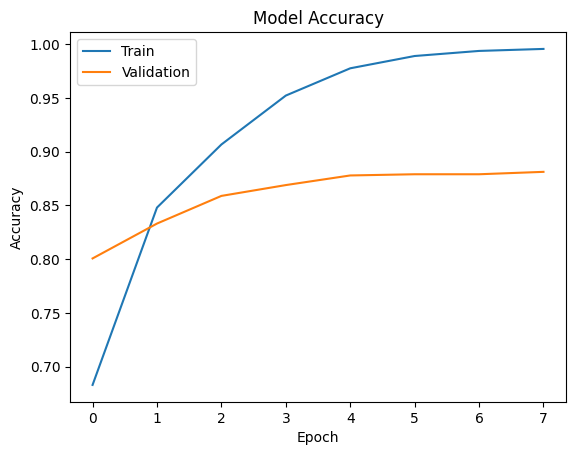

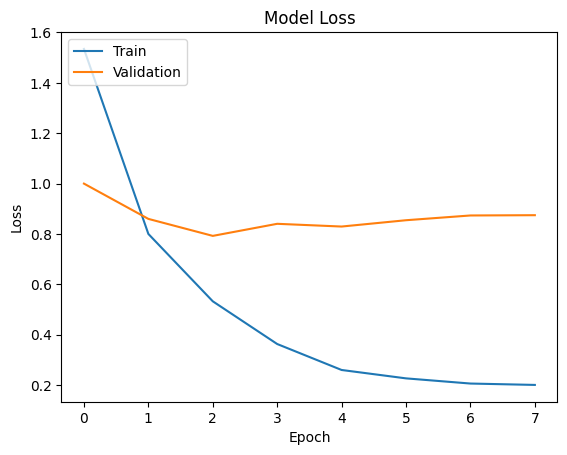

In [168]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Testing Cross Validation

In [169]:
from tensorflow.keras.models import load_model
from transformers import TFBertModel

# Load the model with custom objects
'''model = load_model(
    '/kaggle/input/model-fix-fix/keras/default/1/model_fix.h5',
    custom_objects={'TFBertModel': TFBertModel}
)'''

"model = load_model(\n    '/kaggle/input/model-fix-fix/keras/default/1/model_fix.h5',\n    custom_objects={'TFBertModel': TFBertModel}\n)"

In [170]:
# Definisikan fungsi prepare_dataset untuk memproses dataset
def prepare_dataset(df, seq_len):
    # Inisialisasi tokenizer dari model IndoBERT
    tokenizer = AutoTokenizer.from_pretrained('indobenchmark/indobert-base-p2')
    
    # Tokenisasi teks
    tokens = tokenizer(
        df['text'].tolist(),  # Pastikan kolom teks pada dataframe memiliki nama 'text'
        max_length=seq_len,
        truncation=True,
        padding='max_length',  # Padding sesuai dengan panjang maksimum sequence
        return_tensors='np'  # Kembalikan sebagai format NumPy
    )
    
    # Ekstrak input_ids dan attention_mask
    input_ids = tokens['input_ids']
    attention_mask = tokens['attention_mask']
    
    # Encode label jika perlu
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(df['intent'].tolist())  # Pastikan kolom label adalah 'intent'
    labels = tf.keras.utils.to_categorical(labels, num_classes=len(label_encoder.classes_))  # One-hot encoding
    
    return input_ids, attention_mask, labels

In [171]:
# 2. Siapkan Dataset
seq_len = 128  # Panjang maksimum dari sequence
Xids_train, Xmask_train, labels_train = prepare_dataset(train_df, seq_len)
Xids_val, Xmask_val, labels_val = prepare_dataset(val_df, seq_len)

# 3. Buat TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices(((Xids_train, Xmask_train), labels_train))
val_dataset = tf.data.Dataset.from_tensor_slices(((Xids_val, Xmask_val), labels_val))

# Batch dan Shuffle Dataset
train_dataset = train_dataset.shuffle(1000).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [172]:
def prep_data(text):
    tokens = tokenizer.encode_plus(text, max_length = seq_len,
                                  truncation= True, padding= 'max_length',
                                  add_special_tokens = True,
                                  return_tensors= 'tf')
    return {
        'input_ids' : tf.cast(tokens['input_ids'], tf.float64),
        'attention_mask' : tf.cast(tokens['attention_mask'], tf.float64)
    }

In [173]:
unique_intents = df_patterns['intent'].unique()
res_dict = {i: intent for i, intent in enumerate(unique_intents)}
res_dict

{0: 'Billing',
 1: 'Business Training and Webinar',
 2: 'Indibiz Package',
 3: 'Product Advantages and Disadvantages',
 4: 'General Business Information',
 5: 'Optical Distribution Point',
 6: 'IP Services',
 7: 'Order & Subscription Information',
 8: 'Number on Application',
 9: 'Disturbance Report',
 10: 'myIndibiz B2B Products',
 11: 'Unclear Context',
 12: 'Application Usage',
 13: 'Modem',
 14: 'Product Installation',
 15: 'Internet Speed',
 16: 'Price',
 17: 'Discount & Referral Incentive',
 18: 'Call Center',
 19: 'Products & Services',
 20: 'Package Information',
 21: 'Upgrading and Downgrading',
 22: 'New Installation',
 23: 'Service Availability',
 24: 'FUP Indibiz',
 25: 'Technician Survey',
 26: 'Unclear Words',
 27: 'Competitors',
 28: 'Vertical Business Education',
 29: 'Irrelevant Question',
 30: 'Account & Customer Information Management',
 31: 'Customer ID Number',
 32: 'Product & Package Differences',
 33: 'Package Migration',
 34: 'After Sales & Service Termination',

In [174]:
# Define the classification threshold
# threshold = 0.3  # You can adjust this threshold as needed

# Create a function to classify the intent
def classify_intent(text):
    prep = prep_data(text)
    prob = model.predict(prep)
    max_prob = np.max(prob)
    
    # Update res_dict based on `df_patterns['intent']`
    res_dict = {index: intent for index, intent in enumerate(le.classes_)}

    
    # Return the classified intent based on the highest probability index
    return res_dict[np.argmax(prob)]


In [175]:
# Assuming you have the 'test_df' DataFrame with 'text' and 'intent' columns
'''for index, row in test_df.iterrows():
    text = row['text']
    real_intent = row['intent']
    predicted_intent = classify_intent(text)
    print(f"Text: {text}")
    print(f"Real Intent: {real_intent}")
    print(f"Predicted Intent: {predicted_intent}\n'''

'for index, row in test_df.iterrows():\n    text = row[\'text\']\n    real_intent = row[\'intent\']\n    predicted_intent = classify_intent(text)\n    print(f"Text: {text}")\n    print(f"Real Intent: {real_intent}")\n    print(f"Predicted Intent: {predicted_intent}\n'

In [176]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Create lists to store the real and predicted intents
real_intents = []
predicted_intents = []

# Assuming you have the 'test_df' DataFrame with 'text' and 'intent' columns
for index, row in test_df.iterrows():
    text = row['text']
    real_intent = row['intent']
    predicted_intent = classify_intent(text)
    real_intents.append(real_intent)
    predicted_intents.append(predicted_intent)

# Calculate and print evaluation metrics
accuracy = accuracy_score(real_intents, predicted_intents)
precision = precision_score(real_intents, predicted_intents, average='macro')
recall = recall_score(real_intents, predicted_intents, average='macro')
f1 = f1_score(real_intents, predicted_intents, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


1/1 [==============================] - 0s 40ms/step
Accuracy: 0.8610271903323263
Precision: 0.868969680802577
Recall: 0.8494247806272197
F1 Score: 0.8511181133280367


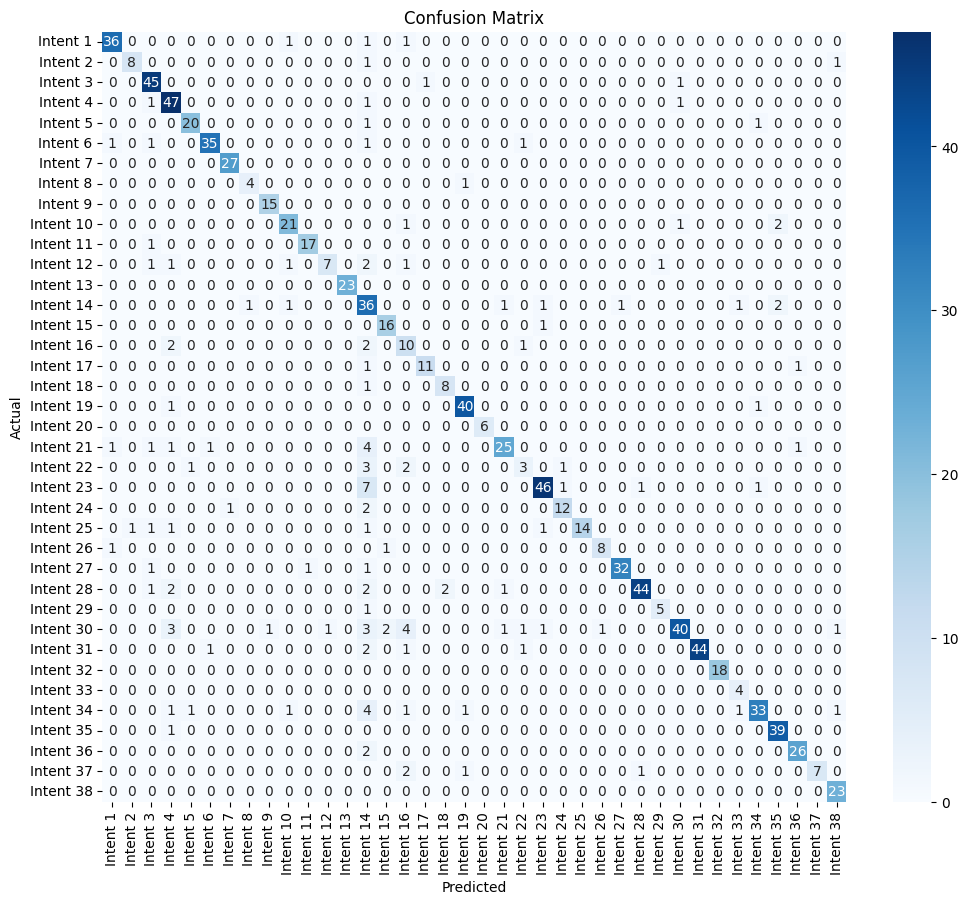

In [177]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have 'real_intents' and 'predicted_intents'
# Ensure that the unique classes are correctly identified
unique_classes = sorted(set(real_intents).union(set(predicted_intents)))

# Create a mapping for intent names to simplified labels like "Intent 1", "Intent 2", etc.
simplified_labels = [f"Intent {i + 1}" for i in range(len(unique_classes))]

# Create a confusion matrix
confusion = confusion_matrix(real_intents, predicted_intents)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(12, 10))  # Adjust the figure size to ensure labels fit
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', 
            xticklabels=simplified_labels, 
            yticklabels=simplified_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Save the figure without cutting anything off
plt.savefig('confusion_matrix.png', bbox_inches='tight', dpi=300)
plt.show()


In [178]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Pastikan real_intents dan predicted_intents dalam bentuk array
real_intents = np.array(real_intents)
predicted_intents = np.array(predicted_intents)

# Menghitung akurasi keseluruhan
accuracy = accuracy_score(real_intents, predicted_intents)

# Menghitung precision, recall, dan F1-score untuk setiap intent
precision = precision_score(real_intents, predicted_intents, average=None, labels=unique_classes)
recall = recall_score(real_intents, predicted_intents, average=None, labels=unique_classes)
f1 = f1_score(real_intents, predicted_intents, average=None, labels=unique_classes)

# Membuat dictionary untuk menyimpan metrik per intent
intent_metrics = {}

# Jika unique_classes adalah list, tidak perlu tolist
if isinstance(unique_classes, list):
    unique_classes_array = unique_classes
else:
    unique_classes_array = unique_classes.tolist()

# Menghitung akurasi per intent
for label in unique_classes_array:
    true_label = (real_intents == label).astype(int)
    predicted_label = (predicted_intents == label).astype(int)
    accuracy_per_intent = accuracy_score(true_label, predicted_label)

    # Menyimpan metrik ke dalam dictionary intent_metrics
    intent_metrics[label] = {
        'Accuracy': accuracy_per_intent,
        'Precision': precision[unique_classes_array.index(label)],  # Gunakan unique_classes_array
        'Recall': recall[unique_classes_array.index(label)],  # Gunakan unique_classes_array
        'F1 Score': f1[unique_classes_array.index(label)]  # Gunakan unique_classes_array
    }

# Mencetak metrik untuk setiap intent
for intent, metrics in intent_metrics.items():
    print(f"Intent: {intent}")
    print(f"Accuracy: {metrics['Accuracy']:.2f}")
    print(f"Precision: {metrics['Precision']:.2f}")
    print(f"Recall: {metrics['Recall']:.2f}")
    print(f"F1 Score: {metrics['F1 Score']:.2f}")
    print()


Intent: Account & Customer Information Management
Accuracy: 0.99
Precision: 0.92
Recall: 0.92
F1 Score: 0.92

Intent: After Sales & Service Termination
Accuracy: 1.00
Precision: 0.89
Recall: 0.80
F1 Score: 0.84

Intent: Application Usage
Accuracy: 0.99
Precision: 0.85
Recall: 0.96
F1 Score: 0.90

Intent: Billing
Accuracy: 0.98
Precision: 0.78
Recall: 0.94
F1 Score: 0.85

Intent: Business Training and Webinar
Accuracy: 1.00
Precision: 0.91
Recall: 0.91
F1 Score: 0.91

Intent: Call Center
Accuracy: 0.99
Precision: 0.95
Recall: 0.90
F1 Score: 0.92

Intent: Competitors
Accuracy: 1.00
Precision: 0.96
Recall: 1.00
F1 Score: 0.98

Intent: Customer ID Number
Accuracy: 1.00
Precision: 0.80
Recall: 0.80
F1 Score: 0.80

Intent: Discount & Referral Incentive
Accuracy: 1.00
Precision: 0.94
Recall: 1.00
F1 Score: 0.97

Intent: Disturbance Report
Accuracy: 0.99
Precision: 0.84
Recall: 0.84
F1 Score: 0.84

Intent: FUP Indibiz
Accuracy: 1.00
Precision: 0.94
Recall: 0.94
F1 Score: 0.94

Intent: General 

In [179]:
import csv

# Buat nama file CSV
csv_filename = 'intent_metrics.csv'

# Membuat header untuk file CSV
header = ['Intent', 'Accuracy', 'Precision', 'Recall', 'F1 Score']

# Membuka file CSV dalam mode penulisan
with open(csv_filename, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(header)

    # Menuliskan data ke dalam file CSV
    for intent, metrics in intent_metrics.items():
        row = [intent, metrics['Accuracy'], metrics['Precision'], metrics['Recall'], metrics['F1 Score']]
        writer.writerow(row)

print(f"Data hasil evaluasi telah disimpan dalam file {csv_filename}")

Data hasil evaluasi telah disimpan dalam file intent_metrics.csv


In [180]:
import pandas as pd

# Assuming you have the 'test_df' DataFrame with 'text' and 'intent' columns
# and the 'classify_intent' function defined

# Create an empty list to store the results
results = []

for index, row in test_df.iterrows():
    text = row['text']
    real_intent = row['intent']
    predicted_intent = classify_intent(text) 
    results.append({'Text': text, 'Real Intent': real_intent, 'Predicted Intent': predicted_intent})

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Save the DataFrame to a CSV file
results_df.to_csv('Hasil Evaluasi Testing.csv', index=False)

print("Hasil evaluasi telah disimpan dalam file 'Hasil Evaluasi Testing.csv'")

1/1 [==============================] - 0s 41ms/step
Hasil evaluasi telah disimpan dalam file 'Hasil Evaluasi Testing.csv'


In [181]:
import zipfile
import os
import shutil
from IPython.display import FileLink

# Simpan model dalam format .h5
model.save('/kaggle/working/cross_val_model.h5')

# Path ke file model yang disimpan
model_path = '/kaggle/working/cross_val_model.h5'

# Path ke file zip yang ingin dibuat
zip_path = '/kaggle/working/cross_val_model.zip'

# Membuat file zip
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Menambahkan file model langsung ke dalam zip
    zipf.write(model_path, os.path.basename(model_path))

print(f'Model berhasil disimpan dalam zip: {zip_path}')

# Direktori baru untuk menyimpan file yang ingin di-zip
new_dir = '/kaggle/working/cross_val_model_dir'
os.makedirs(new_dir, exist_ok=True)

# Pindahkan file model ke direktori baru
shutil.move(model_path, os.path.join(new_dir, os.path.basename(model_path)))

# Buat arsip ZIP dari direktori baru
shutil.make_archive('my_model_zip', 'zip', new_dir)

# Buat tautan unduhan
FileLink(r'my_model_zip.zip')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model berhasil disimpan dalam zip: /kaggle/working/cross_val_model.zip


/kaggle/working/my_model_zip.zip

# Breakdown Model by Cases

In [182]:
model.summary()  # Periksa detail arsitektur model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model_1 (TFBertMod  TFBaseModelOutputWithPooli   1244413   ['input_ids[0][0]',           
 el)                         ngAndCrossAttentions(last_   44         'attention_mask[0][0]']      
                             hidden_state=(None, 128, 7                                       

In [183]:
from transformers import BertTokenizer

# Teks input
text = "Maaf, saat ini saya tidak memiliki informasi mengenai apakah IndiBiz hanya menyediakan layanan IP publik statis atau juga dinamis."

#text = "maaf"


# Tokenisasi
tokens = tokenizer(
    text,
    max_length=128,          # Panjang maksimum input
    padding='max_length',    # Padding hingga panjang maksimum
    truncation=True,         # Memotong teks yang terlalu panjang
    return_tensors="tf",     # Mengembalikan tensor TensorFlow
    return_token_type_ids=True  # Mengembalikan Segment IDs
)

# Dekode token IDs kembali ke teks untuk melihat special tokens
decoded_tokens = tokenizer.convert_ids_to_tokens(tokens['input_ids'][0].numpy())

# Tampilkan hasil
print("Decoded Tokens (with Special Tokens):")
print(decoded_tokens)

print("\nInput IDs:")
print(tokens['input_ids'][0].numpy())

print("\nSegment IDs:")
print(tokens['token_type_ids'][0].numpy())

print("\nAttention Mask:")
print(tokens['attention_mask'][0].numpy())


Decoded Tokens (with Special Tokens):
['[CLS]', 'maaf', ',', 'saat', 'ini', 'saya', 'tidak', 'memiliki', 'informasi', 'mengenai', 'apakah', 'ind', '##ibi', '##z', 'hanya', 'menyediakan', 'layanan', 'ip', 'publik', 'statis', 'atau', 'juga', 'dinamis', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]

In [184]:
from transformers import TFBertModel

# Muat model BERT
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

# Proses token melalui model BERT
outputs = bert_model(**tokens)

# Matriks embedding
embedding_output = outputs.last_hidden_state

print("Word Embedding Matrix (Shape):", embedding_output.shape)
print(embedding_output.numpy())


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Word Embedding Matrix (Shape): (1, 128, 768)
[[[ 0.00416828  0.11225338  0.01978784 ... -0.02829815  0.41671038
    0.3067817 ]
  [-0.00370618  0.33188123  0.0870297  ... -0.09114446  0.29025626
    0.42826664]
  [ 0.11128183  0.15183406  0.17088994 ... -0.0864331   0.32274258
    0.26900533]
  ...
  [-0.0910753   0.09903204  0.1393224  ... -0.0431488   0.21291989
    0.10449007]
  [-0.09586627  0.1036661   0.12865123 ... -0.03847296  0.18152142
    0.11578183]
  [-0.05491714  0.04721536  0.16520186 ... -0.05367903  0.1848996
    0.12473115]]]


In [185]:


# Proses token melalui model BERT
outputs = bert_model(**tokens)

# Token Embeddings (last_hidden_state)
token_embeddings = outputs[0]  # last_hidden_state

# Mendapatkan embeddings melalui get_input_embeddings()
embedding_layer = bert_model.get_input_embeddings()

# Token Embeddings: Dapatkan token embeddings yang digunakan dalam model
tokens_embedding = embedding_layer(tokens['input_ids'])

# Segment Embeddings: Dapatkan embeddings untuk segment IDs
segment_embeddings = embedding_layer.token_type_embeddings

# Positional Embeddings
position_embeddings = embedding_layer.position_embeddings

# Print Shapes dan Embeddings
print("Token Embedding Matrix (Shape):", token_embeddings.shape)
print("Position Embedding Matrix (Shape):", position_embeddings.shape)
print("Segment Embedding Matrix (Shape):", segment_embeddings.shape)

# Menampilkan nilai embedding
print("\nToken Embeddings (sample):", tokens_embedding.numpy())
print("\nPosition Embeddings:", position_embeddings.numpy())
print("\nSegment Embeddings:", segment_embeddings.numpy())

# Dekode token IDs kembali ke teks untuk melihat special tokens
decoded_tokens = tokenizer.convert_ids_to_tokens(tokens['input_ids'][0].numpy())

# Tampilkan hasil
print("\nDecoded Tokens (with Special Tokens):")
print(decoded_tokens)

print("\nInput IDs:")
print(tokens['input_ids'][0].numpy())

print("\nSegment IDs:")
print(tokens['token_type_ids'][0].numpy())

print("\nAttention Mask:")
print(tokens['attention_mask'][0].numpy())

Token Embedding Matrix (Shape): (1, 128, 768)
Position Embedding Matrix (Shape): (512, 768)
Segment Embedding Matrix (Shape): (2, 768)

Token Embeddings (sample): [[[ 0.19222532 -0.6140829  -0.43035445 ... -0.04550891 -0.22153091
    0.31187108]
  [ 0.14776312 -0.01058501 -0.48643196 ...  0.09726597  0.599138
   -1.1919181 ]
  [ 0.7042209  -1.1682818  -0.4272591  ... -0.16125005 -0.74897736
   -1.0449015 ]
  ...
  [ 0.0265426  -0.17981428  0.4894176  ... -0.53213227 -0.24650902
    0.4658697 ]
  [-0.11945128 -0.2324248   0.24276948 ... -0.473973   -0.13932696
    0.3180415 ]
  [ 0.11076403 -0.07503897  0.32258204 ... -0.07308102 -0.5136851
    0.22896847]]]

Position Embeddings: [[ 1.7505383e-02 -2.5631009e-02 -3.6641564e-02 ...  3.3437202e-05
   6.8312453e-04  1.5441139e-02]
 [ 7.7580423e-03  2.2613001e-03 -1.9444324e-02 ...  2.8909724e-02
   2.9752752e-02 -5.3246655e-03]
 [-1.1287465e-02 -1.9644140e-03 -1.1572698e-02 ...  1.4907907e-02
   1.8740905e-02 -7.3139993e-03]
 ...
 [ 1.74179

In [186]:
# Muat model dengan output attentions
bert_model = TFBertModel.from_pretrained("bert-base-uncased", output_attentions=True)

# Proses token dengan model BERT
outputs = bert_model(**tokens)

# Matriks multihead attention
attention_matrices = outputs.attentions

# Contoh: Matriks attention dari layer pertama
if attention_matrices:
    print("Multihead Attention Matrix (Layer 1, Shape):", attention_matrices[0].shape)
    print(attention_matrices[0].numpy())

# Token kedua: karena indeks token dimulai dari [CLS], token pertama adalah [CLS] dan token kedua adalah "Hello"
token_index = 1  # Token kedua

if attention_matrices:
    # Ambil attention dari layer pertama (bisa diubah ke layer lain)
    attention_layer_1 = attention_matrices[0]  # Shape: (batch, heads, seq_len, seq_len)
    
    # Ambil hanya batch pertama
    batch_index = 0
    attention_layer_1 = attention_layer_1[batch_index]  # Shape: (heads, seq_len, seq_len)
    
    # Ambil hanya perhatian dari token ke-2 (index 1)
    token_2_attention = attention_layer_1[:, 1, :]  # Shape: (heads, seq_len)

    print("Scaled Dot Product Attention untuk Token 2 (Layer 1, Semua Heads):", token_2_attention.shape)
    print(token_2_attention.numpy())


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Multihead Attention Matrix (Layer 1, Shape): (1, 12, 128, 128)
[[[[0.01766862 0.03879048 0.05687886 ... 0.         0.
    0.        ]
   [0.0343499  0.04496497 0.03657495 ... 0.         0.
    0.        ]
   [0.0127448  0.01668928 0.02157217 ... 0.         0.
    0.        ]
   ...
   [0.0103113  0.01302647 0.0316848  ... 0.         0.
    0.        ]
   [0.0091623  0.01254626 0.02753052 ... 0.         0.
    0.        ]
   [0.01011272 0.01149663 0.02615634 ... 0.         0.
    0.        ]]

  [[0.6194421  0.01139484 0.01676797 ... 0.         0.
    0.        ]
   [0.00575837 0.01339983 0.03381223 ... 0.         0.
    0.        ]
   [0.07863286 0.01274047 0.02543078 ... 0.         0.
    0.        ]
   ...
   [0.08421239 0.02683604 0.02772537 ... 0.         0.
    0.        ]
   [0.08779059 0.02769119 0.03115098 ... 0.         0.
    0.        ]
   [0.08911543 0.02653317 0.03262438 ... 0.         0.
    0.        ]]

  [[0.7776383  0.01837524 0.01299655 ... 0.         0.
    0.      

In [187]:
# Pastikan attention_matrices ada
if attention_matrices:
    # Ambil attention dari layer pertama
    attention_layer_1 = attention_matrices[0]  # Shape: (batch, heads, seq_len, seq_len)
    
    # Ambil hanya batch pertama
    batch_index = 0
    attention_layer_1 = attention_layer_1[batch_index]  # Shape: (heads, seq_len, seq_len)
    
    # Ambil perhatian dari token ke-2 (index 1) untuk semua head
    token_2_attention = attention_layer_1[:, 1, :]  # Shape: (heads, seq_len)
    
    # Reshape untuk mendapatkan bentuk (12, 64)
    # Karena 768 dimensi dibagi 12 head, setiap head memiliki 64 dimensi
    # Kita perlu mengambil 64 token pertama yang relevan untuk setiap head
    token_2_attention_reshaped = token_2_attention[:, :64]  # Shape: (12, 64)
    
    print("Scaled Dot Product Attention untuk Token 2 (Layer 1, Semua Heads, 64 Dimensi per Head):")
    print(token_2_attention_reshaped.shape)
    print(token_2_attention_reshaped.numpy())

Scaled Dot Product Attention untuk Token 2 (Layer 1, Semua Heads, 64 Dimensi per Head):
(12, 64)
[[3.43498997e-02 4.49649654e-02 3.65749486e-02 5.29394858e-02
  5.54470457e-02 4.48279418e-02 5.07560708e-02 4.93195094e-02
  5.44762500e-02 2.45189164e-02 5.76530024e-02 5.01970127e-02
  2.69840546e-02 1.93411205e-02 5.71086667e-02 2.73803193e-02
  1.10293981e-02 2.81769969e-02 4.08315398e-02 2.54453290e-02
  6.07886128e-02 5.06791994e-02 2.24511400e-02 1.60128903e-02
  5.77457212e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.0

In [188]:
# Pastikan ada attention matrix
if attention_matrices:
    # Ambil layer pertama (bisa diganti ke layer lain jika ingin)
    attention_layer_1 = attention_matrices[0]  # Shape: (batch, heads, seq_len, seq_len)

    # Ambil batch pertama
    batch_index = 0
    attention_layer_1 = attention_layer_1[batch_index]  # Shape: (heads, seq_len, seq_len)

    # Token kedua dalam urutan (ingat token pertama adalah [CLS], jadi index = 1)
    token_index = 1

    # Ambil perhatian untuk token kedua di semua head
    token_2_attention = attention_layer_1[:, token_index, :]  # Shape: (heads, seq_len)

    # Concatenate perhatian dari semua head
    multihead_attention_token_2 = tf.concat(tf.unstack(token_2_attention, axis=0), axis=-1)  # Shape: (seq_len * heads,)

    print("Multihead Attention Matrix for Token 2 (Layer 1, Shape):", multihead_attention_token_2.shape)
    print(multihead_attention_token_2.numpy())


Multihead Attention Matrix for Token 2 (Layer 1, Shape): (1536,)
[0.0343499  0.04496497 0.03657495 ... 0.         0.         0.        ]


In [189]:
# Matriks Token Kedua
second_token_output = embedding_output[:, 1, :]

print("Feed Forward & Add-Norm Output (Token Kedua, Shape):", second_token_output.shape)
print(second_token_output.numpy())

# Menampilkan hanya 10 nilai pertama dari token kedua
print("Feed Forward & Add-Norm Output (Token Kedua, Singkat):", second_token_output[0, :10].numpy())



Feed Forward & Add-Norm Output (Token Kedua, Shape): (1, 768)
[[-3.70618328e-03  3.31881225e-01  8.70297030e-02  1.41858652e-01
  -1.05164126e-01  1.70776159e-01 -5.79490662e-02 -3.44404578e-01
  -3.20804864e-01 -1.19016066e-01  7.77975321e-02 -5.70251904e-02
  -3.54435682e-01  4.78647351e-01 -5.27408235e-02  5.12546539e-01
   5.95297515e-01  2.02758536e-01 -4.34085160e-01 -4.46084663e-02
   9.69858825e-01  4.39977914e-01  2.46501744e-01  3.42029661e-01
   1.41568631e-01  1.45410120e-01  3.24697077e-01 -3.05702686e-02
  -4.96813744e-01 -2.57097512e-01  3.72409075e-01  3.04139018e-01
   3.94008607e-01  1.10455468e-01  3.86207730e-01 -3.32202911e-01
   8.11011344e-02  4.93454821e-02  5.54168522e-01 -2.58880883e-01
   1.94131911e-01 -4.97073889e-01  5.88435471e-01  1.68054760e-01
   5.20515963e-02 -6.54799163e-01 -1.01648617e+00  4.48119998e-01
  -6.17853284e-01 -7.21795976e-01 -4.16488916e-01  2.05408171e-01
   5.19380748e-01  9.33695436e-02 -4.85490449e-02  5.02904177e-01
   2.50449359e

In [190]:
from sklearn.preprocessing import LabelEncoder

# Pastikan menggunakan LabelEncoder dari data pelatihan
le = LabelEncoder()
le.fit(df_patterns['intent'])

# Update res_dict menggunakan LabelEncoder
res_dict = {index: intent for index, intent in enumerate(le.classes_)}

# Prediksi probabilitas dari model
probabilities = model.predict([tokens['input_ids'], tokens['attention_mask']])[0]
probabilities

1/1 [==============================] - 4s 4s/step


array([6.4399988e-09, 5.8907688e-09, 7.1527843e-08, 1.0771194e-08,
       1.8037022e-07, 2.7516121e-08, 1.8352263e-07, 1.3601478e-08,
       1.3701534e-09, 2.3748843e-09, 3.7313406e-08, 7.4370865e-10,
       9.9999928e-01, 2.4736103e-08, 7.3182567e-09, 2.4830915e-09,
       4.1633818e-08, 2.4192395e-10, 1.7245444e-08, 1.0960868e-08,
       1.7034867e-09, 2.4536992e-09, 7.8233446e-09, 7.1730271e-09,
       7.7834522e-10, 2.4928445e-08, 5.3175098e-10, 1.1203726e-09,
       1.0854343e-09, 3.8508293e-08, 2.3654957e-08, 1.3028516e-09,
       4.3151660e-09, 4.2770529e-10, 8.3178575e-09, 4.4255679e-09,
       8.1387280e-10, 1.1187240e-09], dtype=float32)

In [191]:
# Ambil seluruh intent dan probabilitasnya
print("Seluruh intent dan probabilitasnya:")
for idx, prob in enumerate(probabilities):
    intent = res_dict[idx]
    print(f"{intent}: {prob:.10f}")

# Cari indeks kategori dengan probabilitas tertinggi
predicted_class_idx = np.argmax(probabilities)

# Ambil nama kategori dari res_dict berdasarkan indeks
predicted_category = res_dict[predicted_class_idx]

# Tampilkan hasil
print("\nKategori dengan probabilitas tertinggi:")
print(f"{predicted_category}: {probabilities[predicted_class_idx]:.10f}")


Seluruh intent dan probabilitasnya:
Account & Customer Information Management: 0.0000000064
After Sales & Service Termination: 0.0000000059
Application Usage: 0.0000000715
Billing: 0.0000000108
Business Training and Webinar: 0.0000001804
Call Center: 0.0000000275
Competitors: 0.0000001835
Customer ID Number: 0.0000000136
Discount & Referral Incentive: 0.0000000014
Disturbance Report: 0.0000000024
FUP Indibiz: 0.0000000373
General Business Information: 0.0000000007
IP Services: 0.9999992847
Indibiz Package: 0.0000000247
Internet Speed: 0.0000000073
Irrelevant Question: 0.0000000025
Modem: 0.0000000416
New Installation: 0.0000000002
Number on Application: 0.0000000172
Optical Distribution Point: 0.0000000110
Order & Subscription Information: 0.0000000017
Others: 0.0000000025
Package Information: 0.0000000078
Package Migration: 0.0000000072
Price: 0.0000000008
Product & Package Differences: 0.0000000249
Product Advantages and Disadvantages: 0.0000000005
Product Installation: 0.0000000011


In [192]:
import csv
import numpy as np

# Melakukan prediksi untuk mendapatkan probabilitas
probabilities = model.predict([tokens['input_ids'], tokens['attention_mask']])[0]

# Menulis intent dan probabilitasnya ke dalam file CSV
with open('intent_probabilities.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Menulis header kolom
    writer.writerow(['Intent', 'Probability'])
    
    # Menulis intent dan probabilitasnya
    for idx, prob in enumerate(probabilities):
        intent = res_dict[idx]
        writer.writerow([intent, f"{prob:.10f}"])  # Gunakan 6 angka desimal

# Cari indeks kategori dengan probabilitas tertinggi
predicted_class_idx = np.argmax(probabilities)

# Ambil nama kategori dari res_dict berdasarkan indeks
predicted_category = res_dict[predicted_class_idx]

# Menulis kategori dengan probabilitas tertinggi ke file CSV
with open('intent_probabilities.csv', mode='a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Predicted Category', predicted_category])
    writer.writerow(['Probability', f"{probabilities[predicted_class_idx]:.10f}"])  # Gunakan 6 angka desimal

print("CSV berhasil dibuat.")


1/1 [==============================] - 0s 43ms/step
CSV berhasil dibuat.
